<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('bmh')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()
pd.set_option('display.max_columns', None)

In [3]:
# First things first remove all Agriculture, Commercial, and Industrial properties
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [4]:
# First things first remove all Agriculture, Commercial, and Industrial properties
commercial = house[(house.MSZoning=='C (all)')]
residential = house[(house.MSZoning!='C (all)')]

In [5]:
residential.loc[496]

Id                  497
MSSubClass           20
MSZoning             RL
LotFrontage         NaN
LotArea           12692
                  ...  
MoSold                5
YrSold             2007
SaleType             WD
SaleCondition    Normal
SalePrice        430000
Name: 496, Length: 81, dtype: object

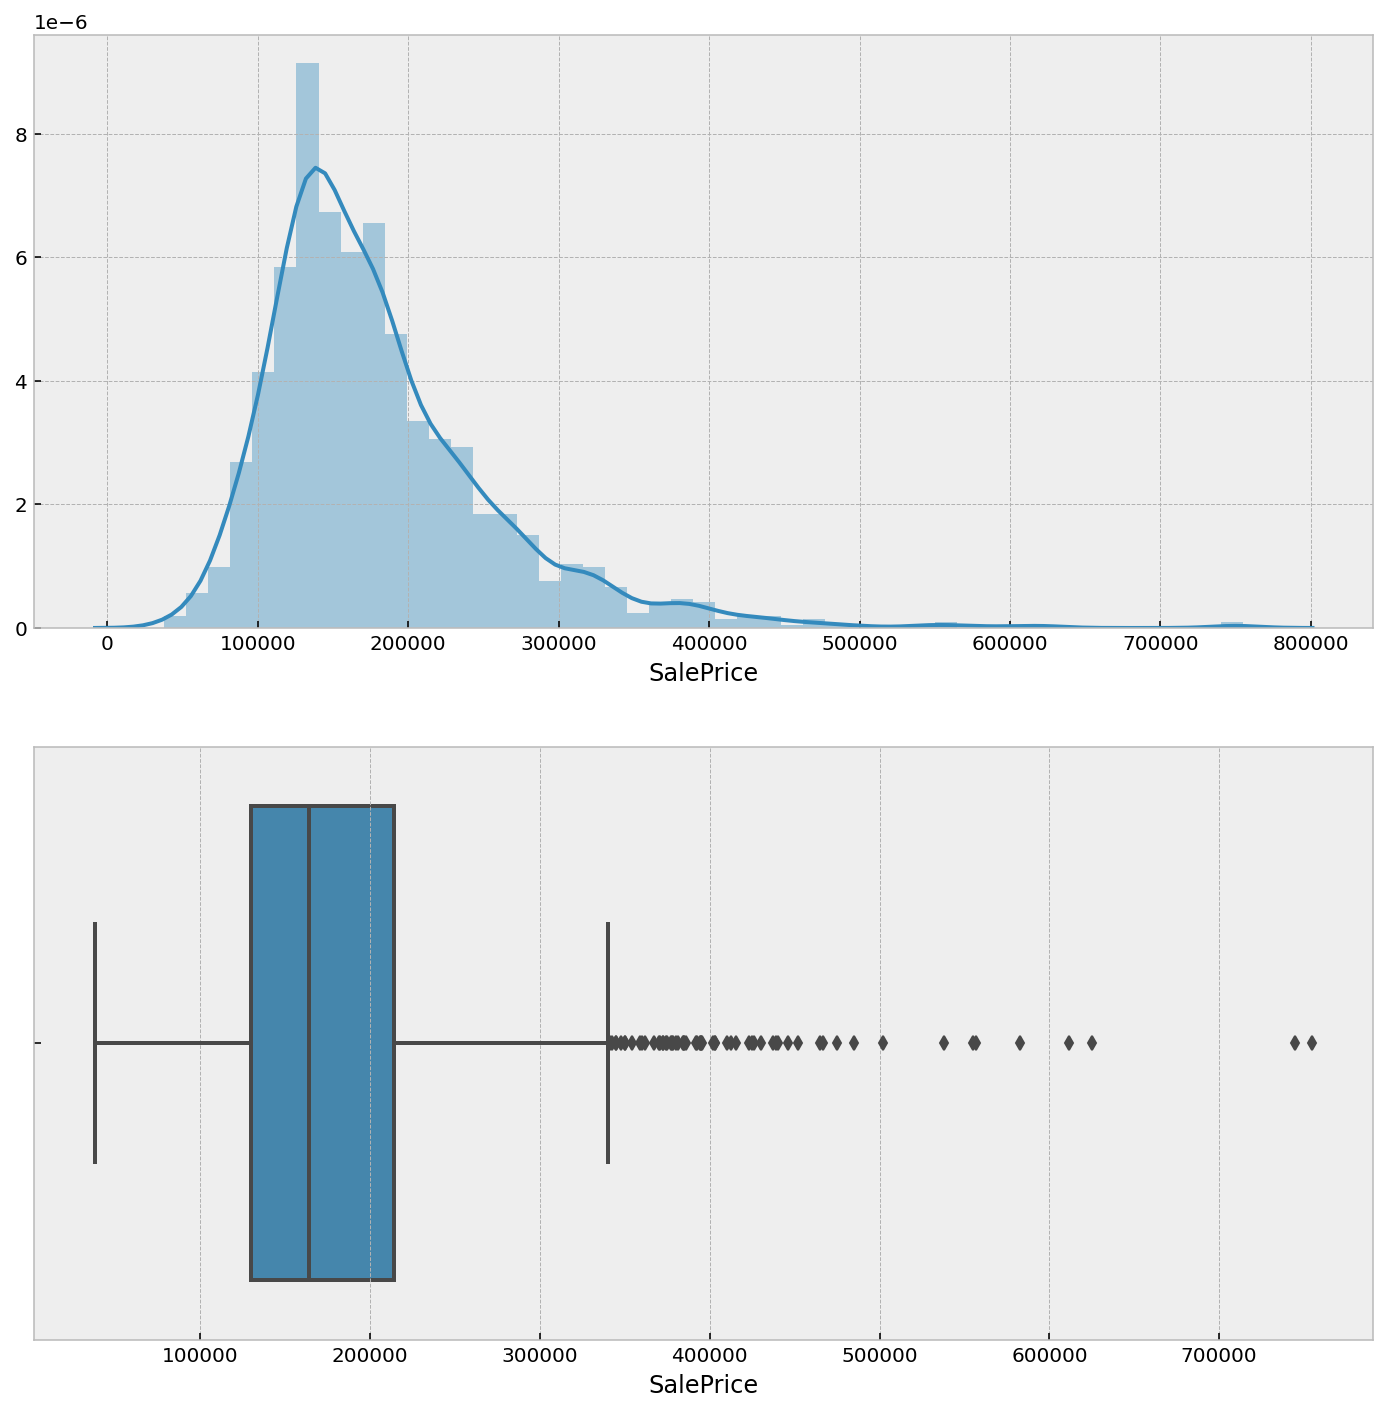

In [6]:
# Have a look at the target Variable
# A:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

sns.distplot(residential['SalePrice'], ax=ax[0])
sns.boxplot(residential['SalePrice'], ax=ax[1]);

We have a right skewed distribution with some of the house prices looking particularly large. Let's see if any of them are outliers worth removing from our dataset.

In [7]:
residential.describe().loc[:,'SalePrice']

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
sale_LQR = residential.describe().loc['25%','SalePrice']
sale_UQR = residential.describe().loc['75%','SalePrice']
sale_IQR = sale_UQR - sale_LQR

print('1.5*IQR above the UQR : ',sale_UQR + (1.5*sale_IQR))
residential[residential['SalePrice']>= sale_UQR + (1.5*sale_IQR)]

1.5*IQR above the UQR :  340000.0


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
11      12          60       RL         85.0    11924   Pave   NaN      IR1   
53      54          20       RL         68.0    50271   Pave   NaN      IR1   
58      59          60       RL         66.0    13682   Pave   NaN      IR2   
112    113          60       RL         77.0     9965   Pave   NaN      Reg   
151    152          20       RL        107.0    13891   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1353  1354          50       RL         56.0    14720   Pave   NaN      IR1   
1373  1374          20       RL          NaN    11400   Pave   NaN      Reg   
1388  1389          20       RL         42.0    14892   Pave   NaN      IR1   
1417  1418          60       RL          NaN    16545   Pave   NaN      IR1   
1437  1438          20       RL         96.0    12444   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
11           Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
53           Low    AllPub    Inside       Gtl      Veenker       Norm   
58           HLS    AllPub   CulDSac       Gtl      StoneBr       Norm   
112          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
151          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
...          ...       ...       ...       ...          ...        ...   
1353         Lvl    AllPub   CulDSac       Gtl      NoRidge       Norm   
1373         Lvl    AllPub    Inside       Gtl      NoRidge       Norm   
1388         HLS    AllPub   CulDSac       Gtl      Gilbert       Norm   
1417         Lvl    AllPub    Inside       Gtl      NoRidge       Norm   
1437         Lvl    AllPub       FR2       Gtl      NridgHt       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
11         Norm     1Fam     2Story            9            5       2005   
53         Norm     1Fam     1Story            9            5       1981   
58         Norm     1Fam     2Story           10            5       2006   
112        Norm     1Fam     2Story            7            5       2007   
151        Norm     1Fam     1Story            8            5       2007   
...         ...      ...        ...          ...          ...        ...   
1353       Norm     1Fam     1.5Fin            8            5       1995   
1373       Norm     1Fam     1Story           10            5       2001   
1388       Norm     1Fam     1Story            9            5       2006   
1417       Norm     1Fam     2Story            8            5       1998   
1437       Norm     1Fam     1Story            8            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
11            2006       Hip  CompShg     WdShing     Wd Shng      Stone   
53            1987     Gable  WdShngl     WdShing     Wd Shng       None   
58            2006       Hip  CompShg     VinylSd     VinylSd    BrkFace   
112           2007     Gable  CompShg     VinylSd     VinylSd      Stone   
151           2008       Hip  CompShg     VinylSd     VinylSd      Stone   
...            ...       ...      ...         ...         ...        ...   
1353          1996       Hip  CompShg     VinylSd     VinylSd    BrkFace   
1373          2002       Hip  CompShg     VinylSd     VinylSd    BrkFace   
1388          2007     Gable  CompShg     VinylSd     VinylSd      Stone   
1417          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1437          2008       Hip  CompShg     VinylSd     VinylSd      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
11         286.0        Ex        TA      PConc       Ex       TA   
53           0.0        Gd        TA     CBlock       Ex       TA   
58        1031.0        Ex        TA      PConc       Ex       TA   
112        220.0        Gd        TA      PConc       Ex       TA   

2 std deviations above the mean matches with 1.5*IQR above UQR, however to try and reduce the amount of outliers we remove from the data set we will only remove properties which are 3 standard deviations above the mean. This will make our model more reliable for the vast majority of houses in N. Ames.

In [9]:
sale_mean = residential.describe().loc['mean','SalePrice']
sale_std = residential.describe().loc['std','SalePrice']

print('2std above mean : ', sale_mean + (2*sale_std))
print('3std above mean : ', sale_mean + (3*sale_std))
residential[residential['SalePrice']>= sale_mean + (3*sale_std)]

2std above mean :  340007.912551582
3std above mean :  419184.3977928902


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
58      59          60       RL         66.0    13682   Pave   NaN      IR2   
178    179          20       RL         63.0    17423   Pave   NaN      IR1   
185    186          75       RM         90.0    22950   Pave   NaN      IR2   
349    350          60       RL         56.0    20431   Pave   NaN      IR2   
389    390          60       RL         96.0    12474   Pave   NaN      Reg   
440    441          20       RL        105.0    15431   Pave   NaN      Reg   
473    474          20       RL        110.0    14977   Pave   NaN      IR1   
496    497          20       RL          NaN    12692   Pave   NaN      IR1   
527    528          60       RL         67.0    14948   Pave   NaN      IR1   
591    592          60       RL         97.0    13478   Pave   NaN      IR1   
664    665          20       RL         49.0    20896   Pave   NaN      IR2   
691    692          60       RL        104.0    21535   Pave   NaN      IR1   
769    770          60       RL         47.0    53504   Pave   NaN      IR2   
798    799          60       RL        104.0    13518   Pave   NaN      Reg   
803    804          60       RL        107.0    13891   Pave   NaN      Reg   
898    899          20       RL        100.0    12919   Pave   NaN      IR1   
1046  1047          60       RL         85.0    16056   Pave   NaN      IR1   
1142  1143          60       RL         77.0     9965   Pave   NaN      Reg   
1169  1170          60       RL        118.0    35760   Pave   NaN      IR1   
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   
1243  1244          20       RL        107.0    13891   Pave   NaN      Reg   
1373  1374          20       RL          NaN    11400   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
58           HLS    AllPub   CulDSac       Gtl      StoneBr       Norm   
178          Lvl    AllPub   CulDSac       Gtl      StoneBr       Norm   
185          Lvl    AllPub    Inside       Gtl      OldTown     Artery   
349          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
389          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
440          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
473          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
496          Lvl    AllPub    Inside       Gtl      NoRidge       Norm   
527          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
591          Lvl    AllPub    Corner       Gtl      NridgHt       Norm   
664          Lvl    AllPub   CulDSac       Gtl      Somerst       RRAn   
691          Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
769          HLS    AllPub   CulDSac       Mod      StoneBr       Norm   
798          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
803          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
898          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
1046         Lvl    AllPub    Inside       Gtl      StoneBr       Norm   
1142         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1169         Lvl    AllPub   CulDSac       Gtl      NoRidge       Norm   
1182         Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
1243         Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
1373         Lvl    AllPub    Inside       Gtl      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
58         Norm     1Fam     2Story           10            5       2006   
178        Norm     1Fam     1Story            9            5       2008   
185        Norm     1Fam     2.5Fin           10            9       1892   
349        Norm     1Fam     2Story            9            5       2005   
389        Norm     1Fam     2Story           10            5       2007   
440        Norm     1Fam     1S

In [10]:
index_to_be_removed = []
for i in residential[residential['SalePrice']>= sale_mean + (3*sale_std)].index:
    index_to_be_removed.append(i)

In [11]:
# We have 81 residential variables
residential.shape

(1450, 81)

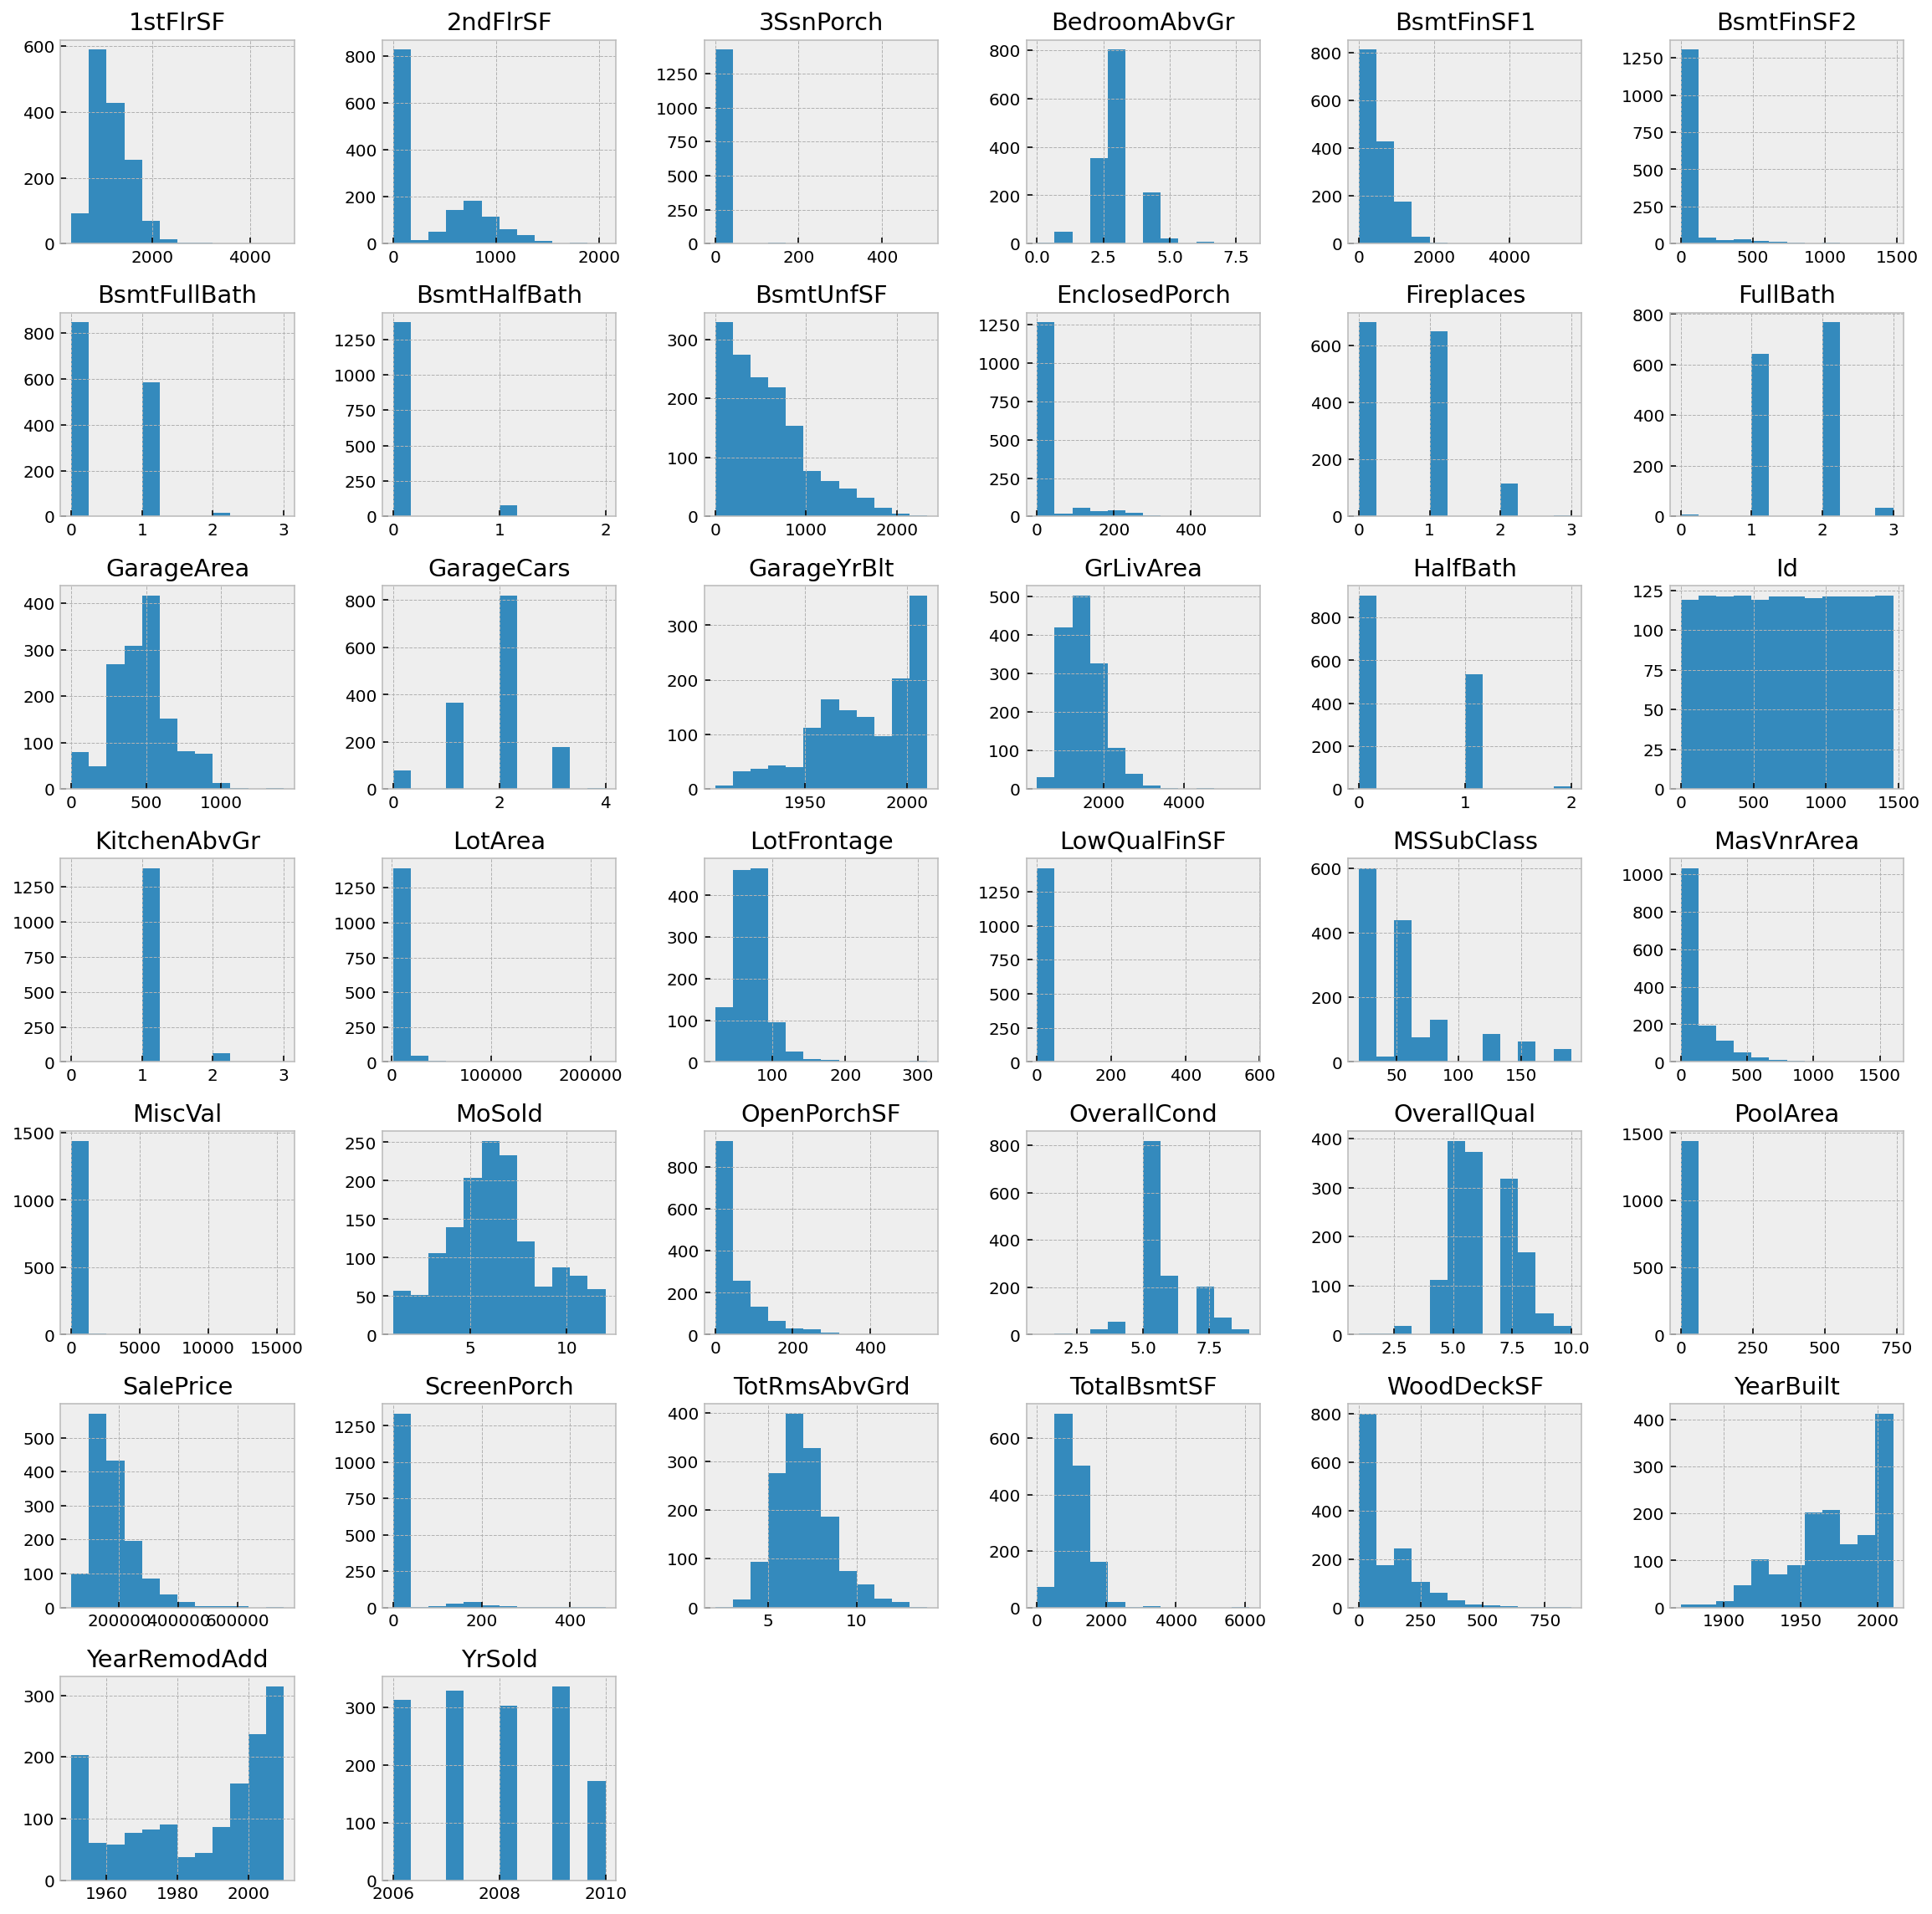

In [12]:
residential.hist(figsize=(16, 16), bins=12)
plt.tight_layout()
plt.show()

Lets have a look at some of the variables with null values :-

In [13]:
residential.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

### PoolQC and PoolArea :-

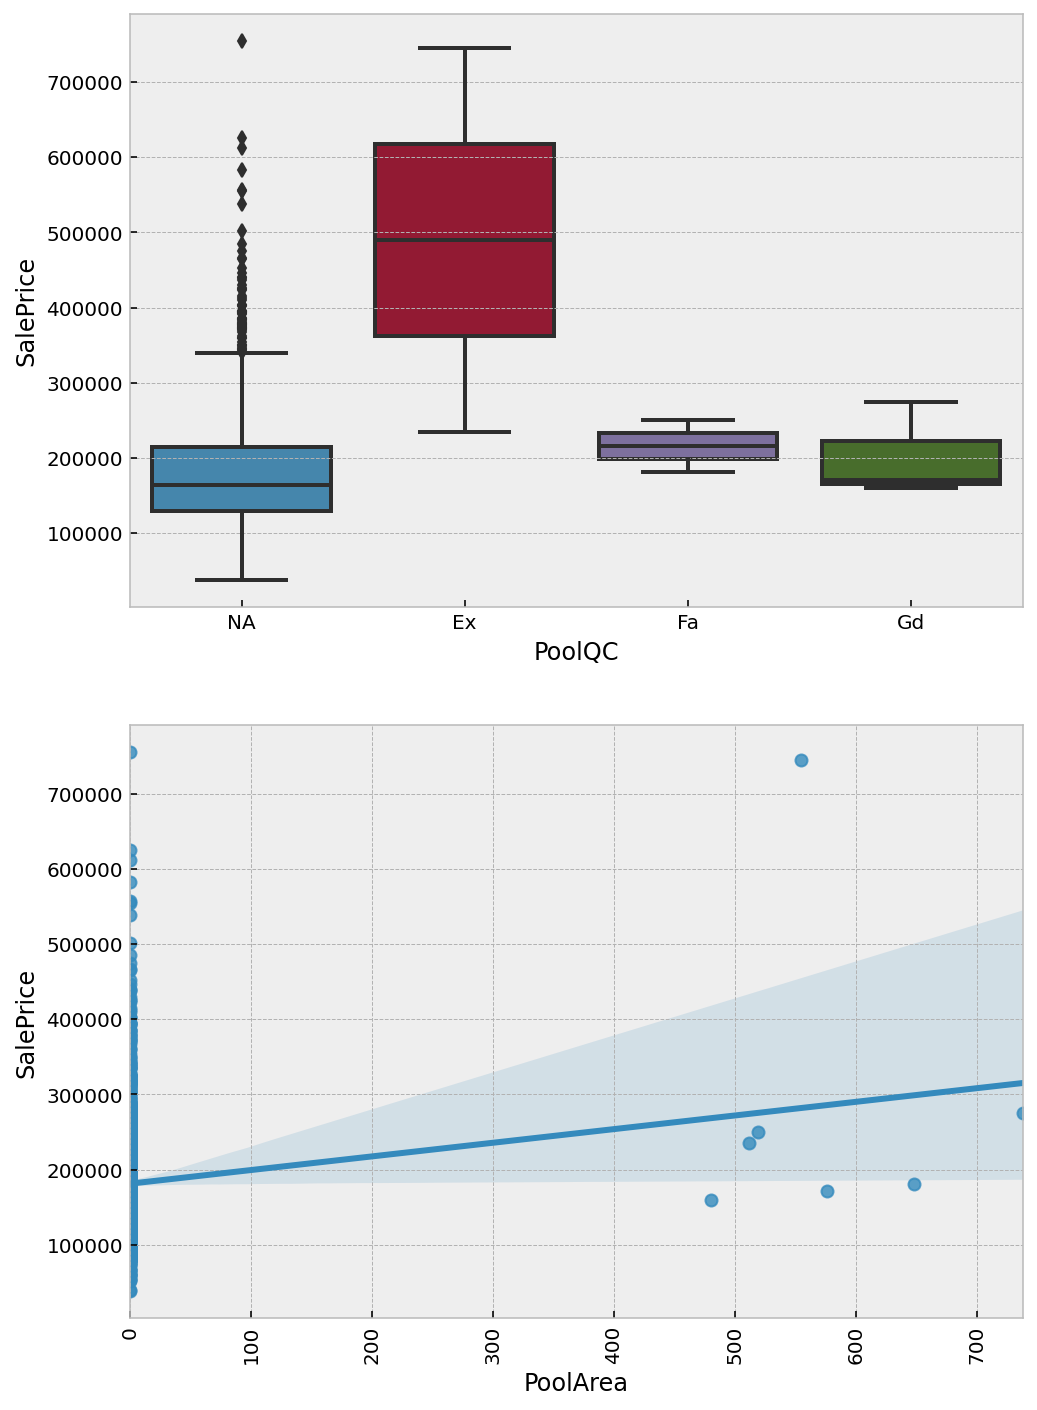

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64


In [14]:
fig, ax = plt.subplots(figsize=(8,12), nrows=2)
sns.boxplot(x=residential.PoolQC.fillna(value='NA'), y=residential.SalePrice, ax=ax[0])
sns.regplot(x=residential.PoolArea, y=residential.SalePrice, ax=ax[1])
plt.xticks(rotation=90)
plt.show()
print(residential['PoolQC'].value_counts())

Because of the small number of properties with a pool, only 7, we will remove these two variables and just add a Has_Pool binary variable.

In [15]:
residential['Has_Pool'] = residential['PoolArea'].map(
    lambda x: 1 if x>0 else 0)

print(residential.Has_Pool.value_counts())

0    1443
1       7
Name: Has_Pool, dtype: int64


<ipython-input-15-d13d72ce16f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residential['Has_Pool'] = residential['PoolArea'].map(


In [16]:
columns_to_be_removed = ['PoolQC', 'PoolArea']

### MiscFeature and MiscVal :-

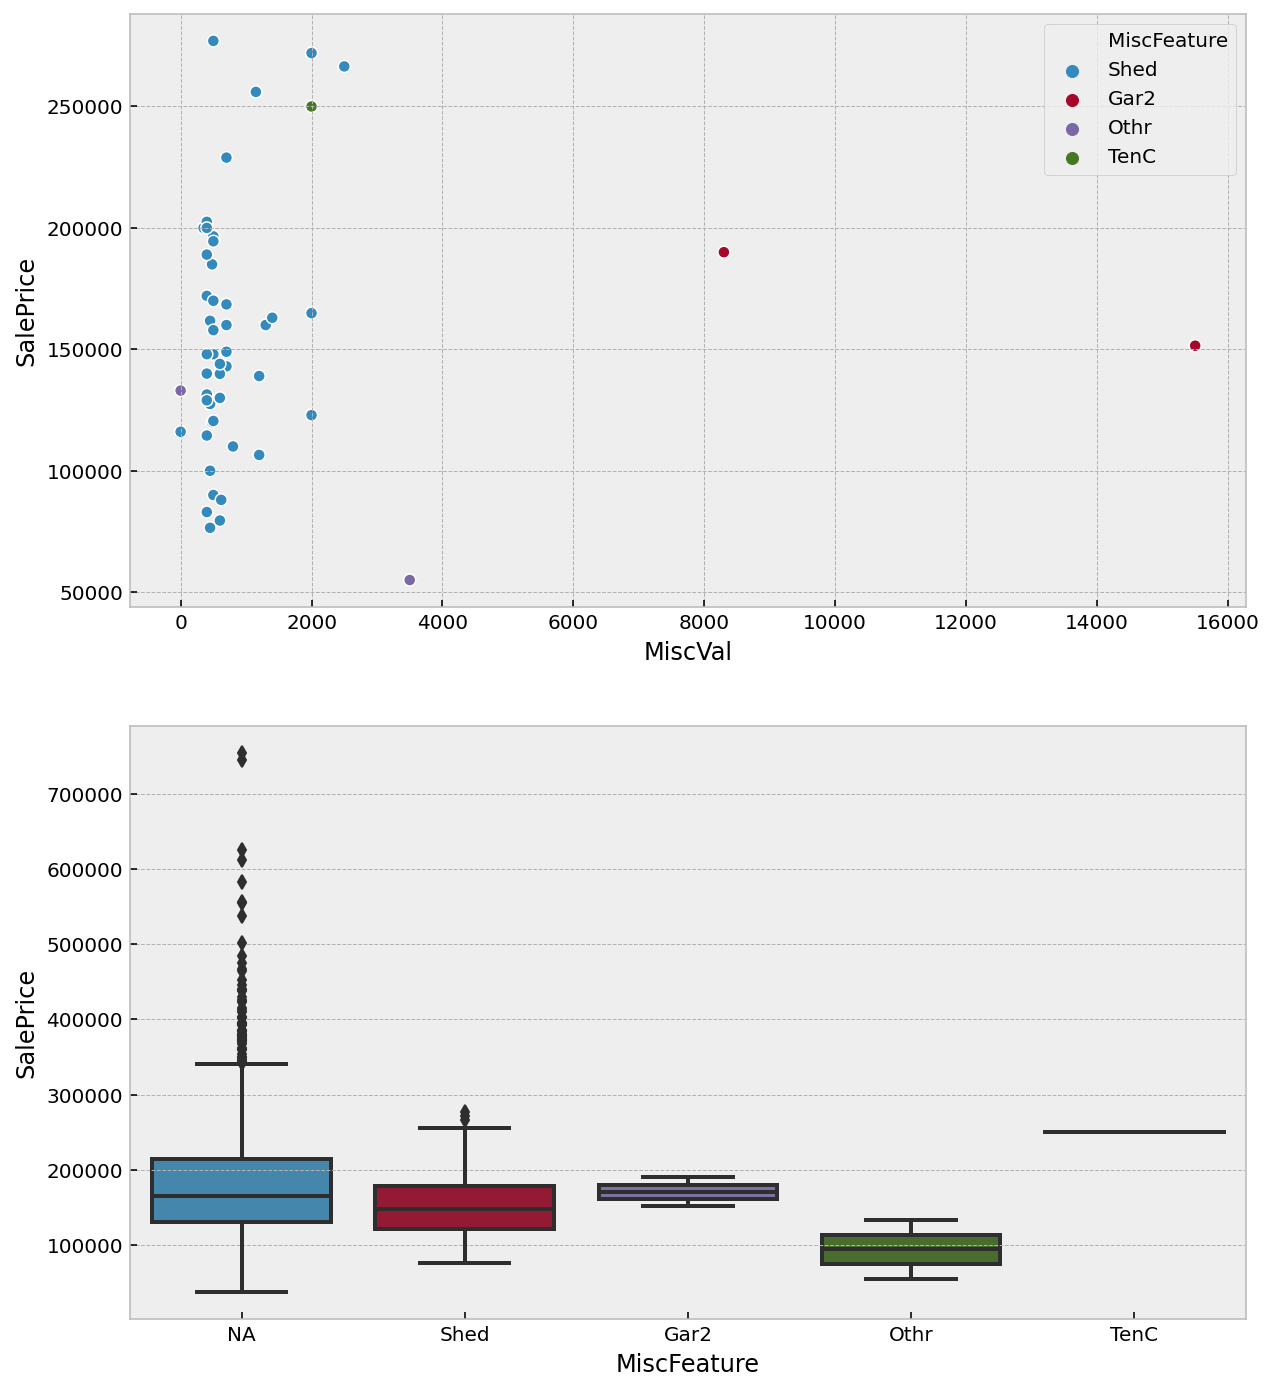

Shed    47
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64


In [17]:
fig, ax = plt.subplots(figsize=(10,12), nrows=2)
sns.scatterplot(x=residential['MiscVal'], y=residential['SalePrice'],
                ax=ax[0], data=residential, hue='MiscFeature', legend='full')
sns.boxplot(x=residential.MiscFeature.fillna(value='NA'),
            y=residential.SalePrice, ax=ax[1])
plt.show()

print(residential['MiscFeature'].value_counts())

With the small numbers of properties with a MiscFeature, we will remove the MiscFeature column, but for the time being leave the MiscVal variable in as this should have a relatively direct impact on the sale price.

In [18]:
columns_to_be_removed += ['MiscFeature']
columns_to_be_removed

['PoolQC', 'PoolArea', 'MiscFeature']

### Alley :-

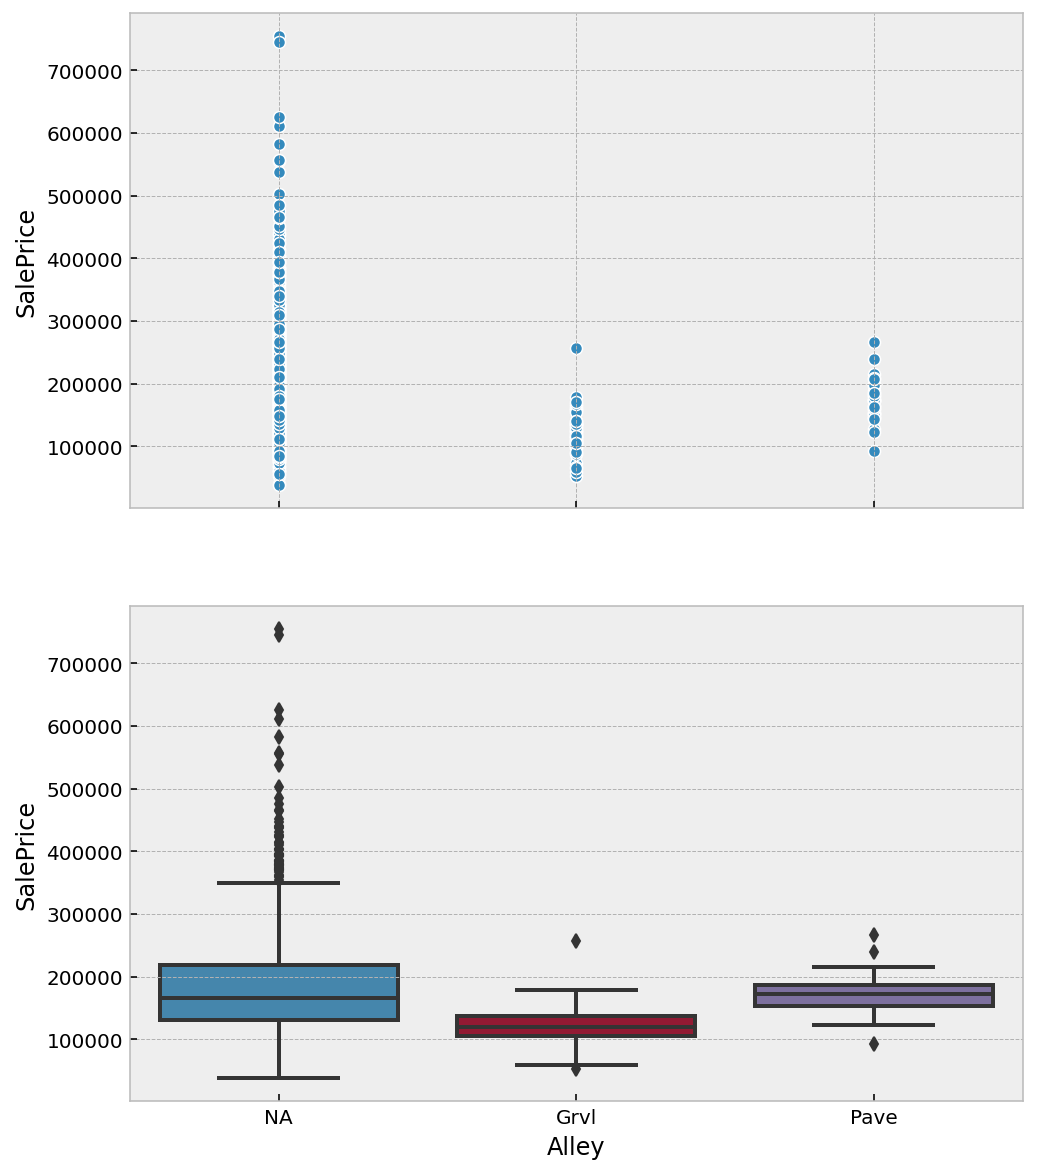

Grvl    50
Pave    39
Name: Alley, dtype: int64


In [19]:
fig, ax = plt.subplots(figsize=(8,10), nrows=2, sharex=True)
sns.scatterplot(x=residential['Alley'].fillna(value='NA'), y=residential['SalePrice'],
                ax=ax[0], data=residential, legend='full')
sns.boxplot(x=residential['Alley'].fillna(value='NA'),
            y=residential['SalePrice'])
plt.show()

print(residential['Alley'].value_counts())

Due to the small amount of values not being null in Alley we will remove this variablle.

In [20]:
columns_to_be_removed += ['Alley']

### Fence :-

MnPrv    155
GdPrv     59
GdWo      53
MnWw      11
Name: Fence, dtype: int64


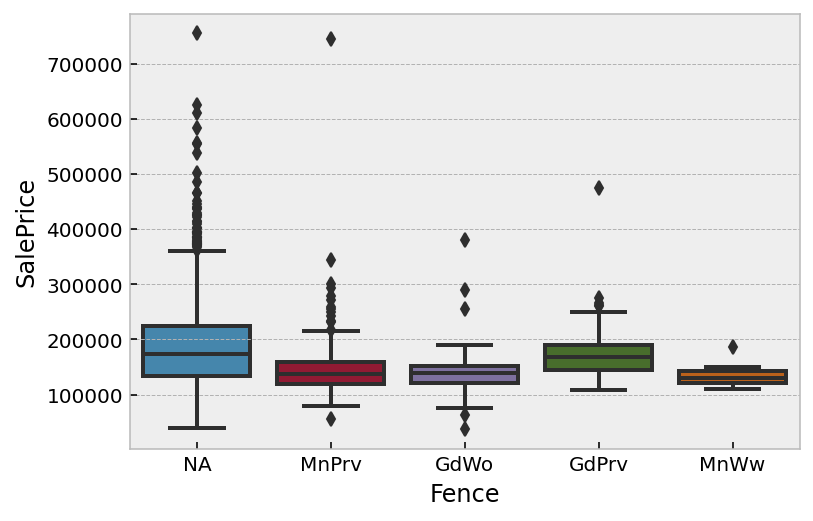

In [21]:
sns.boxplot(x=residential['Fence'].fillna(value='NA'),
            y=residential['SalePrice']);

print(residential['Fence'].value_counts())

Little change needs to be made to the Fence variable, we will be dummifying the variable and only need to fill in the null value.

In [22]:
residential['Fence'].fillna('None', inplace=True)

/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### FireplaceQu and Fireplaces :-

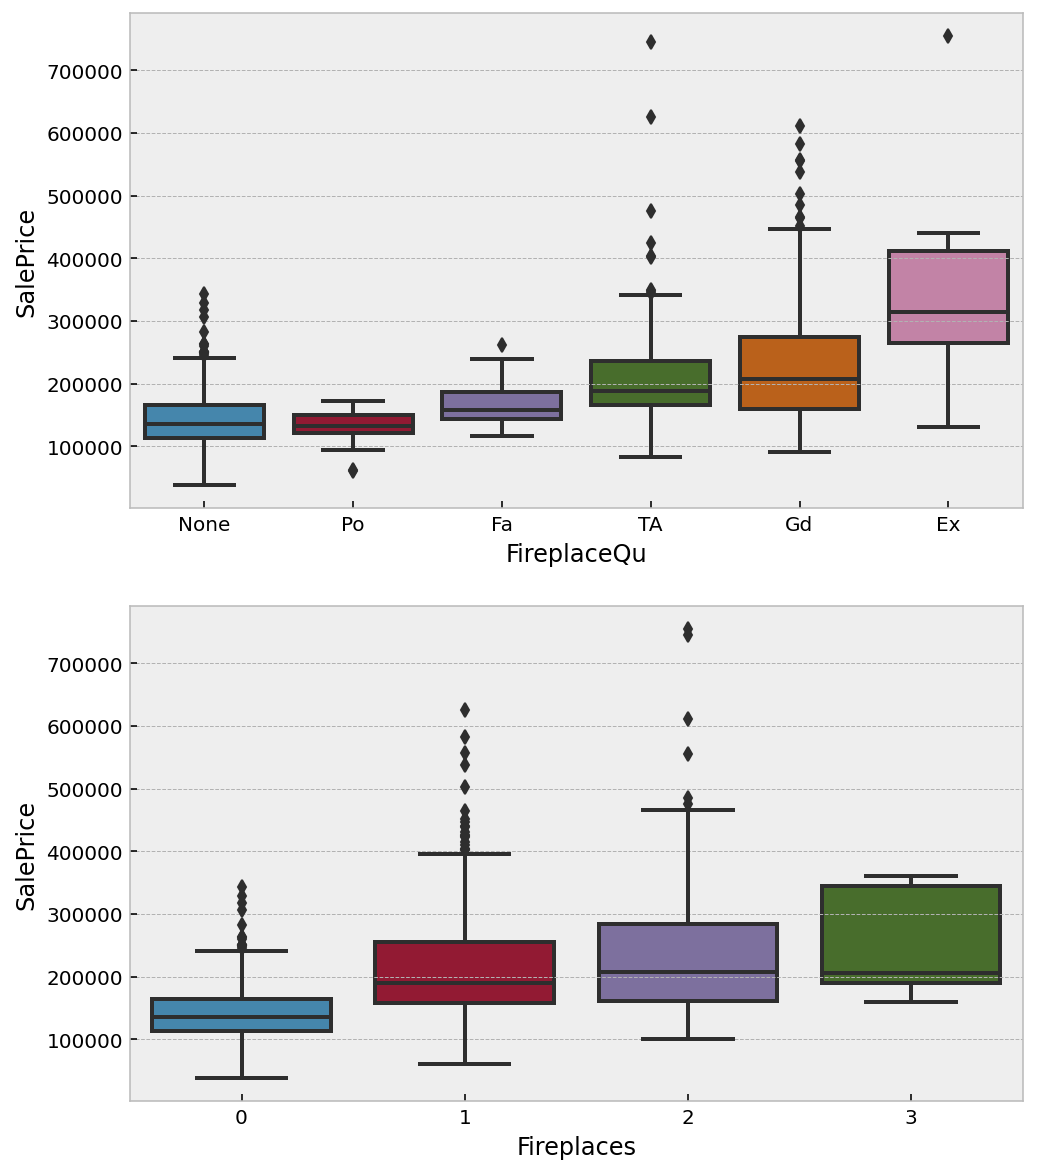

Gd    379
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
0    681
1    649
2    115
3      5
Name: Fireplaces, dtype: int64


In [23]:
fig, ax = plt.subplots(figsize=(8,10), nrows=2)

sns.boxplot(x=residential['FireplaceQu'].fillna('None'),
            y=residential['SalePrice'], ax=ax[0],
            order=['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])

sns.boxplot(x=residential['Fireplaces'].fillna(value='NA'),
            y=residential['SalePrice'], ax=ax[1])
plt.show()

print(residential['FireplaceQu'].value_counts())
print(residential['Fireplaces'].value_counts())

Both Fireplaces and FireplaceQu seem to be well matched with price, we will keep in all the values and just fill in the null values in FireplaceQu.

In [24]:
residential['FireplaceQu'].fillna('None', inplace=True)

/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### LotFrontage and LotArea :-

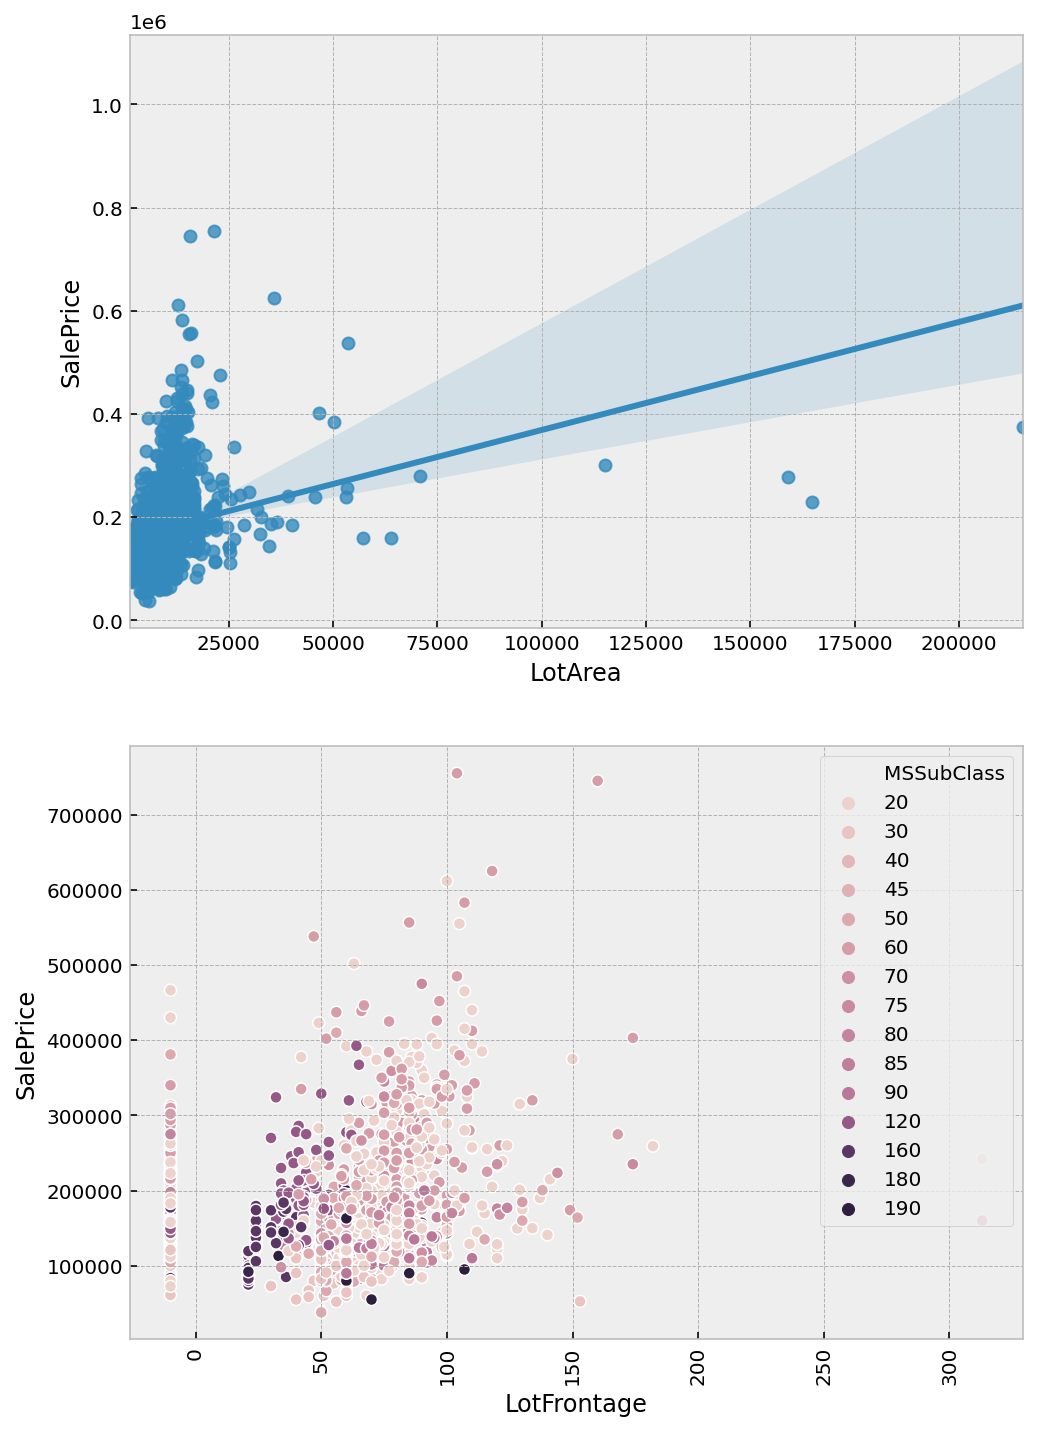

In [25]:
fig, ax = plt.subplots(figsize=(8,12), nrows=2)
sns.regplot(x=residential['LotArea'], y=residential['SalePrice'], ax=ax[0])
sns.scatterplot(x=residential['LotFrontage'].fillna(-10), y=residential['SalePrice'],
            ax=ax[1], hue=residential['MSSubClass'], legend='full')
plt.xticks(rotation=90)
plt.show()
# print(residential['PoolQC'].value_counts())

Lets have a closer look at the LotFrontage in comparison to the type of dwelling. If they can be identified as all flats we can change those values as 0 comfortably.

In [26]:
residential[residential['LotFrontage'].isnull()].MSSubClass.value_counts()

20     99
60     69
120    20
80     20
50     16
160     8
85      6
30      6
90      5
70      5
190     3
75      1
40      1
Name: MSSubClass, dtype: int64

From this it appears like the LotFrontage variable is probably missing data. We have 2 options, either impute a value for the Lot or drop variable entirely. 

We could also drop all indecies which have a null value in the LotFrontage but this is 259 properties and is over 10% of the entire dataset, so this shoiuld be avoided.

Lets have a closer look at the LotArea variable and see if there are some outliers before making any decisions.

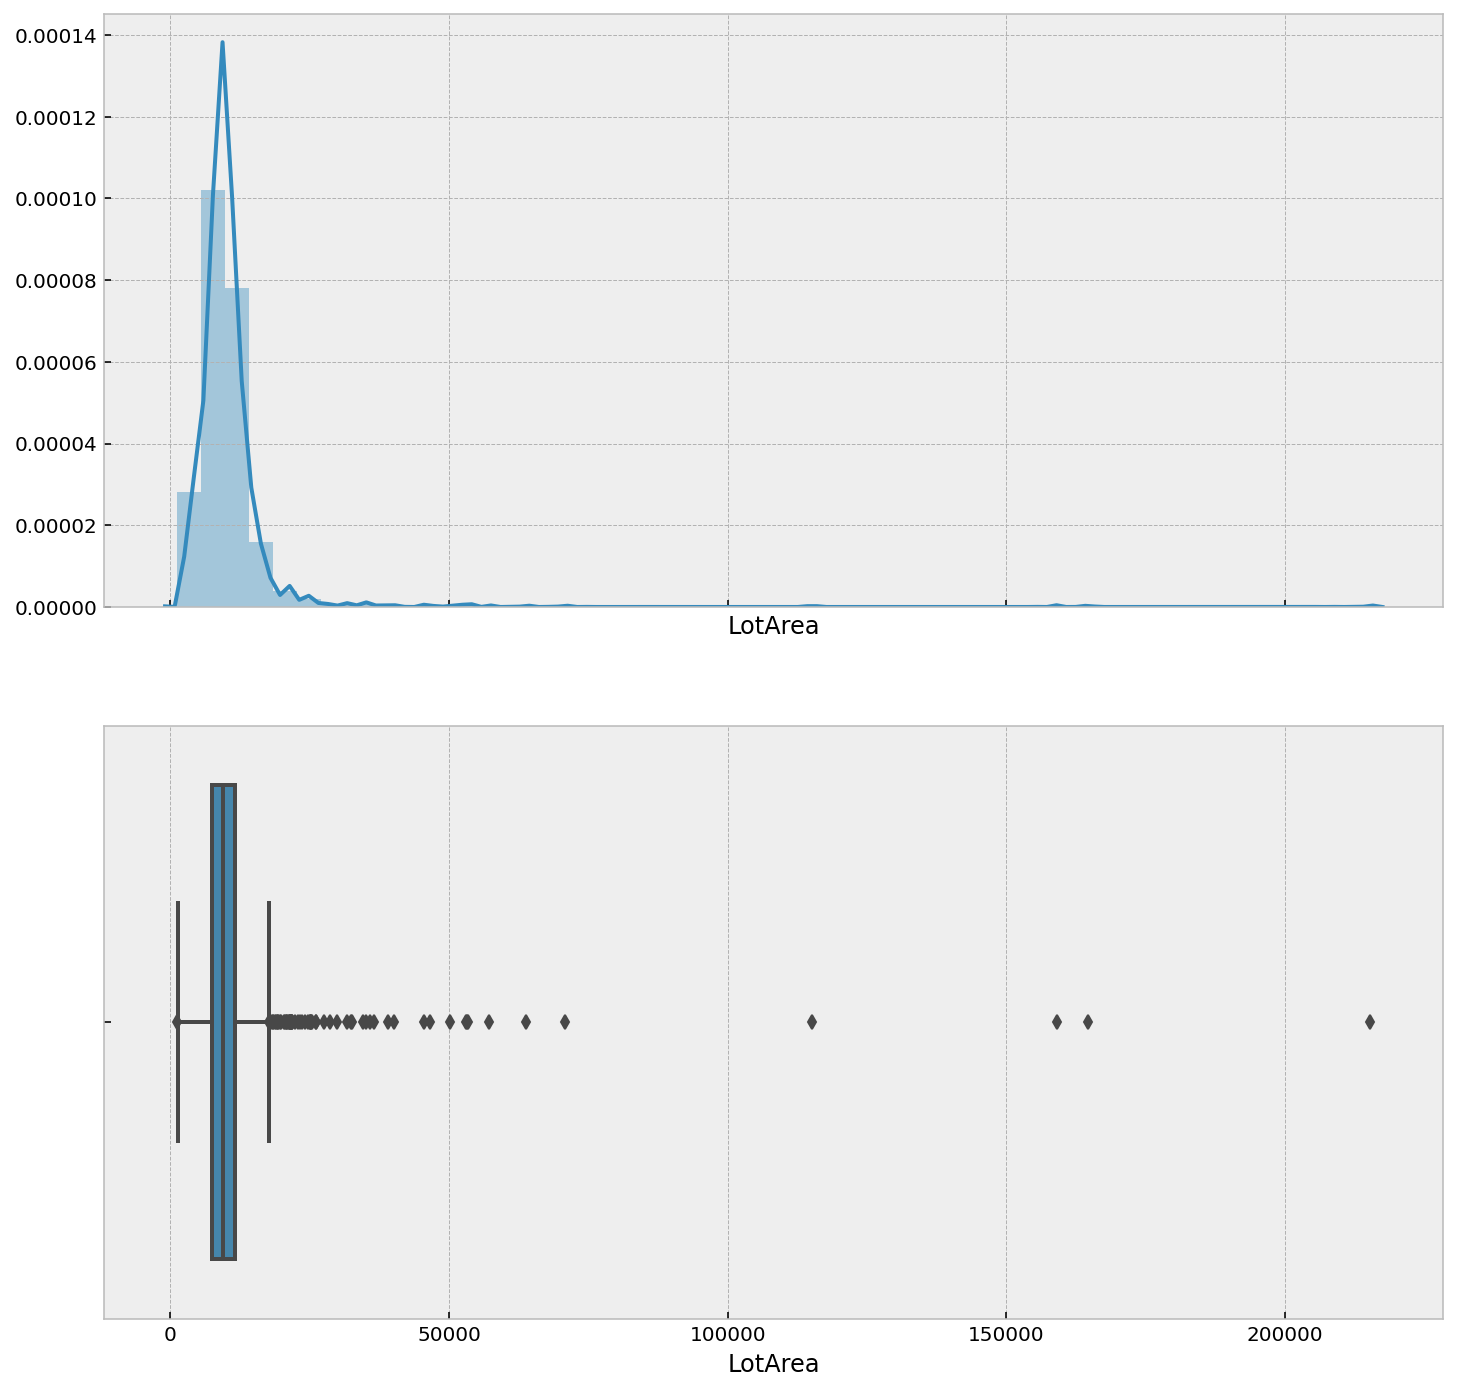

In [27]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2, sharex=True)

sns.distplot(residential['LotArea'], ax=ax[0])
sns.boxplot(residential['LotArea'], ax=ax[1]);

In [28]:
area_mean = residential.describe().loc['mean','LotArea']
area_std = residential.describe().loc['std','LotArea']

print('2std above mean : ', area_mean + (2*area_std))
print('3std above mean : ', area_mean + (3*area_std))
residential[residential['LotArea']>= area_mean + (3*area_std)]

2std above mean :  30548.202433541846
3std above mean :  40560.38778824381


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
53      54          20       RL         68.0    50271   Pave   NaN      IR1   
249    250          50       RL          NaN   159000   Pave   NaN      IR2   
313    314          20       RL        150.0   215245   Pave   NaN      IR3   
335    336         190       RL          NaN   164660   Grvl   NaN      IR1   
384    385          60       RL          NaN    53107   Pave   NaN      IR2   
451    452          20       RL         62.0    70761   Pave   NaN      IR1   
457    458          20       RL          NaN    53227   Pave   NaN      IR1   
661    662          60       RL         52.0    46589   Pave   NaN      IR2   
706    707          20       RL          NaN   115149   Pave   NaN      IR2   
769    770          60       RL         47.0    53504   Pave   NaN      IR2   
848    849          50       RL         75.0    45600   Pave   NaN      IR2   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   
1396  1397          20       RL          NaN    57200   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
53           Low    AllPub    Inside       Gtl      Veenker       Norm   
249          Low    AllPub   CulDSac       Sev      ClearCr       Norm   
313          Low    AllPub    Inside       Sev       Timber       Norm   
335          HLS    AllPub    Corner       Sev       Timber       Norm   
384          Low    AllPub    Corner       Mod      ClearCr      Feedr   
451          Low    AllPub    Inside       Mod      ClearCr       Norm   
457          Low    AllPub   CulDSac       Mod      ClearCr       Norm   
661          Lvl    AllPub   CulDSac       Gtl      NoRidge       Norm   
706          Low    AllPub   CulDSac       Sev      ClearCr       Norm   
769          HLS    AllPub   CulDSac       Mod      StoneBr       Norm   
848          Bnk    AllPub    Inside       Gtl      ClearCr       Norm   
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   
1396         Bnk    AllPub    Inside       Sev       Timber       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
53         Norm     1Fam     1Story            9            5       1981   
249        Norm     1Fam     1.5Fin            6            7       1958   
313        Norm     1Fam     1Story            7            5       1965   
335        Norm   2fmCon     1.5Fin            5            6       1965   
384        Norm     1Fam     2Story            6            5       1992   
451        Norm     1Fam     1Story            7            5       1975   
457        Norm     1Fam     1Story            4            6       1954   
661        Norm     1Fam     2Story            8            7       1994   
706        Norm     1Fam     1Story            7            5       1971   
769        Norm     1Fam     2Story            8            5       2003   
848        Norm     1Fam     1.5Fin            6            8       1908   
1298       Norm     1Fam     2Story           10            5       2008   
1396       Norm     1Fam     1Story            5            5       1948   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
53            1987     Gable  WdShngl     WdShing     Wd Shng       None   
249           2006     Gable  CompShg     Wd Sdng     HdBoard     BrkCmn   
313           1965       Hip  CompShg     BrkFace     BrkFace       None   
335           1965     Gable  CompShg     Plywood     Plywood       None   
384           1992     Gable  CompShg     HdBoard     HdBoard       None   
451           1975     Gable  WdShngl     Plywood     Plywood       None   
457           1994      Flat  Tar&Grv     Plywood     Plywood       None   
661           2005       Hip  CompShg     VinylSd     VinylSd    BrkFace   
706           2002     Gable  CompShg     Plywood     Plywood      Stone   
769           2003       Hip  CompShg  

We will be removing these indecies 3 standard deviations above the mean from the modelling, and also while considering what to do with the LotFrontage variable.

NB: we have a few LotFrontage null values in the largest LotArea properties, this reinforces the idea that it may be just missing and not a 0 value.

In [29]:
area_outliers = [i for i in 
                 residential[residential['LotArea']>= area_mean + (3*area_std)].index]

Lets have a closer look at the relationship between LotFrontage and LotArea before making a decision.

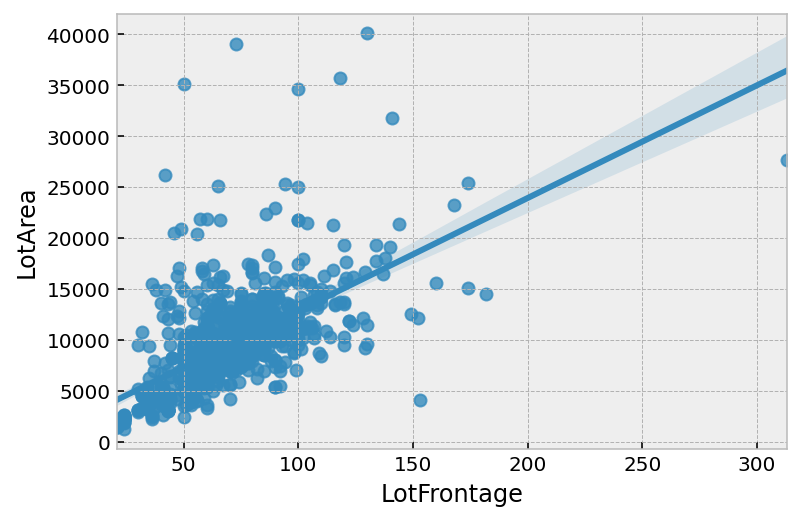

In [30]:
sns.regplot(x=residential[residential['LotArea']<40560]['LotFrontage'],
            y=residential[residential['LotArea']<40560]['LotArea']);

From this we can see a pretty strong relationship between the two variables and for the sake of keeping the LotFrontage variable in the modelling I will be imputing the LotFrontage null values using a mean of both LotArea and LotFrontage.

In [31]:
# Lot Frontage values
lot_mean_trouble = [i for i in residential[(residential['LotFrontage'].isnull())].index]
lot_frontage_replace = residential.drop(lot_mean_trouble+area_outliers, axis=0)
fill_percentage_lot = lot_frontage_replace['LotFrontage'].mean()/lot_frontage_replace['LotArea'].mean()

print('We will assign the variable : ', fill_percentage_lot)

residential.LotFrontage.fillna(residential['LotArea']*fill_percentage_lot, inplace=True)

We will assign the variable :  0.007308383254708641


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Garage Variables :-

In [32]:
[i for i in residential.columns if "Garage" in i]

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

Only GarageArea and GarageCars have no null values and they are essentially measuring the same thing. Lets have a closer look

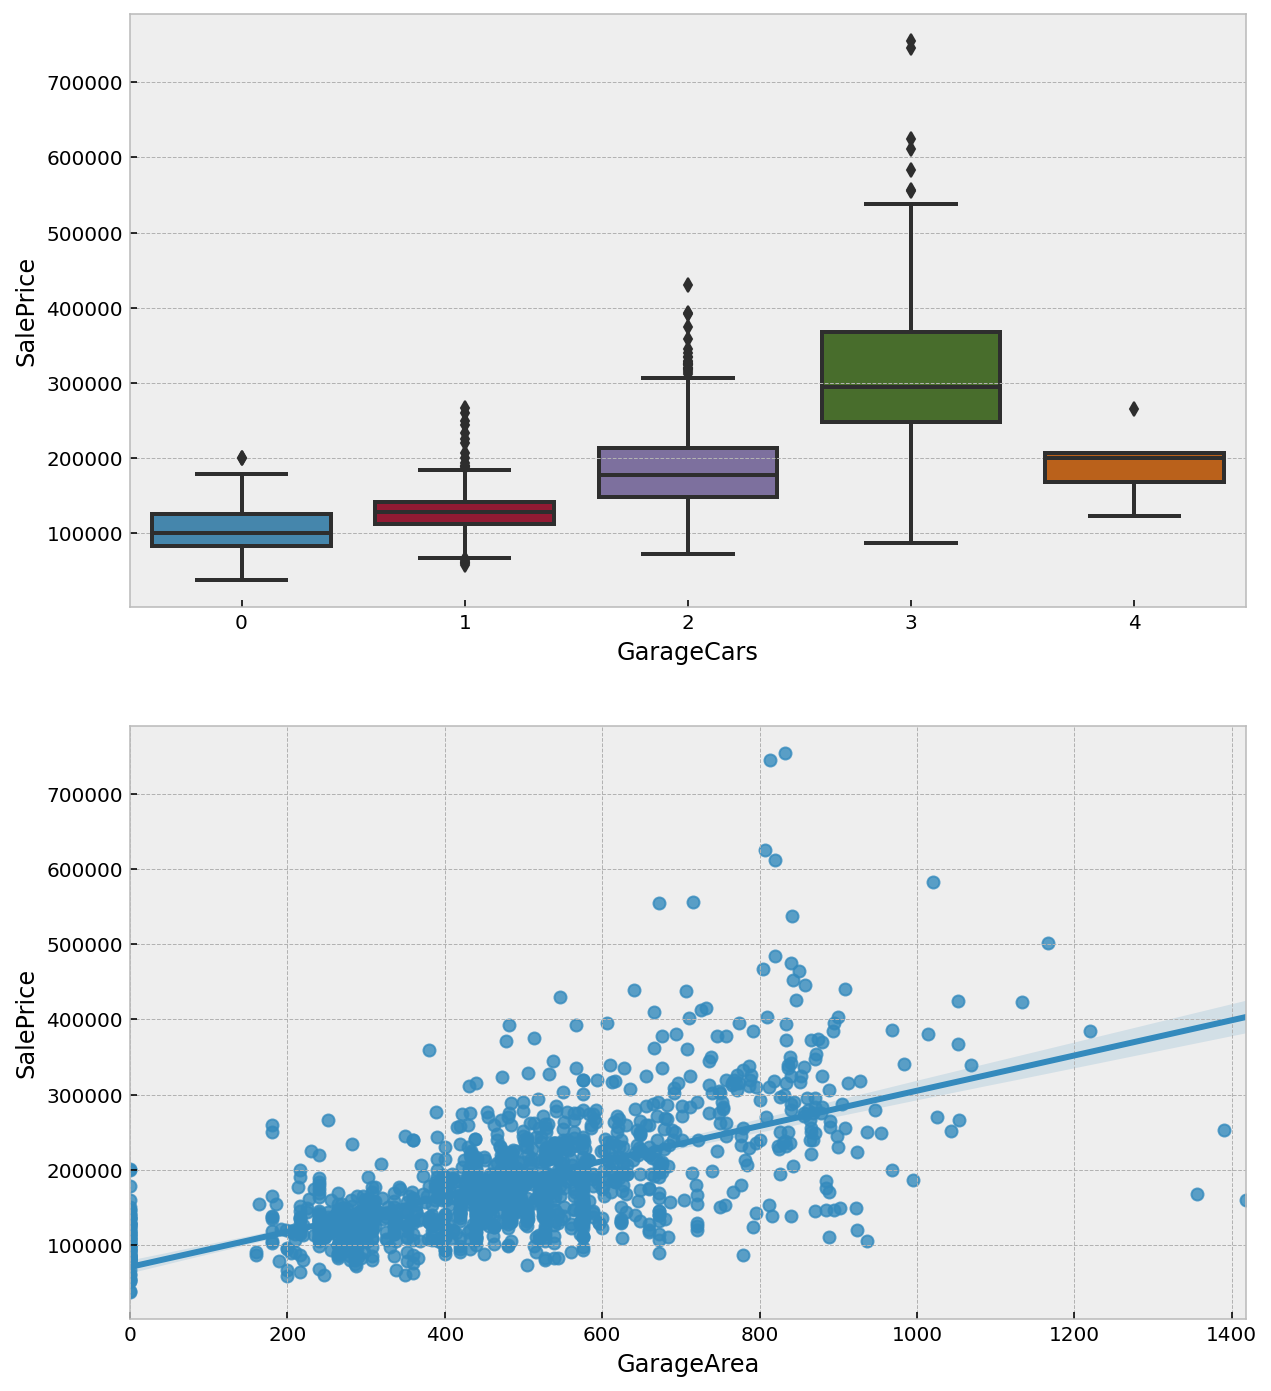

Garage Cars : 
 2    821
1    365
3    180
0     79
4      5
Name: GarageCars, dtype: int64


In [33]:
fig, ax = plt.subplots(figsize=(10,12), nrows=2)
sns.boxplot(x=residential['GarageCars'], y=residential['SalePrice'], ax=ax[0])
sns.regplot(x=residential['GarageArea'], y=residential['SalePrice'], ax=ax[1])
plt.show()
print('Garage Cars : \n', residential['GarageCars'].value_counts())

Considering the lower SalePrice for a 4 car garage then a 3 car garage and the small amount of properties with the larger garage, there are 2 options, first we drop the 5 properties from our modelling or we remove the GarageCars variable.

In this instance we will remove the GarageCars variable entirely. As well as adding a Has_Garage binary variable.

In [34]:
columns_to_be_removed += ['GarageCars']
columns_to_be_removed

['PoolQC', 'PoolArea', 'MiscFeature', 'Alley', 'GarageCars']

In [35]:
residential.insert(loc = 58, column='Has_Garage',
                   value=[0 if i==0 else 1 for i in residential['GarageCars']])

Now to look at the null values in the remaining Garage columns. I expect them to be related to the fact they dont have a Garage. 

We should definitely not be removing these properties due to the lack of a garage.

In [36]:
# Confirming all null values correspond with not having a garage
residential[(residential['GarageCond'].isnull())&
            (residential['GarageYrBlt'].isnull())&
            (residential['GarageType'].isnull())&
            (residential['GarageQual'].isnull())&
            (residential['GarageFinish'].isnull())&
            (residential['Has_Garage']==0)
           ].shape

(79, 83)

Because the null values in GarageYrBlt will make the variable unusable in its current format, I will seperate the variable into groups around the 10 year mark and dummify for the modelling

In [37]:
residential.GarageYrBlt = residential['GarageYrBlt'].map(lambda x: 
                                                      str(round((x),-1))[:-2])

/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


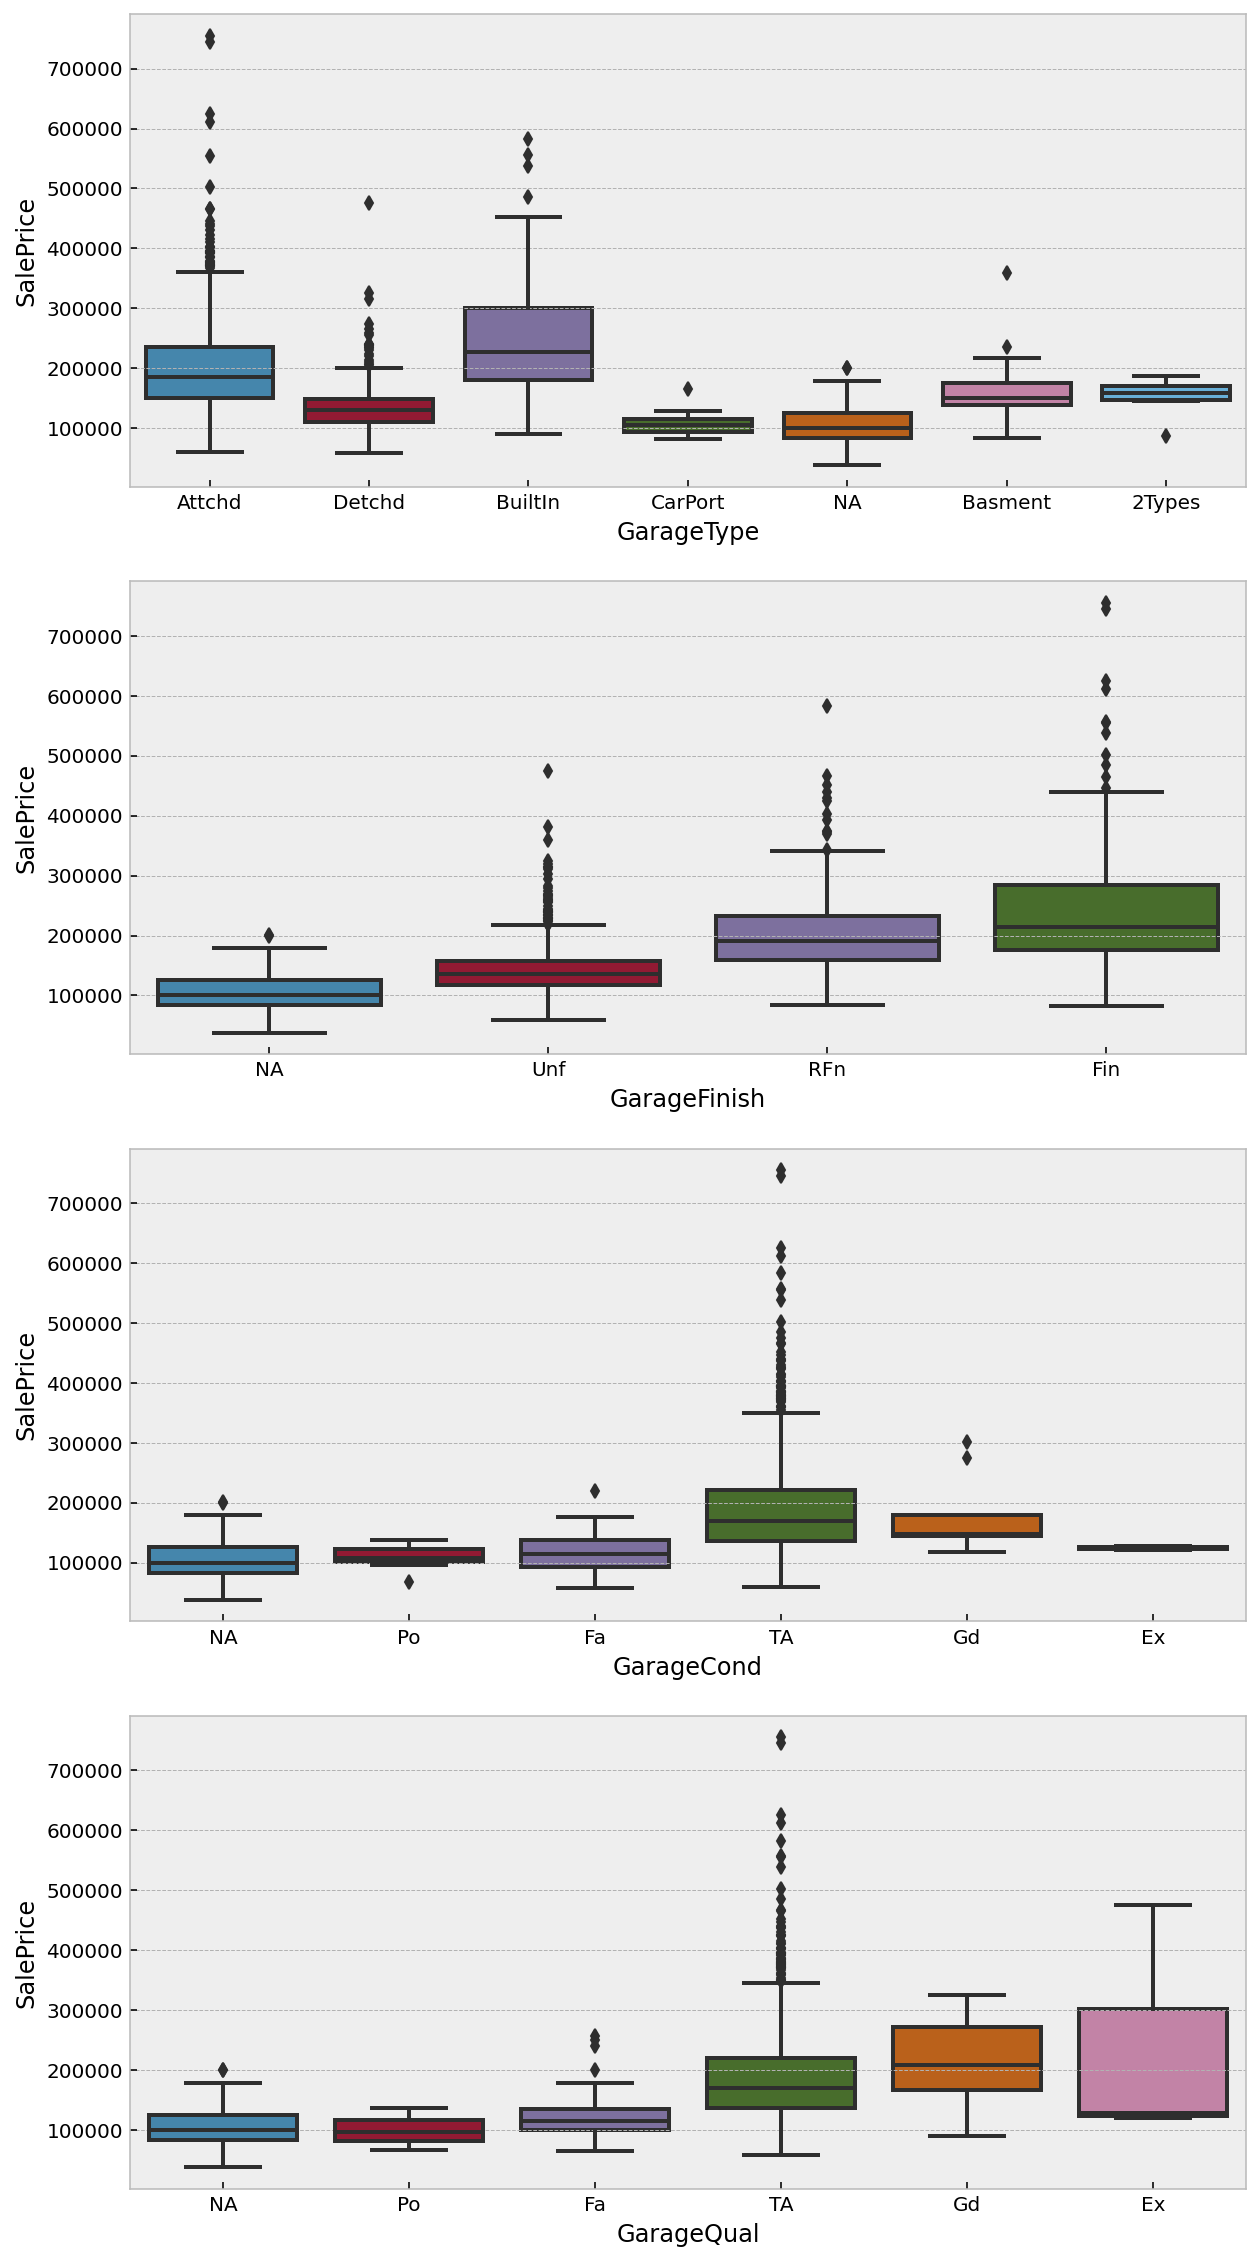

In [38]:
fig, ax = plt.subplots(figsize=(10,20), nrows=4)
sns.boxplot(x=residential['GarageType'].fillna('NA'),
            y=residential['SalePrice'], ax=ax[0])
sns.boxplot(x=residential['GarageFinish'].fillna('NA'),
            y=residential['SalePrice'], ax=ax[1],
            order=['NA', 'Unf', 'RFn', 'Fin'])
sns.boxplot(x=residential['GarageCond'].fillna('NA'),
            y=residential['SalePrice'], ax=ax[2],
            order=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
sns.boxplot(x=residential['GarageQual'].fillna('NA'),
            y=residential['SalePrice'], ax=ax[3],
            order=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
plt.show()

We will use the GarageType variable in the modelling as each type does seem to have a different associated value.

Lets look a little closer at the quality variables.

In [39]:
residential['GarageType'].fillna('NA', inplace=True)

/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [40]:
print(residential['GarageCond'].fillna('NA').value_counts())
print(residential['GarageQual'].fillna('NA').value_counts())
print(residential['GarageFinish'].fillna('NA').value_counts())

TA    1319
NA      79
Fa      34
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64
TA    1303
NA      79
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
Unf    600
RFn    419
Fin    352
NA      79
Name: GarageFinish, dtype: int64


Because of the large concentration of the values for both the GarageCond and GarageQual scoring 'TA'(Typical/Average), I will be dropping both from the modelling. We will however be using the GarageFinish variable in the second part of the exercise

In [41]:
columns_to_be_removed += ['GarageQual', 'GarageCond']

### Basement Variables :-

In [42]:
[i for i in residential.columns if "Bsmt" in i]

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

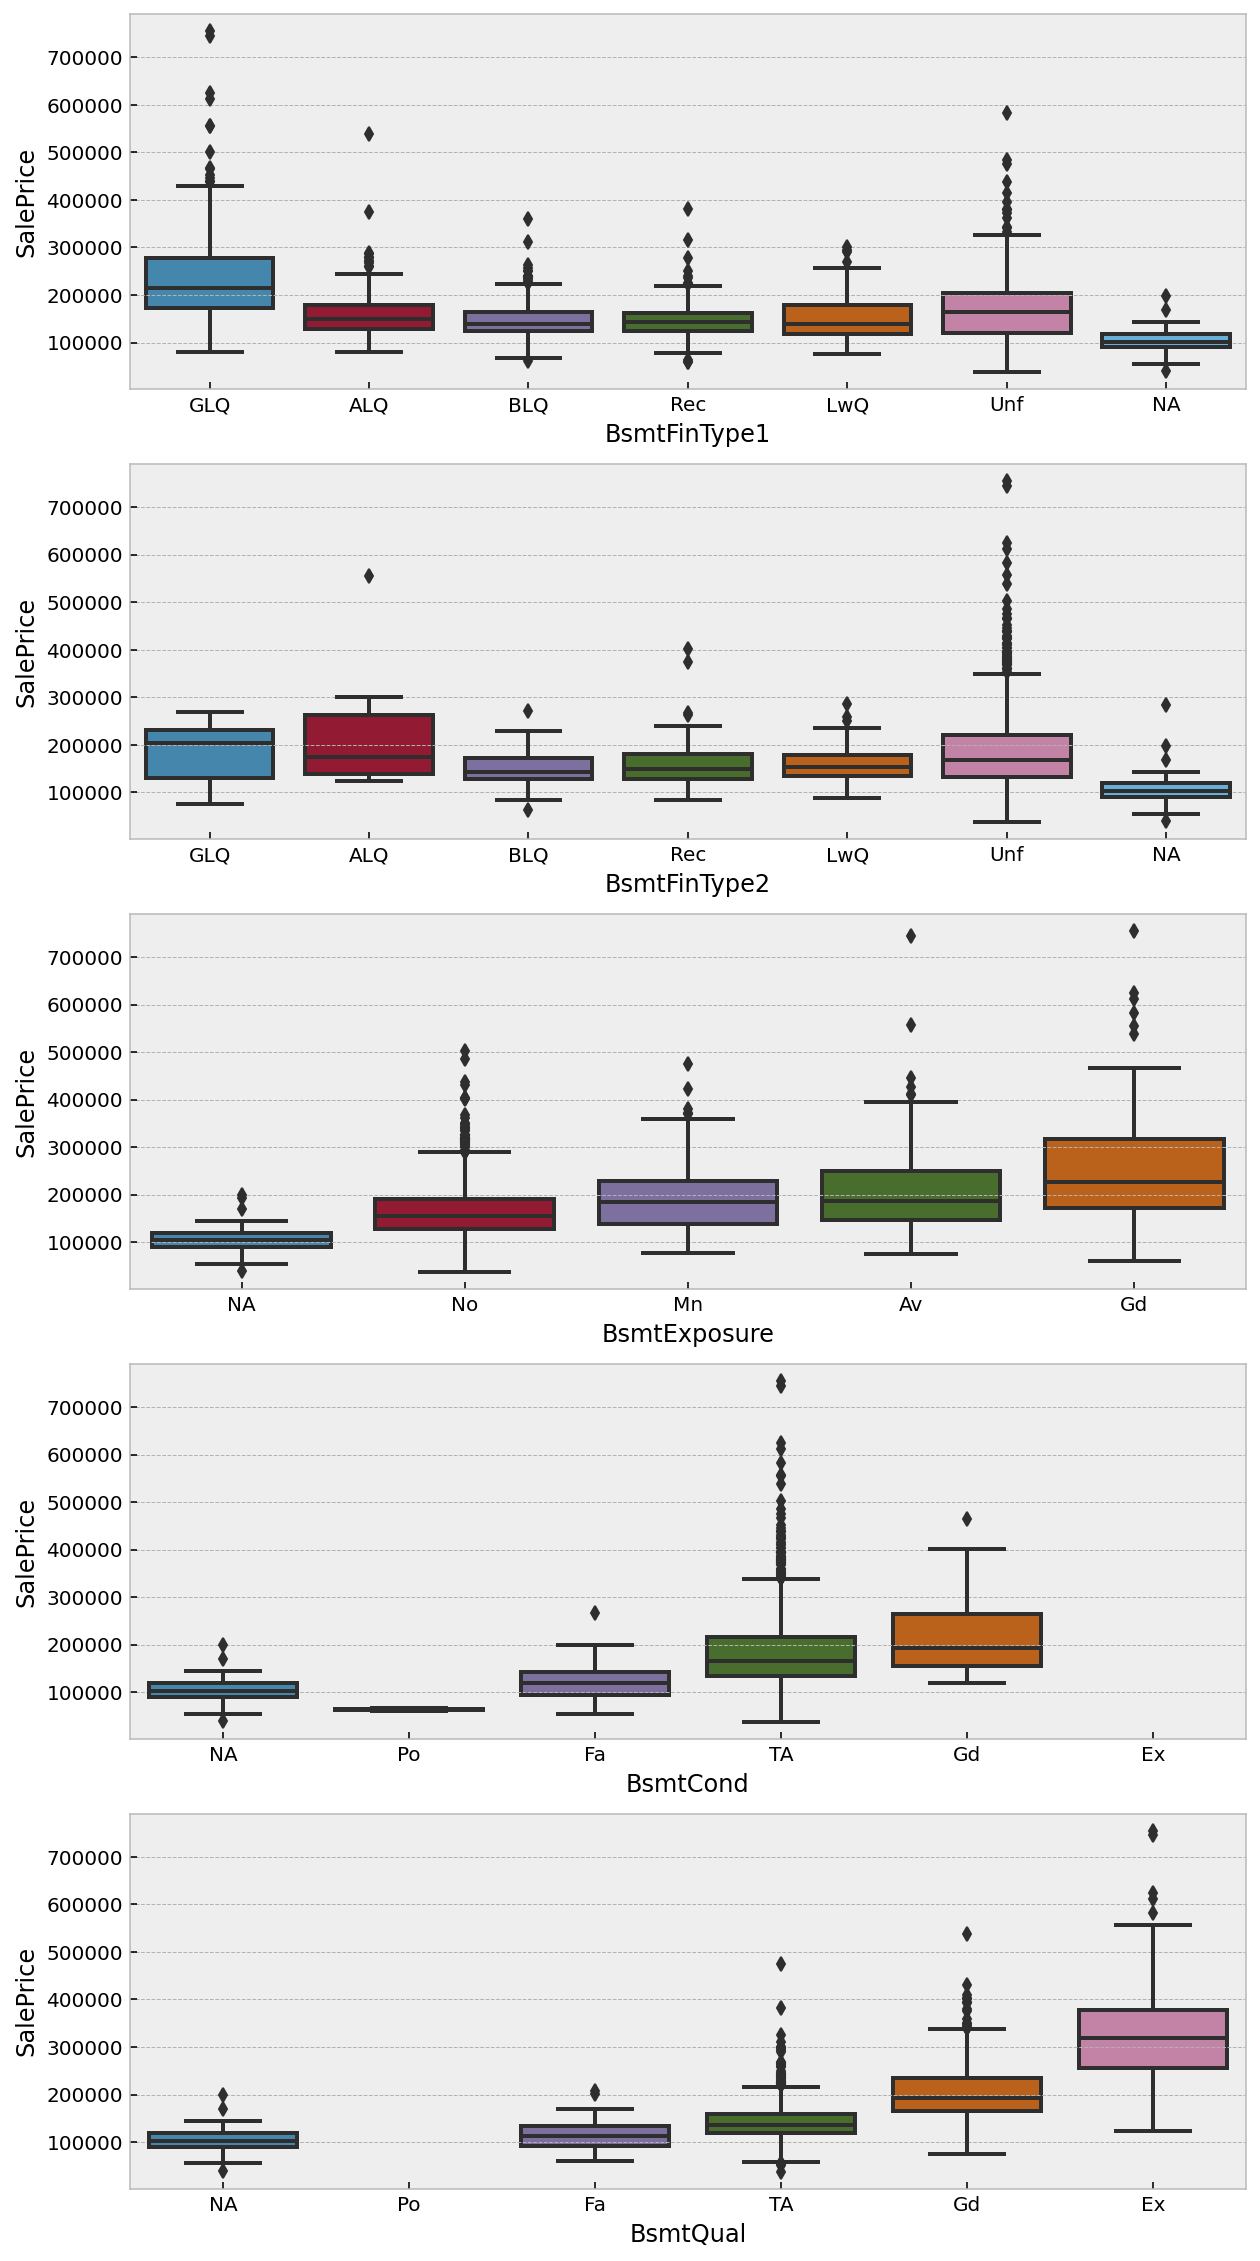

In [43]:
fig, ax = plt.subplots(figsize=(10,20), nrows=5)
sns.boxplot(x=residential['BsmtFinType1'].fillna(value='NA'),
            y=residential['SalePrice'], ax=ax[0],
            order=['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'])
sns.boxplot(x=residential['BsmtFinType2'].fillna('NA'),
            y=residential['SalePrice'], ax=ax[1],
            order=['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA'])
sns.boxplot(x=residential['BsmtExposure'].fillna('NA'),
            y=residential['SalePrice'], ax=ax[2],
            order=['NA', 'No', 'Mn', 'Av', 'Gd'])
sns.boxplot(x=residential['BsmtCond'].fillna(value='NA'),
            y=residential['SalePrice'], ax=ax[3],
            order=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
sns.boxplot(x=residential['BsmtQual'].fillna(value='NA'),
            y=residential['SalePrice'], ax=ax[4],
            order=['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
plt.show()

In [44]:
residential[(residential['BsmtFinType1']=='Unf')&(residential['BsmtFinType2']=='Unf')]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
13      14          20       RL         91.0    10652   Pave   NaN      IR1   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   
20      21          60       RL        101.0    14215   Pave   NaN      IR1   
21      22          45       RM         57.0     7449   Pave  Grvl      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1448  1449          50       RL         70.0    11767   Pave   NaN      Reg   
1450  1451          90       RL         60.0     9000   Pave   NaN      Reg   
1451  1452          20       RL         78.0     9262   Pave   NaN      Reg   
1453  1454          20       RL         90.0    17217   Pave   NaN      Reg   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
8            Lvl    AllPub    Inside       Gtl      OldTown     Artery   
13           Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
15           Lvl    AllPub    Corner       Gtl      BrkSide       Norm   
20           Lvl    AllPub    Corner       Gtl      NridgHt       Norm   
21           Bnk    AllPub    Inside       Gtl       IDOTRR       Norm   
...          ...       ...       ...       ...          ...        ...   
1448         Lvl    AllPub    Inside       Gtl      Edwards       Norm   
1450         Lvl    AllPub       FR2       Gtl        NAmes       Norm   
1451         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
1453         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
8          Norm     1Fam     1.5Fin            7            5       1931   
13         Norm     1Fam     1Story            7            5       2006   
15         Norm     1Fam     1.5Unf            7            8       1929   
20         Norm     1Fam     2Story            8            5       2005   
21         Norm     1Fam     1.5Unf            7            7       1930   
...         ...      ...        ...          ...          ...        ...   
1448       Norm     1Fam     2Story            4            7       1910   
1450       Norm   Duplex     2Story            5            5       1974   
1451       Norm     1Fam     1Story            8            5       2008   
1453       Norm     1Fam     1Story            5            5       2006   
1455       Norm     1Fam     2Story            6            5       1999   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
8             1950     Gable  CompShg     BrkFace     Wd Shng       None   
13            2007     Gable  CompShg     VinylSd     VinylSd      Stone   
15            2001     Gable  CompShg     Wd Sdng     Wd Sdng       None   
20            2006     Gable  CompShg     VinylSd     VinylSd    BrkFace   
21            1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
...            ...       ...      ...         ...         ...        ...   
1448          2000     Gable  CompShg     MetalSd     HdBoard       None   
1450          1974     Gable  CompShg     VinylSd     VinylSd       None   
1451          2009     Gable  CompShg     CemntBd     CmentBd      Stone   
1453          2006     Gable  CompShg     VinylSd     VinylSd       None   
1455          2000     Gable  CompShg     VinylSd     VinylSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
8            0.0        TA        TA     BrkTil       TA       TA   
13         306.0        Gd        TA      PConc       Gd       TA   
15           0.0        TA        TA     BrkTil       TA       TA   
20         380.0        Gd        TA      PConc       Ex       TA   

In [45]:
print(residential['BsmtFinType1'].fillna('NA').value_counts())
print(residential['BsmtFinType2'].fillna('NA').value_counts())

Unf    424
GLQ    418
ALQ    220
BLQ    147
Rec    130
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64
Unf    1246
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


In [46]:
print(residential['BsmtCond'].fillna('NA').value_counts())
print(residential['BsmtQual'].fillna('NA').value_counts())

TA    1303
Gd      65
Fa      43
NA      37
Po       2
Name: BsmtCond, dtype: int64
TA    639
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64


We could remove the BsmntCondition variable but for the timebeing at least we will keep it and all other quality variables related to the basement and just fill in the null values.

In [47]:
residential['BsmtCond'].fillna('NA', inplace=True)
residential['BsmtQual'].fillna('NA', inplace=True)
residential['BsmtFinType1'].fillna('NA', inplace=True)
residential['BsmtFinType2'].fillna('NA', inplace=True)
residential['BsmtExposure'].fillna('NA', inplace=True)

/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Lets look at the basement bathroom values.

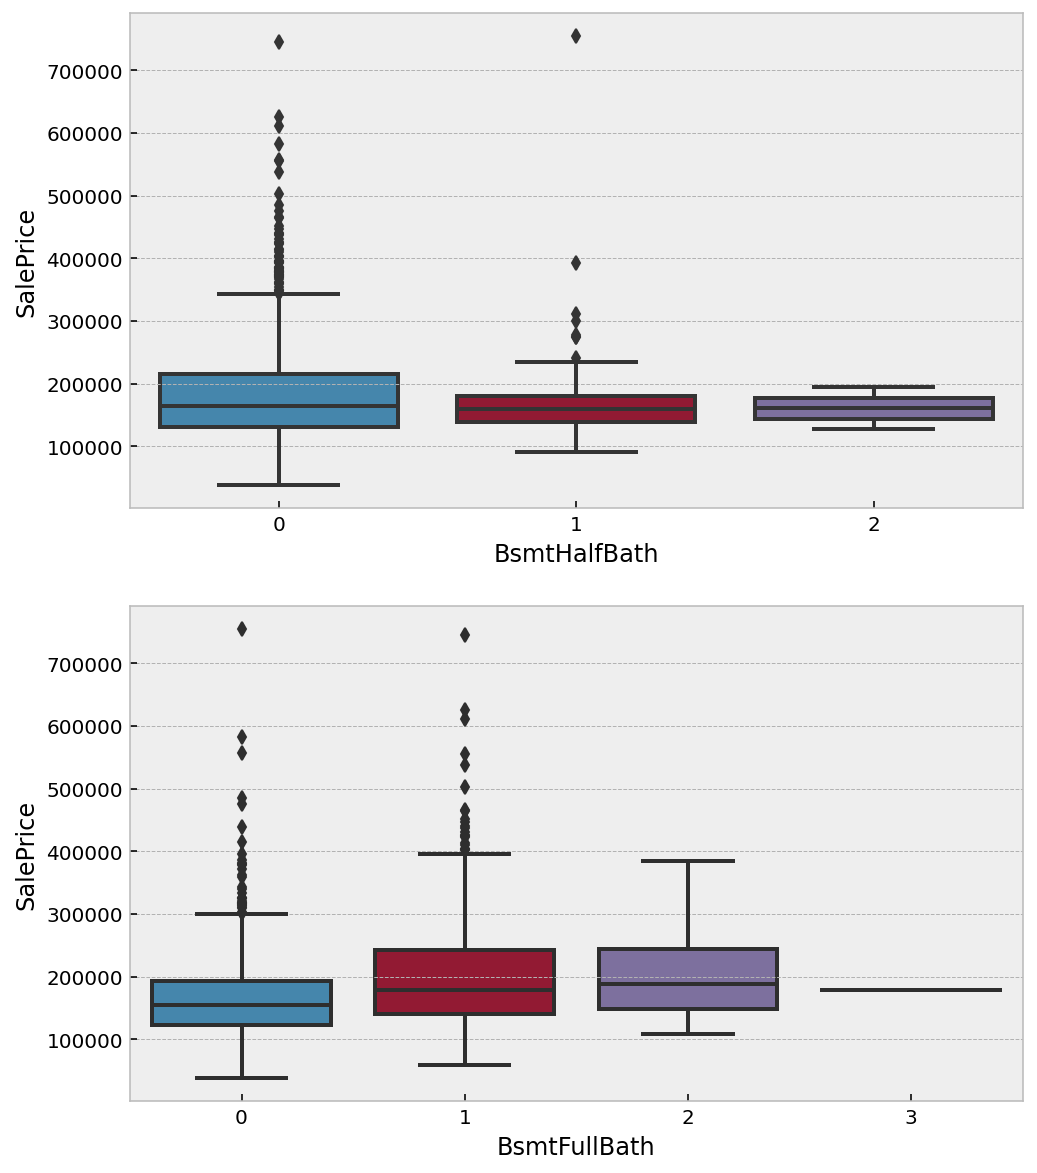

0    1369
1      79
2       2
Name: BsmtHalfBath, dtype: int64
0    847
1    587
2     15
3      1
Name: BsmtFullBath, dtype: int64


In [48]:
fig, ax = plt.subplots(figsize=(8,10), nrows=2)
sns.boxplot(x=residential['BsmtHalfBath'], y=residential['SalePrice'],
            ax=ax[0])
sns.boxplot(x=residential['BsmtFullBath'], y=residential['SalePrice'],
            ax=ax[1])
plt.show()
print(residential['BsmtHalfBath'].value_counts())
print(residential['BsmtFullBath'].value_counts())

There is little evidence that basemnet bathrooms has a massive effect on price we will therefore get rid of these variables and just keep the FullBath and HalfBath variables for the modelling.

In [49]:
columns_to_be_removed += ['BsmtHalfBath','BsmtFullBath']
columns_to_be_removed

['PoolQC',
 'PoolArea',
 'MiscFeature',
 'Alley',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'BsmtHalfBath',
 'BsmtFullBath']

Lets look at the square footage of the Basement's now.

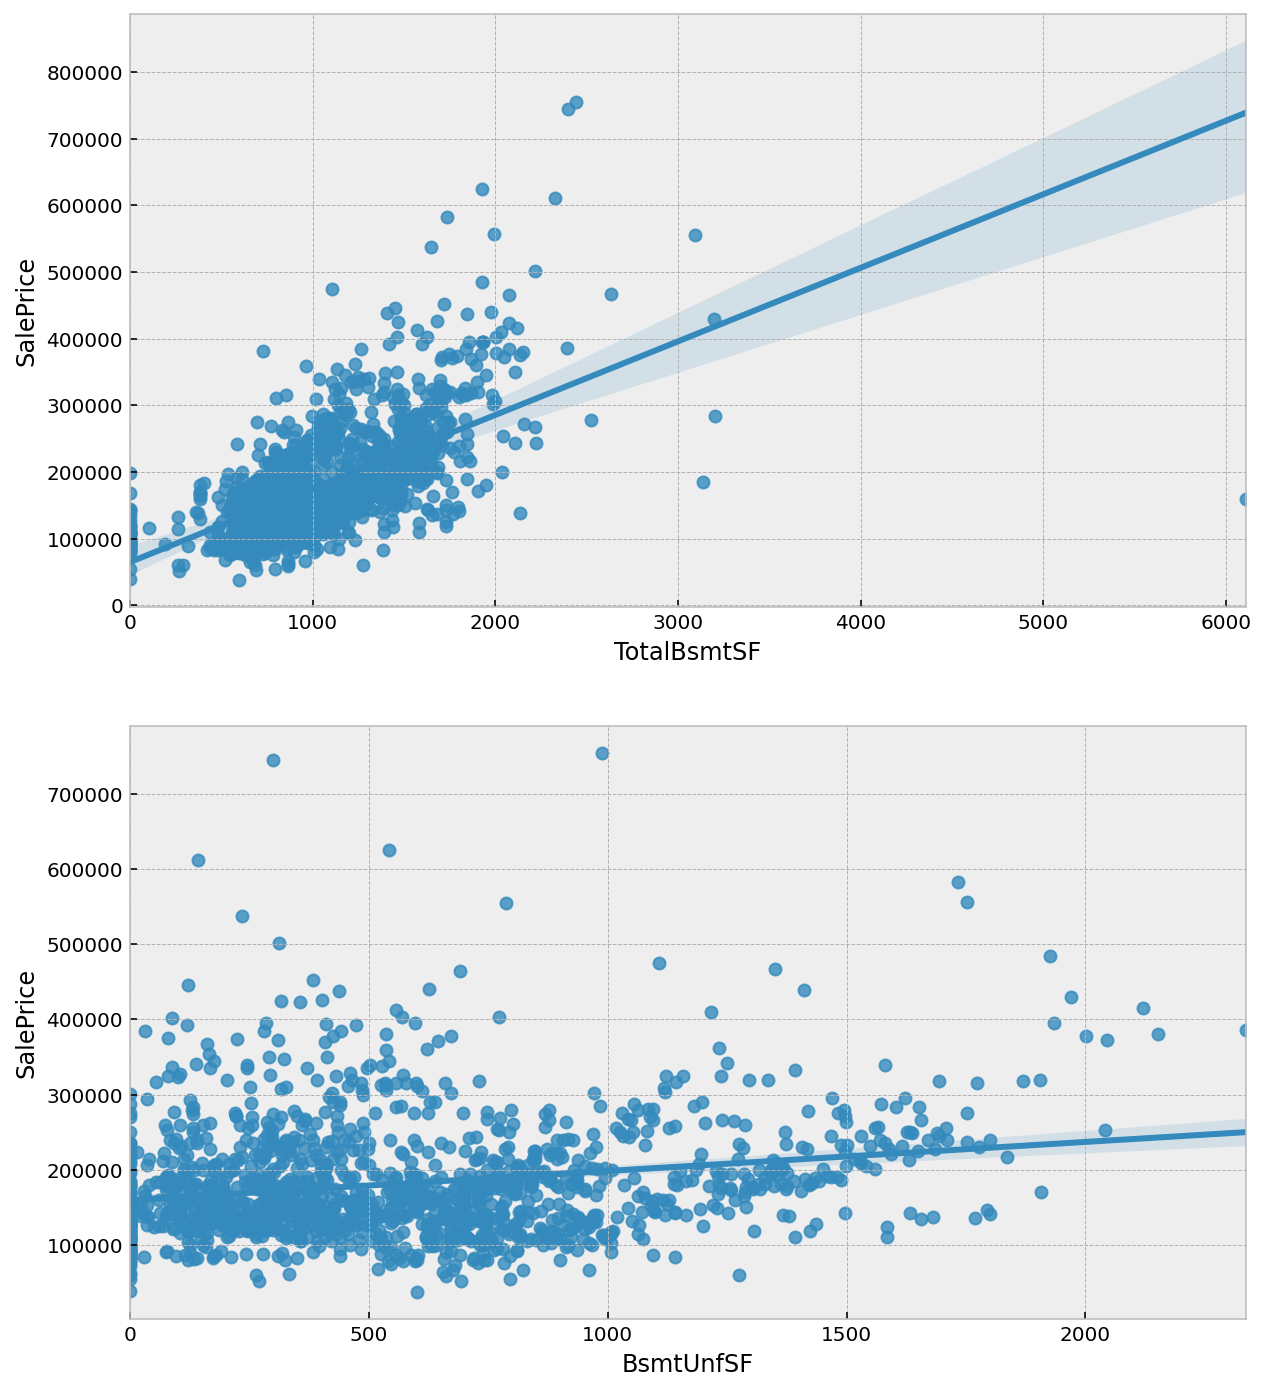

In [50]:
fig, ax = plt.subplots(figsize=(10,12), nrows=2)
sns.regplot(x=residential['TotalBsmtSF'], y=residential['SalePrice'],
                ax=ax[0])
sns.regplot(x=residential['BsmtUnfSF'], y=residential['SalePrice'],
                ax=ax[1])
plt.show()

We will be consolidating the square footage of each floor into a singular variable, and keep the BsmtUnfSF for the second part of the exercise. So no changes needed here immediately.

### MasVnrType and MasVnrArea :-

In [51]:
residential[(residential.MasVnrArea.isnull())][['MasVnrType','MasVnrArea']]

MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN

In [52]:
residential.MasVnrType.fillna('na').value_counts()

None       854
BrkFace    445
Stone      128
BrkCmn      15
na           8
Name: MasVnrType, dtype: int64

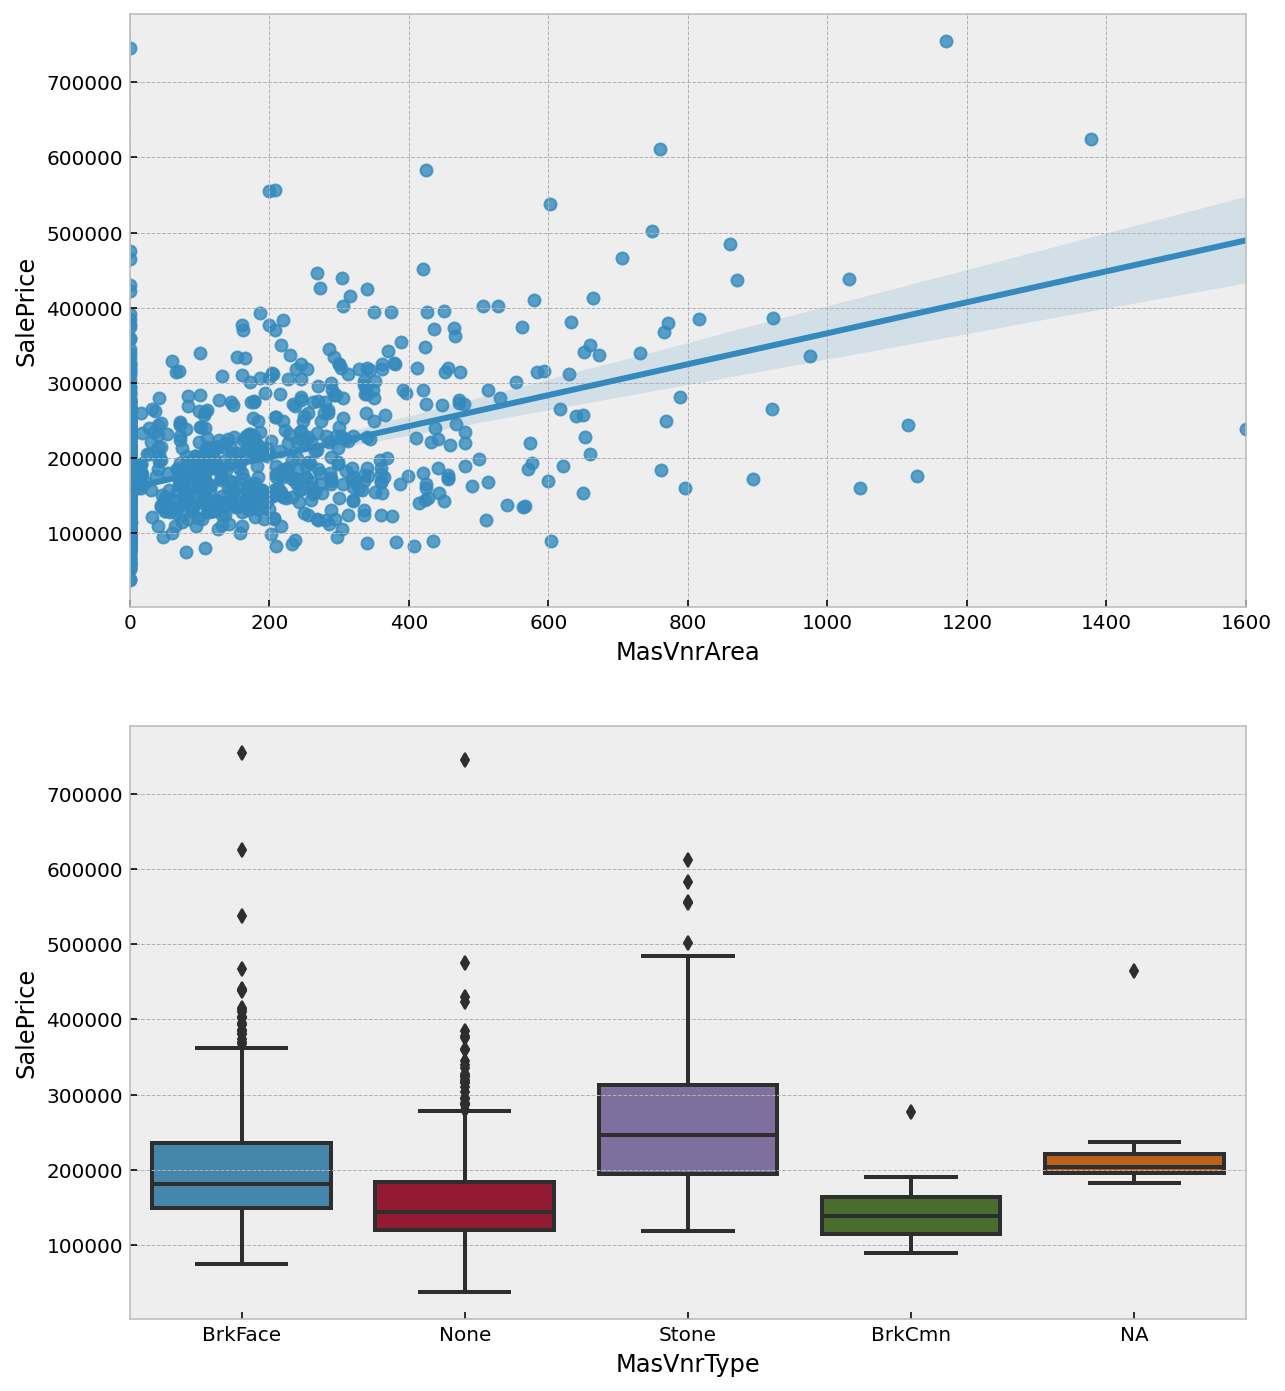

In [53]:
fig, ax = plt.subplots(figsize=(10,12), nrows=2)
sns.regplot(x=residential['MasVnrArea'].fillna(0), y=residential['SalePrice'],
                ax=ax[0])
sns.boxplot(x=residential['MasVnrType'].fillna('NA'), y=residential['SalePrice'],
                ax=ax[1])
plt.show()

Because it is a small part of our data and na does not necessarily mean none we will assume this is an error in recording the data. We cannot infer anything particular about the properties from this lack of data as it is not necessarily none, so I will remove the indicies from the modelling.

In [54]:
for i in residential[(residential.MasVnrArea.isnull())].index:
    index_to_be_removed.append(i)

In [55]:
# # Because these NaN's Match up with both MasVnrType and MasVnrArea
# # we put MasVnrArea as value 0 instead of np.nan

# residential.MasVnrArea.fillna(0, inplace=True)
# residential.MasVnrType.fillna('None', inplace=True)

### Electrical :-

In [56]:
residential['Electrical'].isnull().sum()

1

As there is only one null value here and we cannot infer anything else from the data we will drop this index from the modelling

In [57]:
for i in residential[residential['Electrical'].isnull()].index:
    index_to_be_removed.append(i)

## Feature Engineering & other EDA

First thing is to combine all the interior square footage into one variable, for simplification and also because I expect it to be more useful in judging price then each floor individually.

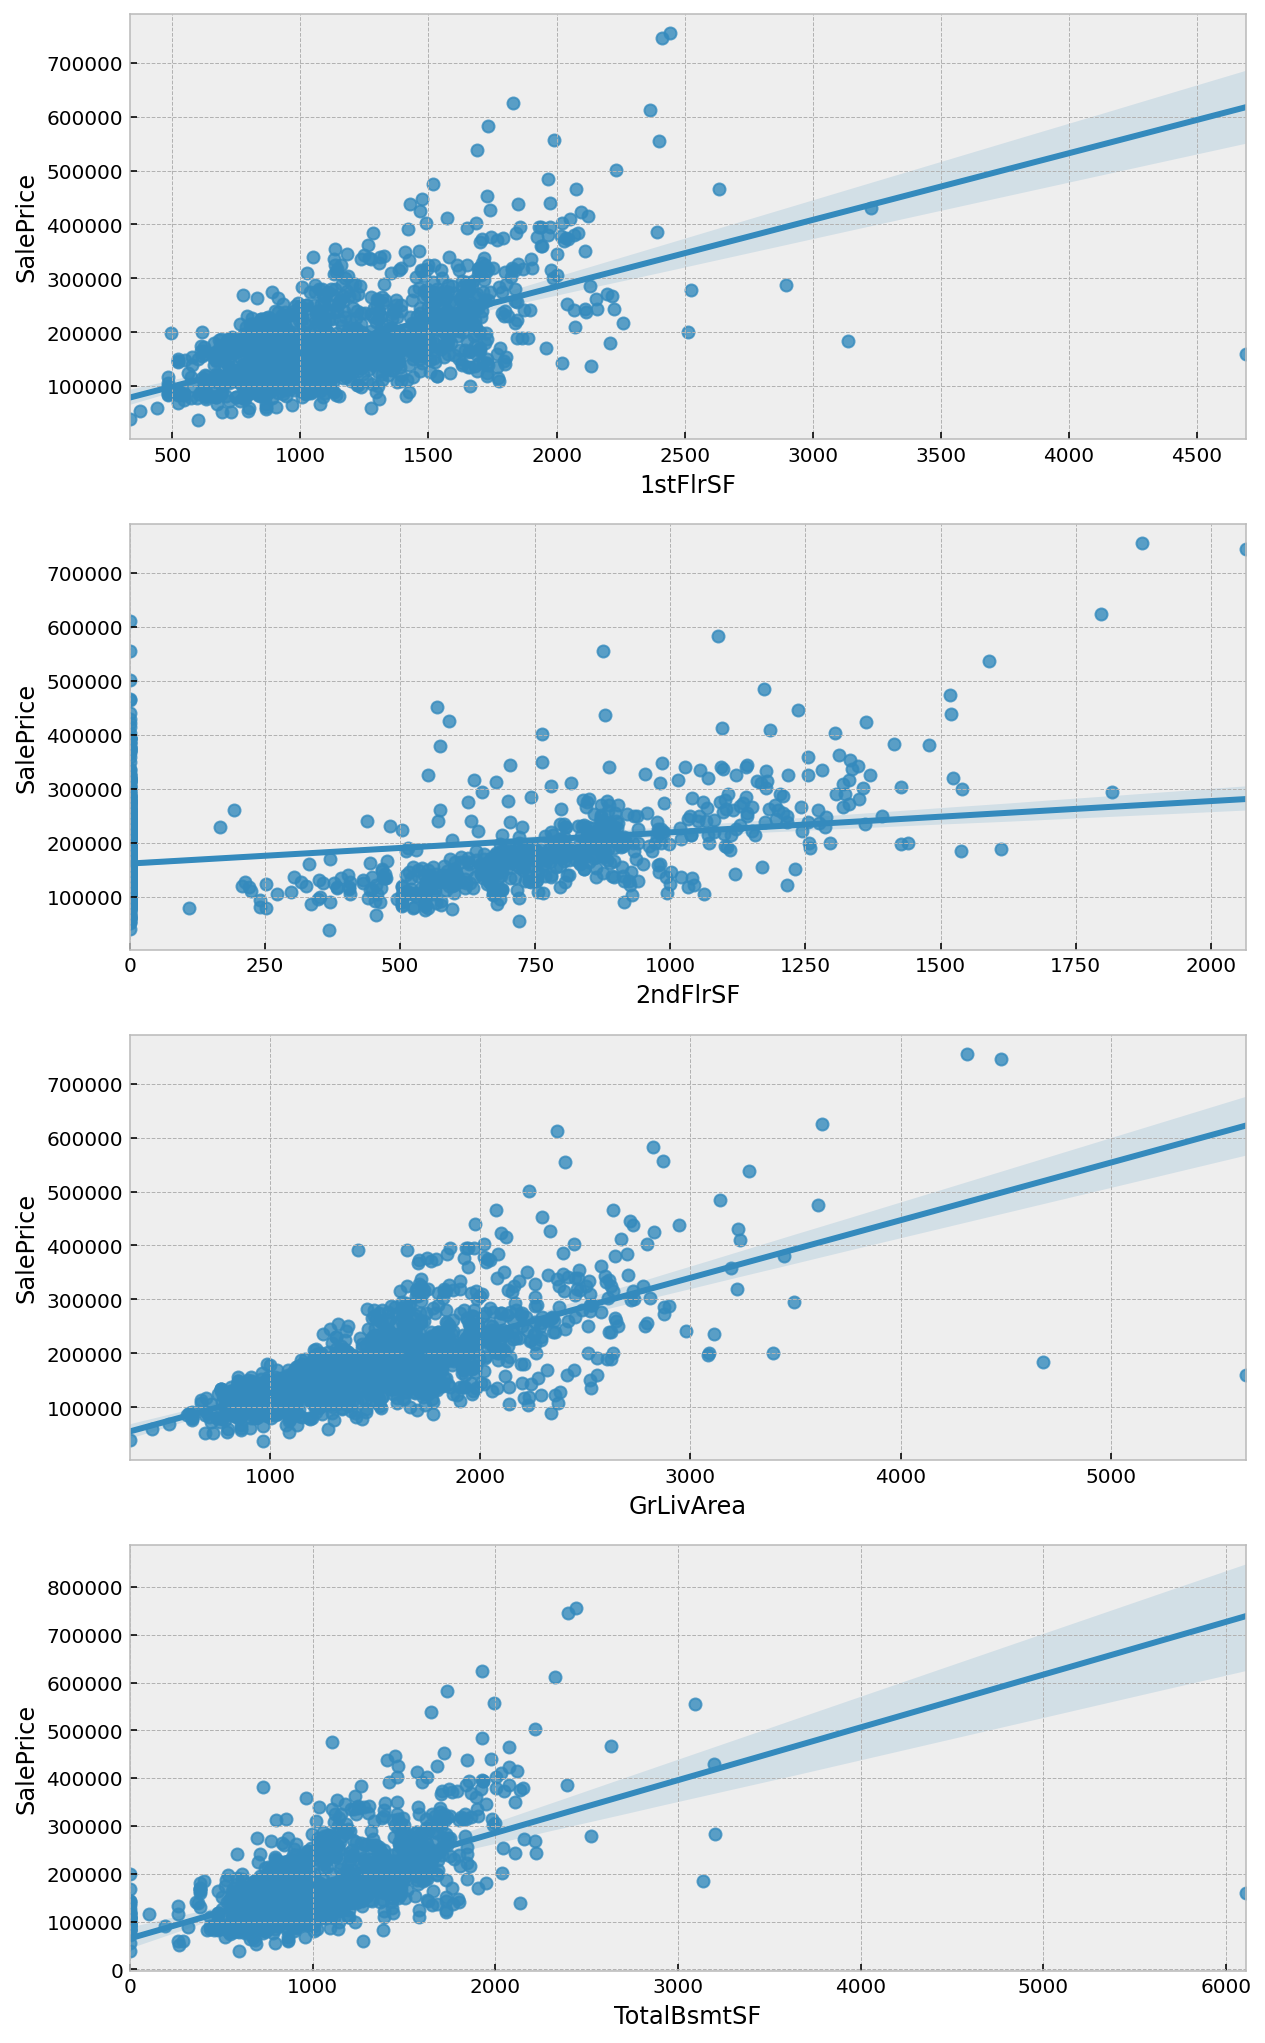

In [58]:
fig, ax = plt.subplots(figsize=(10,18), nrows=4)
sns.regplot(x=residential['1stFlrSF'], y=residential['SalePrice'], ax=ax[0])
sns.regplot(x=residential['2ndFlrSF'], y=residential['SalePrice'], ax=ax[1])
sns.regplot(x=residential['GrLivArea'], y=residential['SalePrice'], ax=ax[2])
sns.regplot(x=residential['TotalBsmtSF'], y=residential['SalePrice'], ax=ax[3])
plt.show()

As we can see particularly 2ndFlrSF does not have a particularly good correlation with property values due to the large amount of 0 values.

In [59]:
residential['TotalSF'] = residential['TotalBsmtSF']+residential['1stFlrSF']+residential['2ndFlrSF']+residential['GrLivArea']

<ipython-input-59-5b86e4f6a09b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residential['TotalSF'] = residential['TotalBsmtSF']+residential['1stFlrSF']+residential['2ndFlrSF']+residential['GrLivArea']


In [60]:
columns_to_be_removed += ['TotalBsmtSF', '1stFlrSF',
                          '2ndFlrSF', 'GrLivArea']
columns_to_be_removed

['PoolQC',
 'PoolArea',
 'MiscFeature',
 'Alley',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'BsmtHalfBath',
 'BsmtFullBath',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea']

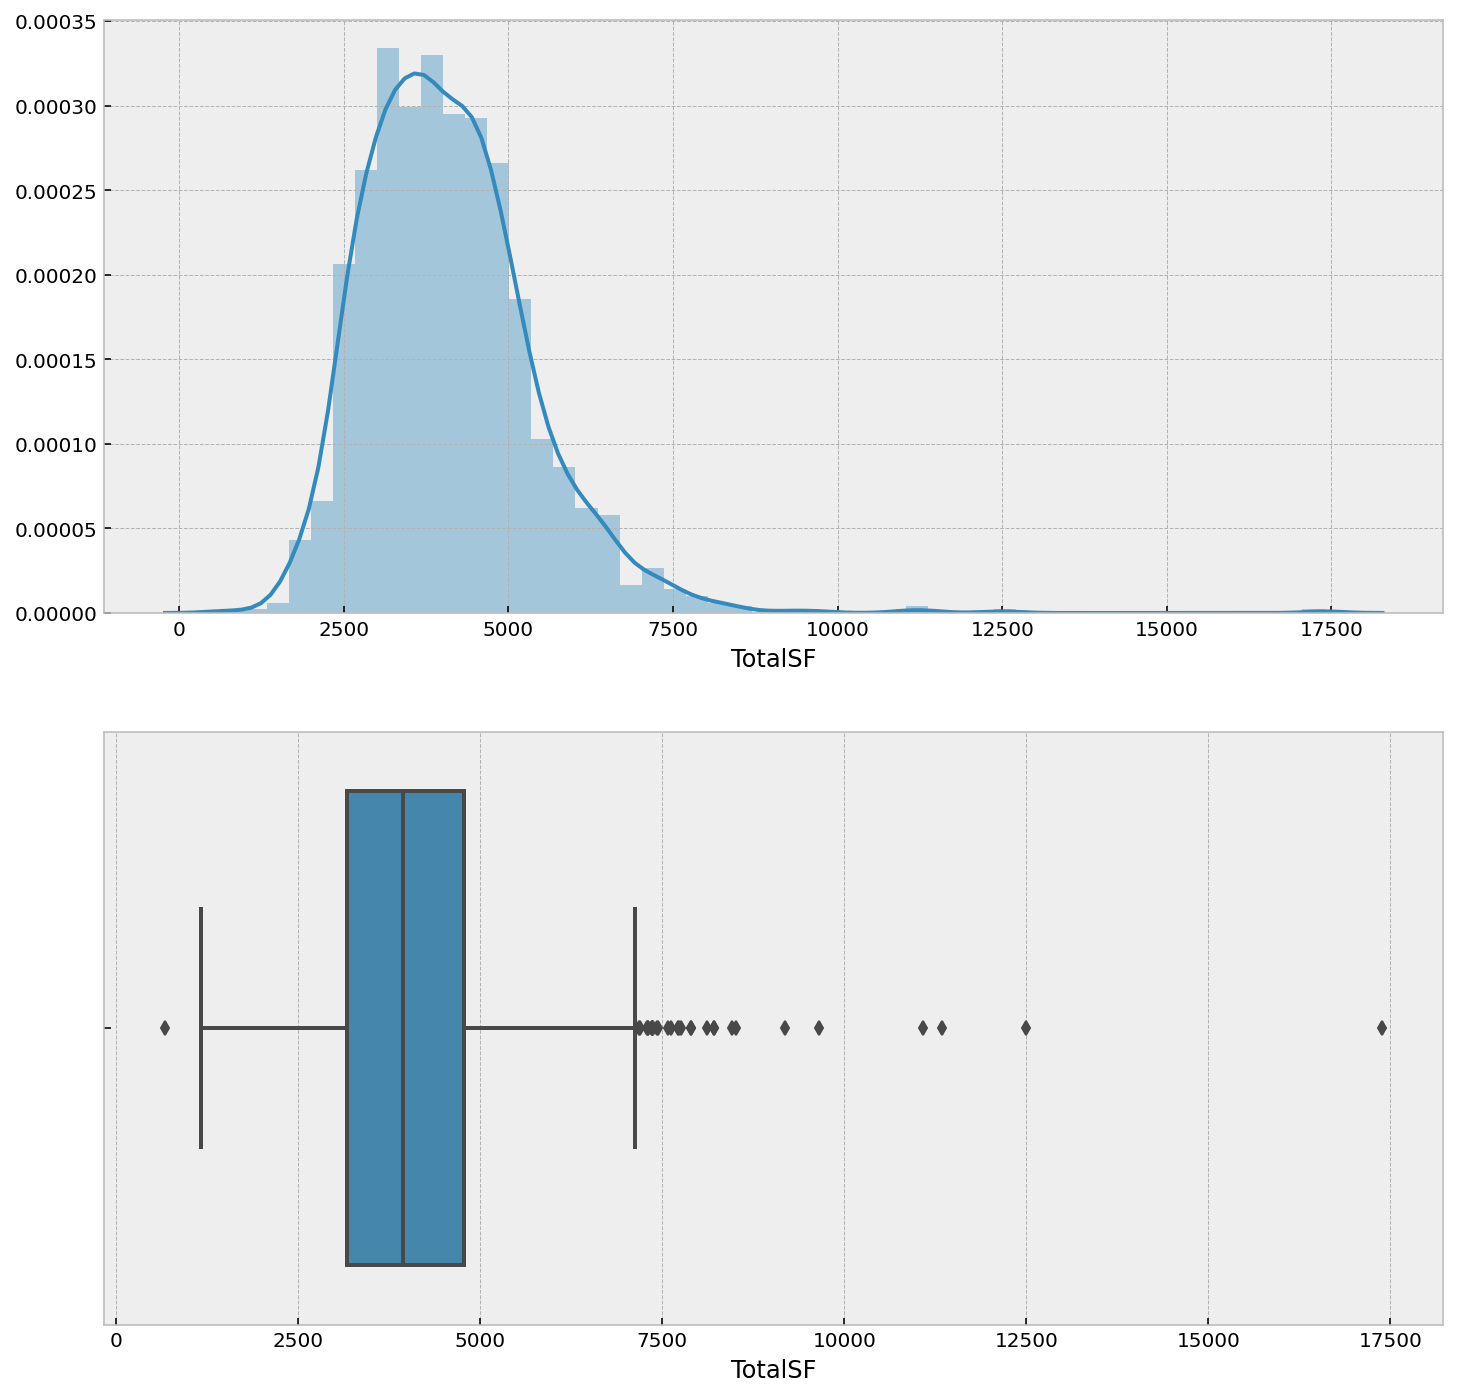

In [61]:
# Have a look at the target Variable
# A:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

sns.distplot(residential['TotalSF'], ax=ax[0])
sns.boxplot(residential['TotalSF'], ax=ax[1]);

In [62]:
sf_mean = residential.describe().loc['mean','TotalSF']
sf_std = residential.describe().loc['std','TotalSF']

print('2std above mean : ', sf_mean + (2*sf_std))
print('3std above mean : ', sf_mean + (3*sf_std))
residential[residential['TotalSF']>= sf_mean + (3*sf_std)]

2std above mean :  6699.652993289346
3std above mean :  8004.841903727123


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
118    119          60       RL       90.000    12376   Pave   NaN      Reg   
304    305          75       RM       87.000    18386   Pave   NaN      Reg   
496    497          20       RL       92.758    12692   Pave   NaN      IR1   
523    524          60       RL      130.000    40094   Pave   NaN      IR1   
691    692          60       RL      104.000    21535   Pave   NaN      IR1   
769    770          60       RL       47.000    53504   Pave   NaN      IR2   
798    799          60       RL      104.000    13518   Pave   NaN      Reg   
1169  1170          60       RL      118.000    35760   Pave   NaN      IR1   
1182  1183          60       RL      160.000    15623   Pave   NaN      IR1   
1298  1299          60       RL      313.000    63887   Pave   NaN      IR3   
1353  1354          50       RL       56.000    14720   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
118          Lvl    AllPub    Corner       Gtl      SawyerW       Norm   
304          Lvl    AllPub    Inside       Gtl      OldTown       Norm   
496          Lvl    AllPub    Inside       Gtl      NoRidge       Norm   
523          Bnk    AllPub    Inside       Gtl      Edwards       PosN   
691          Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
769          HLS    AllPub   CulDSac       Mod      StoneBr       Norm   
798          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
1169         Lvl    AllPub   CulDSac       Gtl      NoRidge       Norm   
1182         Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   
1353         Lvl    AllPub   CulDSac       Gtl      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
118        Norm     1Fam     2Story            7            5       1990   
304        Norm     1Fam     2.5Fin            7            9       1880   
496        Norm     1Fam     1Story            8            5       1992   
523        PosN     1Fam     2Story           10            5       2007   
691        Norm     1Fam     2Story           10            6       1994   
769        Norm     1Fam     2Story            8            5       2003   
798        Norm     1Fam     2Story            9            5       2008   
1169       Norm     1Fam     2Story           10            5       1995   
1182       Norm     1Fam     2Story           10            5       1996   
1298       Norm     1Fam     2Story           10            5       2008   
1353       Norm     1Fam     1.5Fin            8            5       1995   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
118           1990       Hip  CompShg     Plywood     Plywood       None   
304           2002     Gable  CompShg     CemntBd     CmentBd       None   
496           1993       Hip  CompShg     BrkFace     BrkFace       None   
523           2008       Hip  CompShg     CemntBd     CmentBd      Stone   
691           1995     Gable  WdShngl     HdBoard     HdBoard    BrkFace   
769           2003       Hip  CompShg     CemntBd     Wd Shng    BrkFace   
798           2009       Hip  CompShg     VinylSd     VinylSd      Stone   
1169          1996       Hip  CompShg     HdBoard     HdBoard    BrkFace   
1182          1996       Hip  CompShg     Wd Sdng     ImStucc       None   
1298          2008       Hip  ClyTile      Stucco      Stucco      Stone   
1353          1996       Hip  CompShg     VinylSd     VinylSd    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
118          0.0        TA        TA      PConc       Gd       TA   
304          0.0        TA        TA     BrkTil       TA       TA   
496          0.0        Gd        TA      PConc       Gd       TA   
523        762.0        Ex        TA      PConc       Ex       TA   

I will remove these indecies from the modelling for being over 3 standard deviations from the mean.

In [63]:
for i in residential[residential['TotalSF']>= sf_mean + (3*sf_std)].index:
    index_to_be_removed.append(i)

### Neighborhood

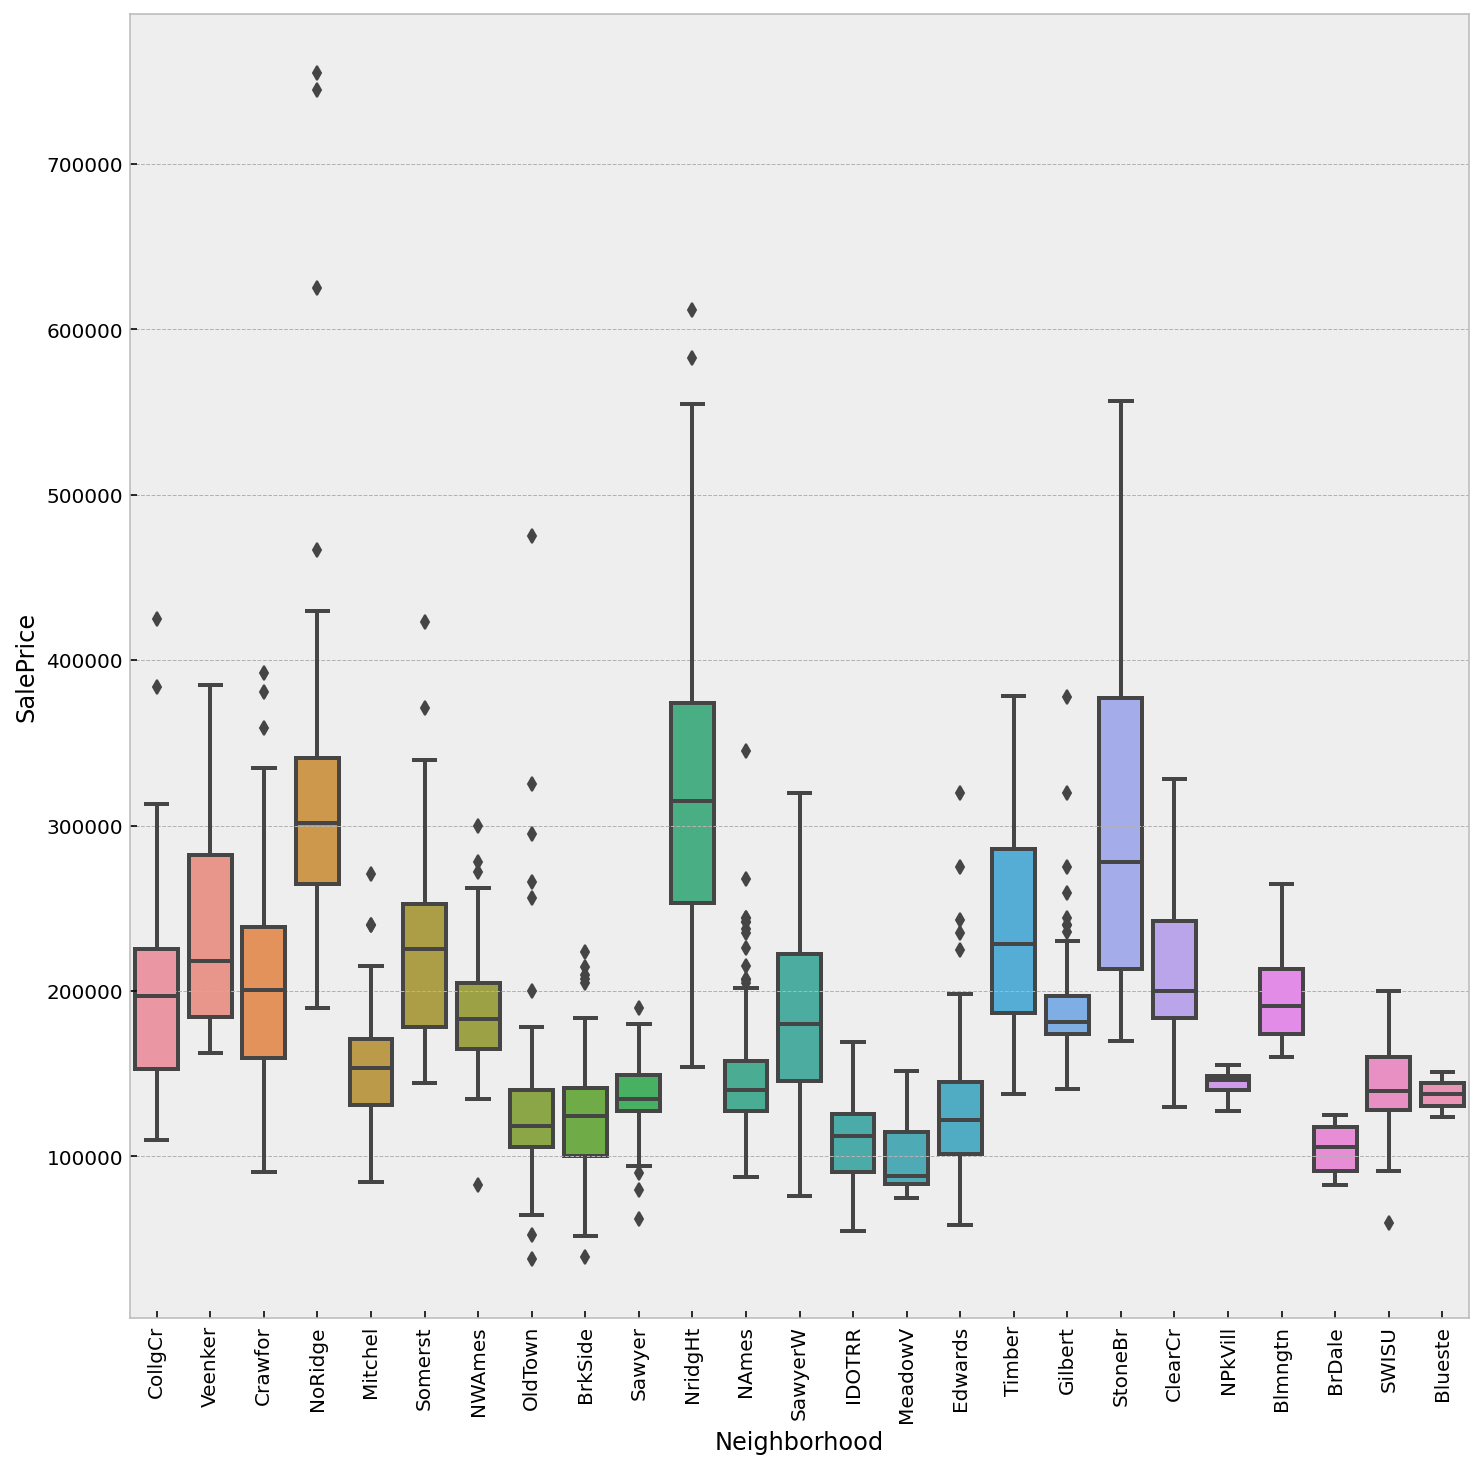

In [64]:
fig, ax = plt.subplots(figsize=(12,12))
sns.boxplot(x=residential.Neighborhood, y=residential.SalePrice, ax=ax)
plt.xticks(rotation=90)
plt.show()

### Month Sold & other time related variables

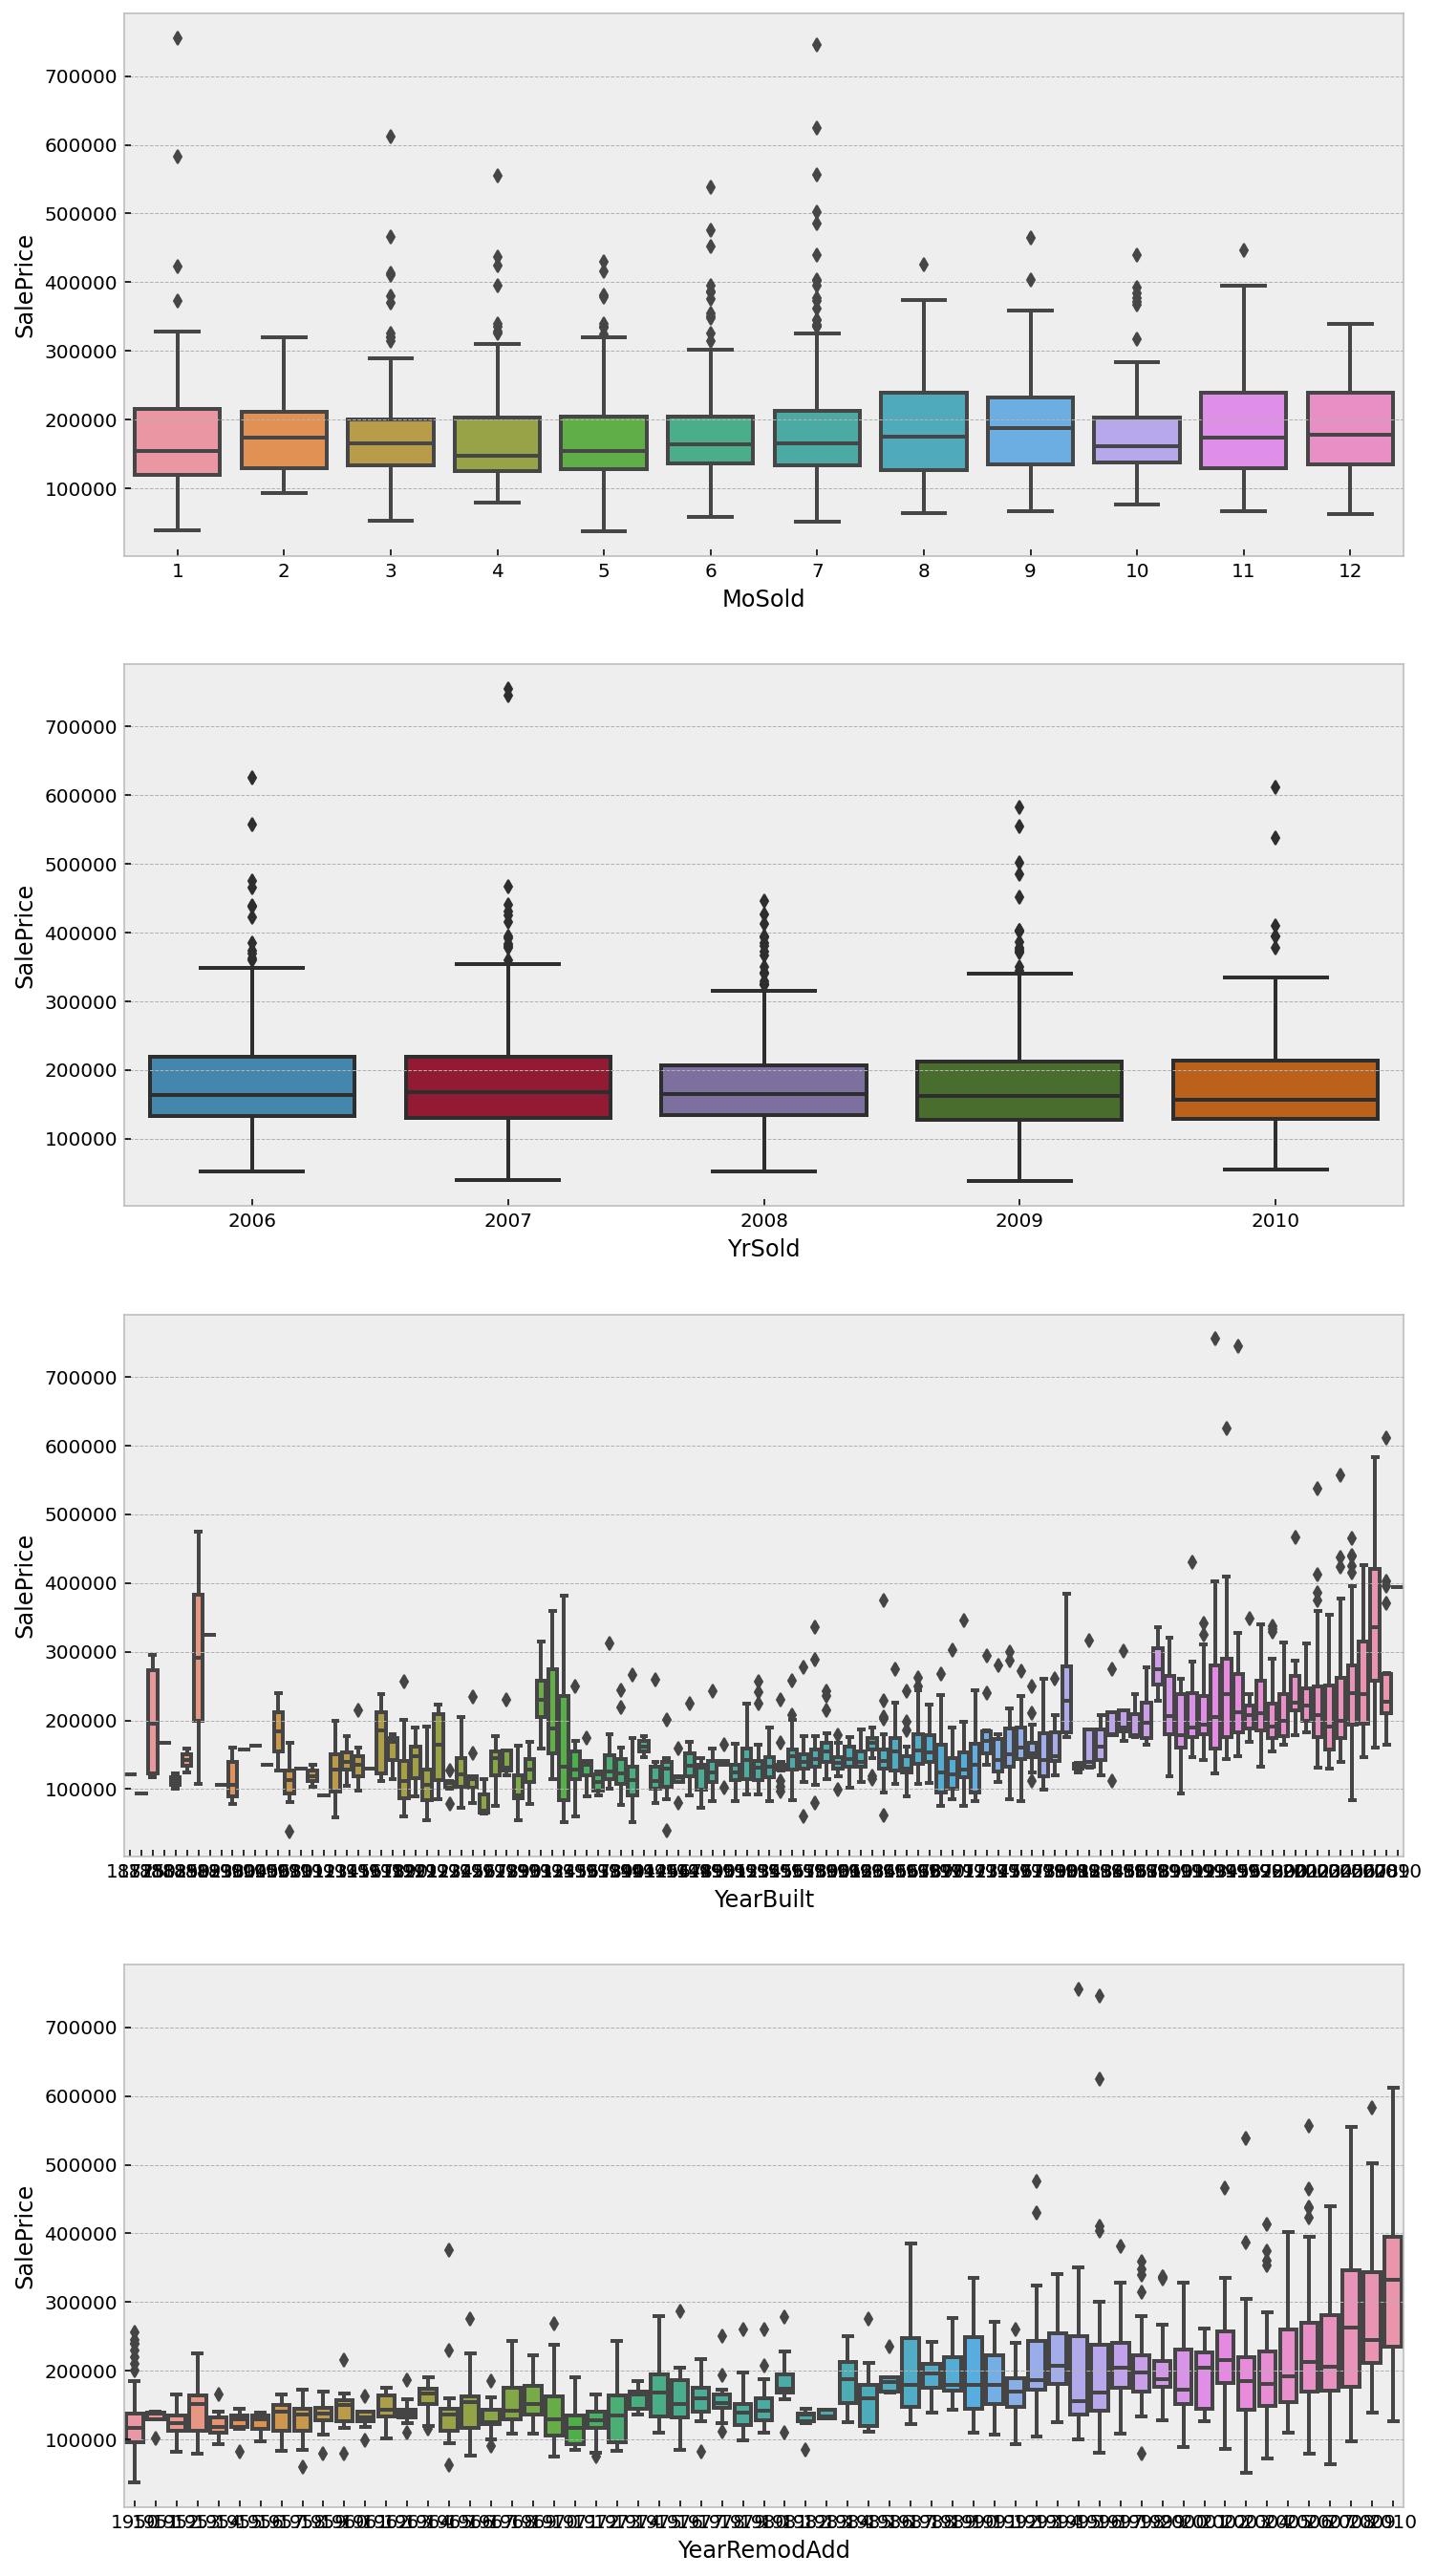

In [65]:
fig, ax = plt.subplots(figsize=(12,24), nrows=4)
sns.boxplot(x=residential['MoSold'], y=residential['SalePrice'],
            ax=ax[0])
sns.boxplot(x=residential['YrSold'], y=residential['SalePrice'],
            ax=ax[1])
sns.boxplot(x=residential['YearBuilt'], y=residential['SalePrice'],
            ax=ax[2])
sns.boxplot(x=residential['YearRemodAdd'], y=residential['SalePrice'],
            ax=ax[3])
plt.show()

In [66]:
residential.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1443
MiscFeature     1398
Alley           1361
GarageFinish      79
GarageQual        79
GarageCond        79
MasVnrType         8
MasVnrArea         8
Electrical         1
ExterQual          0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
BsmtQual           0
ExterCond          0
Foundation         0
YearBuilt          0
BsmtCond           0
BsmtExposure       0
dtype: int64

MoSold : seems to have almost no baring on the SalePrice we will remove it from the modelling

YearSold : interesting to note no real increase in SalePrice over the years

YearBuilt : could be polynomial, but could also be linear

YearRemodAdded : could have a problem with this for properties which have not had a remod. Will change the values to whether there has been a remodel in the last 20 years.

In [67]:
columns_to_be_removed += ['MoSold']

In [68]:
residential['RecentRemodAdd'] = residential['YearRemodAdd'].apply(lambda x:
                                                                1 if x>=1990 else 0)

<ipython-input-68-ef4ea2903532>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residential['RecentRemodAdd'] = residential['YearRemodAdd'].apply(lambda x:


In [69]:
columns_to_be_removed += ['YearRemodAdd']
columns_to_be_removed

['PoolQC',
 'PoolArea',
 'MiscFeature',
 'Alley',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'BsmtHalfBath',
 'BsmtFullBath',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'MoSold',
 'YearRemodAdd']

In [70]:
residential.describe(include='all')

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1450.000000  1450.000000     1450  1450.000000    1450.000000   1450   
unique          NaN          NaN        4          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1446   
mean     731.364138    56.903448      NaN    74.689898   10523.831724    NaN   
std      421.554345    42.265033      NaN    55.538405   10012.185355    NaN   
min        1.000000    20.000000      NaN    14.426749    1300.000000    NaN   
25%      366.250000    20.000000      NaN    59.000000    7544.500000    NaN   
50%      731.500000    50.000000      NaN    70.000000    9496.000000    NaN   
75%     1096.750000    70.000000      NaN    83.441639   11613.500000    NaN   
max     1460.000000   190.000000      NaN  1203.398387  215245.000000    NaN   

       Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count     89     1450        1450      1450      1450      1450         1450   
unique     2        4           4         2         5         3           25   
top     Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq      50      916        1305      1449      1044      1375          225   
mean     NaN      NaN         NaN       NaN       NaN       NaN          NaN   
std      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
min      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
25%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
50%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
75%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
max      NaN      NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1450       1450     1450       1450  1450.000000  1450.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1252       1436     1211        722          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.114483     5.582069   
std           NaN        NaN      NaN        NaN     1.372860     1.107330   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1450.000000   1450.000000      1450     1450        1450        1450   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1135     1424         515         504   
mean    1971.593103   1985.049655       NaN      NaN         NaN         NaN   
std       30.022696     20.552319       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2001.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count        1442  1442.000000      1450      1450       1450     1450   
unique          4          NaN         4         

In [71]:
residential.isnull().sum().sort_values().tail(10)

ExterCond          0
Electrical         1
MasVnrArea         8
MasVnrType         8
GarageCond        79
GarageQual        79
GarageFinish      79
Alley           1361
MiscFeature     1398
PoolQC          1443
dtype: int64

### Final EDA before modelling

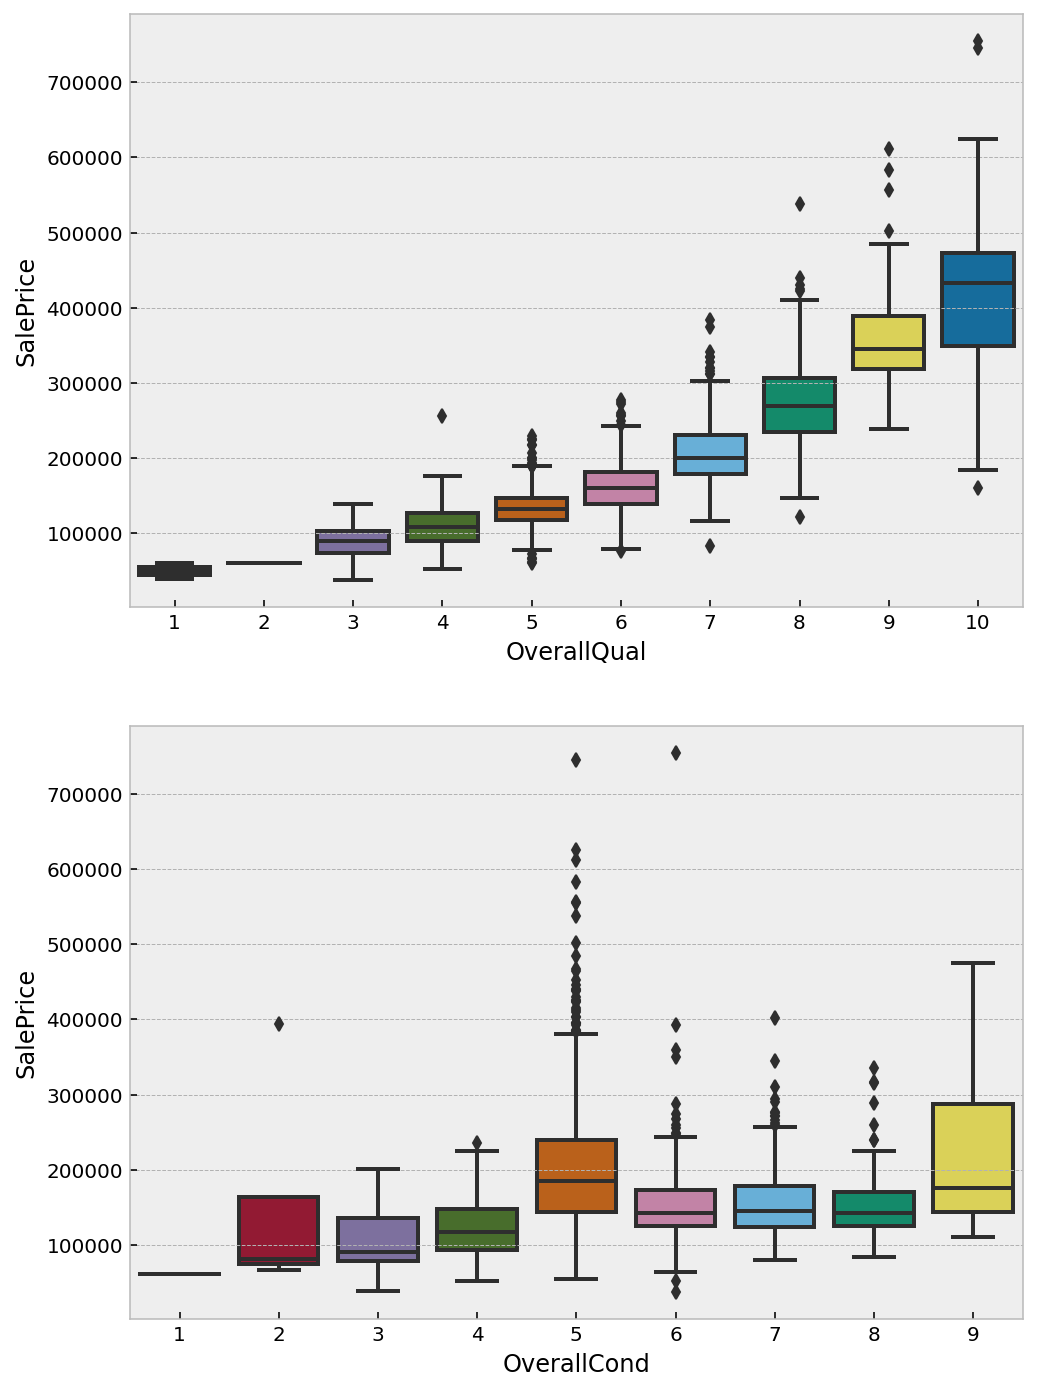

5    819
6    250
7    204
8     72
4     54
3     24
9     22
2      4
1      1
Name: OverallCond, dtype: int64


In [72]:
fig, ax = plt.subplots(figsize=(8,12), nrows=2)
sns.boxplot(x=residential['OverallQual'], y=residential['SalePrice'], ax=ax[0])
sns.boxplot(x=residential['OverallCond'], y=residential['SalePrice'], ax=ax[1])
plt.show()

print(residential['OverallCond'].value_counts())

OverallQual : is nicely distrtibuted as expected we will dummify though

OverallCond : looks like a less reliabel variable, we will leave it in and dummify it though

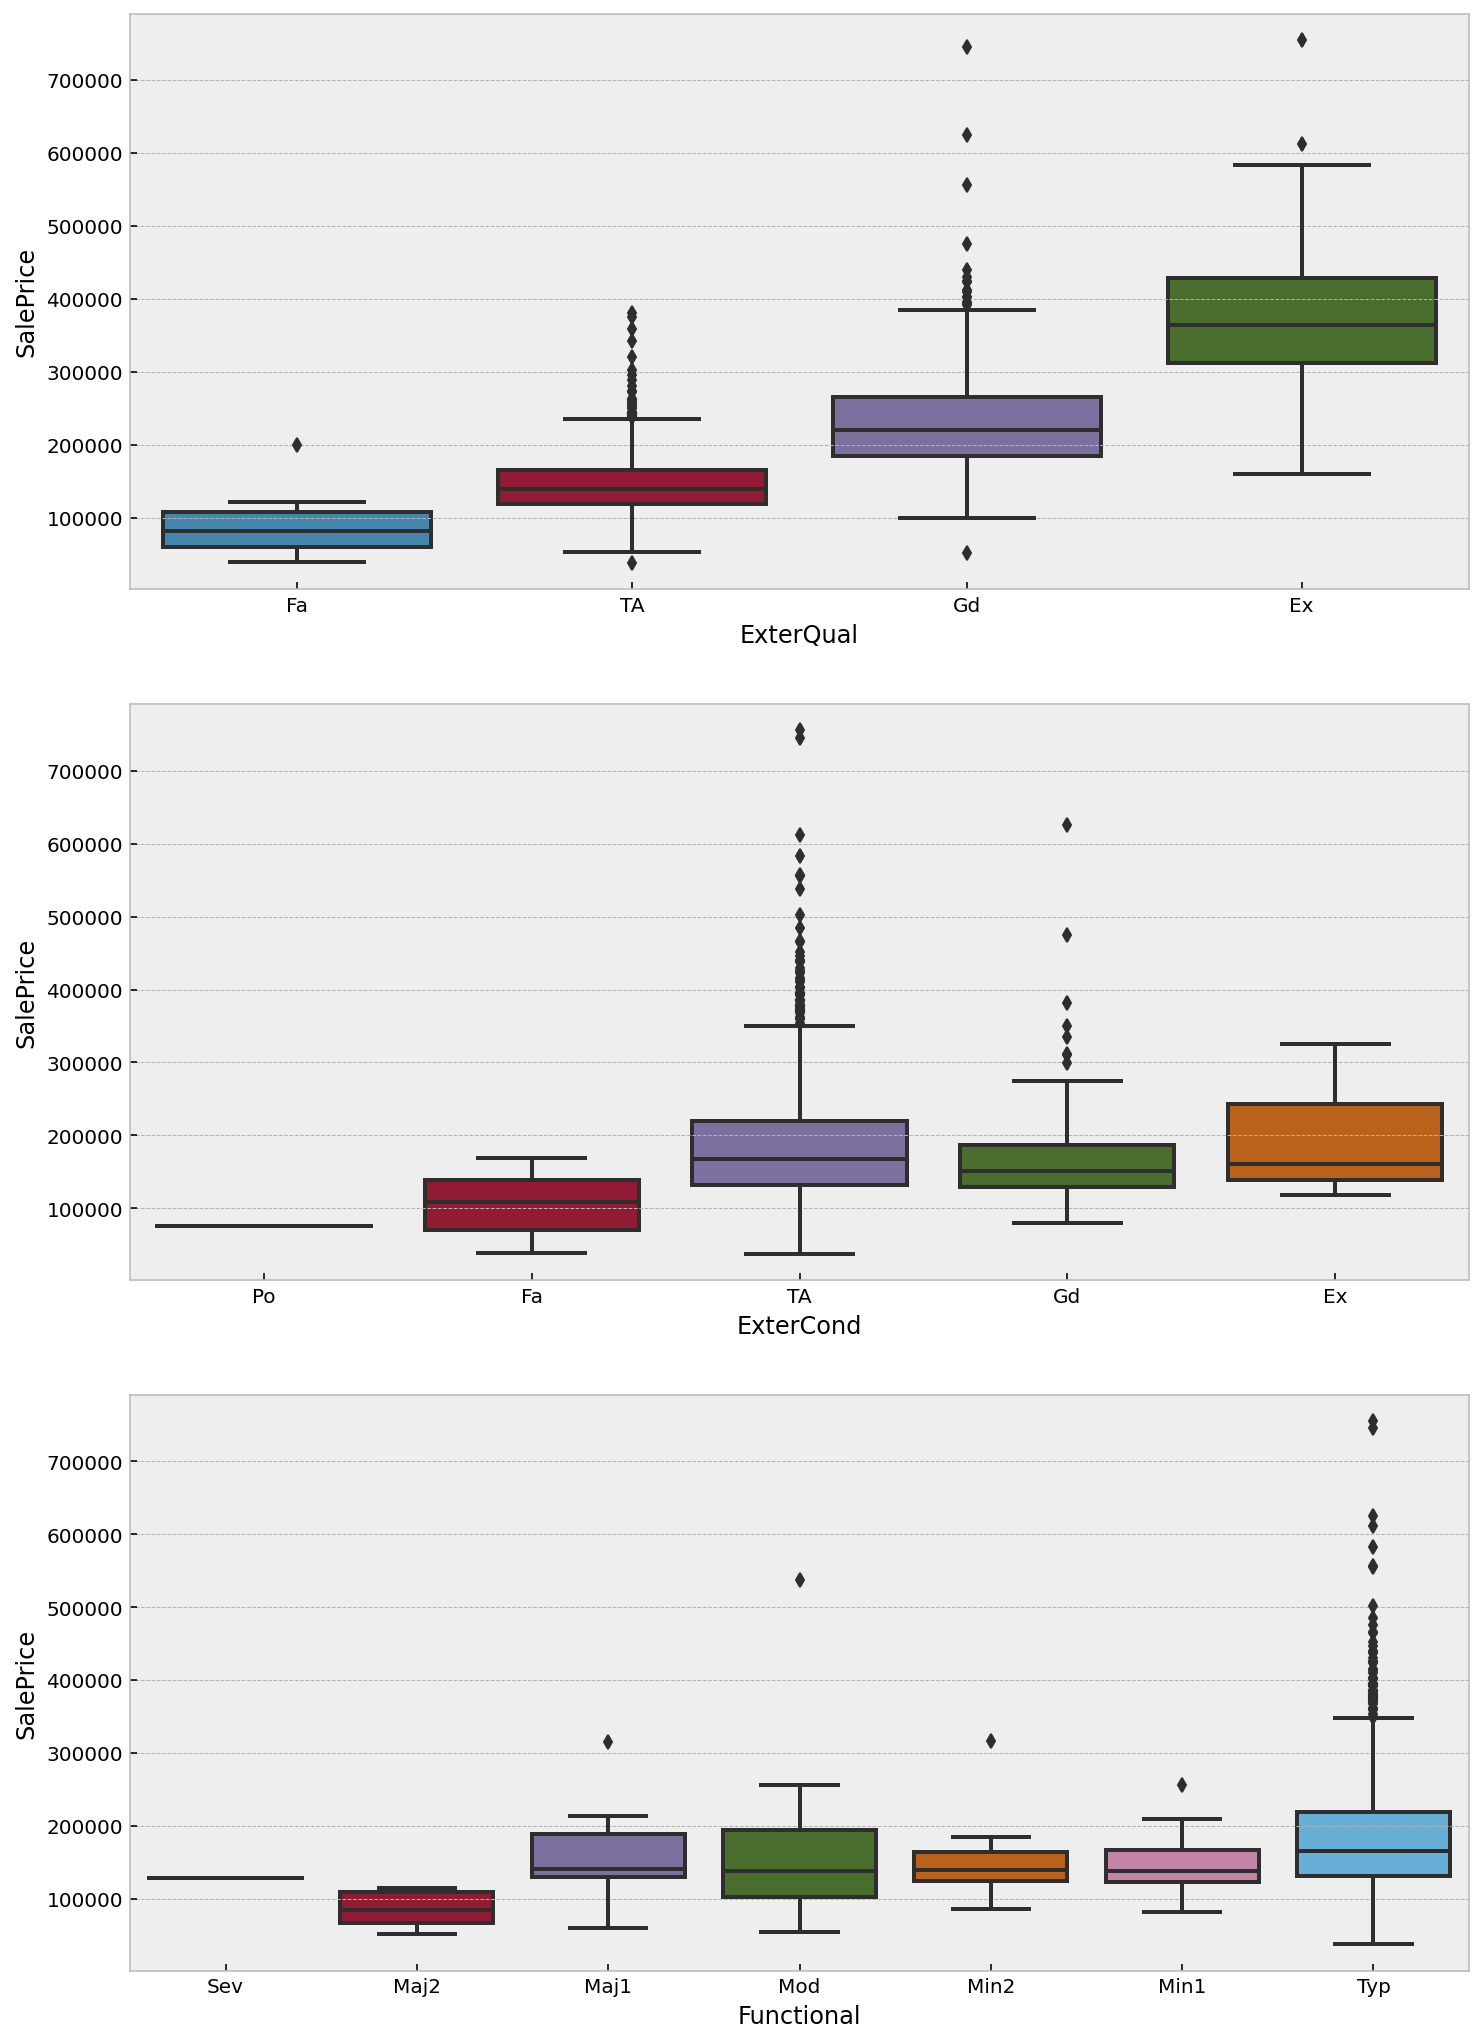

In [73]:
fig, ax = plt.subplots(figsize=(12,18), nrows=3)

sns.boxplot(x=residential['ExterQual'], y=residential['SalePrice'], ax=ax[0],
            order=['Fa', 'TA', 'Gd', 'Ex'])

sns.boxplot(x=residential['ExterCond'], y=residential['SalePrice'], ax=ax[1],
            order=['Po', 'Fa', 'TA', 'Gd', 'Ex'])

sns.boxplot(x=residential['Functional'], y=residential['SalePrice'], ax=ax[2],
            order=['Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'])

plt.show()

Nothing much to be worried about the above all these quality variables will stay in and be dummified for the modelling process.

We will not be requiring the SaleCondion or the SaleType for the modelling as we would not be privy to this information before a sale goes through.

In [74]:
columns_to_be_removed += ['SaleType', 'SaleCondition']

In [75]:
len(columns_to_be_removed)

17

In [76]:
residential.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'Has_Garage',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond

In [77]:
residential.shape

(1450, 85)

## Modelling

In [78]:
columns_to_be_removed

['PoolQC',
 'PoolArea',
 'MiscFeature',
 'Alley',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'BsmtHalfBath',
 'BsmtFullBath',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'MoSold',
 'YearRemodAdd',
 'SaleType',
 'SaleCondition']

In [79]:
df_resi = residential.copy()

In [80]:
df_resi.drop(columns=columns_to_be_removed, inplace=True)

In [81]:
fixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley',
         'LotShape','LandContour','Utilities','LotConfig','LandSlope',
         'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
         'YearBuilt','YearRemodAdd','MasVnrArea','Foundation','TotalBsmtSF',
         '1stFlrSF','2ndFlrSF','GrLivArea','FullBath','HalfBath',
         'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
         'Has_Garage','GarageType','GarageYrBlt','GarageCars',
         'GarageArea','EnclosedPorch','MiscFeature','MoSold','YrSold',
         'SaleType','SaleCondition','SalePrice', 'Has_Pool', 'RecentRemodAdd',
         'TotalSF']

fixed = [i for i in fixed if i not in columns_to_be_removed]

In [82]:
to_be_dummified = ['MSSubClass','MSZoning','Street','Alley','LotShape',
                   'LandContour','Utilities','LotConfig','LandSlope',
                   'Neighborhood','Condition1','Condition2','BldgType',
                   'HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                   'Exterior2nd','MasVnrType','ExterQual','ExterCond',
                   'Foundation','BsmtQual','BsmtCond','BsmtExposure',
                   'BsmtFinType1','BsmtFinType2','Heating','HeatingQC',
                   'CentralAir','Electrical','KitchenQual','Functional',
                   'FireplaceQu','GarageType','GarageYrBlt',
                   'GarageFinish','GarageQual','GarageCond','PavedDrive',
                   'PoolQC','MiscFeature','SaleType','SaleCondition', 'OverallCond',
                   'OverallQual', 'Fence', 'FireplaceQu'
                  ]
to_be_dummified = [i for i in to_be_dummified if i not in columns_to_be_removed]

In [83]:
index_to_be_removed += area_outliers
index_to_be_removed = list(set(index_to_be_removed))

In [84]:
df_resi.drop(index_to_be_removed, inplace=True)

In [85]:
df_resi.set_index('Id', inplace=True)

### Dummify and split into a traing set and test set

In [86]:
# Dummify
resi_fixed = pd.get_dummies(df_resi[fixed],
                            columns = [var for var in to_be_dummified if var in fixed],
                            drop_first=True, dummy_na=True)

In [87]:
resi_fixed.shape

(1404, 137)

In [88]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso , ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

In [89]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [90]:
# Split the data into test and train, using sale prices in 2010 as my test data
test_df = resi_fixed[(df_resi.YrSold==2010)]
train_df = resi_fixed[(df_resi.YrSold!=2010)]

In [91]:
# Split into training data (pre-2010) and test testing data (2010)
train_fixed_y = train_df.pop('SalePrice')
train_fixed_X = train_df.copy()
test_fixed_y = test_df.pop('SalePrice')
test_fixed_X = test_df.copy()

In [92]:
# Standardise the data
scaler = StandardScaler()

train_fixed_X = pd.DataFrame(scaler.fit_transform(train_fixed_X),
                             columns=train_fixed_X.columns)
test_fixed_X = pd.DataFrame(scaler.transform(test_fixed_X),
                            columns=test_fixed_X.columns)


### Linear Regression model

In [93]:
# Plot a linear regression model
lrmodel = LinearRegression()
lrmodel.fit(train_fixed_X, train_fixed_y)

cv_scores = cross_val_score(lrmodel, train_fixed_X, train_fixed_y, cv=kf)

print('Training score:', lrmodel.score(train_fixed_X, train_fixed_y))
print('CV scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('Test score:', lrmodel.score(test_fixed_X, test_fixed_y))

Training score: 0.8841398732793354
CV scores: [-3.11323359e+13 -4.07269737e+26 -7.65794650e+19 -1.69126188e+16
 -6.45970224e+23]
Mean CV score: -8.158315675115248e+25
Test score: 0.8630763373455915


The above cv-scores show the limitations for such model, so lets try some alternatives.

### Ridge model

In [94]:
# create a RidgeCV model instance
ridge_modelCV = RidgeCV(alphas=np.logspace(1, 2, 50), cv=kf)
# fit the model
ridge_modelCV.fit(train_fixed_X, train_fixed_y)
# get the best alpha
print('Best alpha:', ridge_modelCV.alpha_)
# evaluate on the training set
print('Training score:', ridge_modelCV.score(train_fixed_X,
                                             train_fixed_y))
# evaluate on the test set
print("Test Score:", ridge_modelCV.score(test_fixed_X,
                                         test_fixed_y))

Best alpha: 33.93221771895328
Training score: 0.8823561293956179
Test Score: 0.862381719070991


In [95]:
ridge_alpha = ridge_modelCV.alpha_
# create a Ridge model instance
ridge_model = Ridge(alpha=ridge_alpha)

# get cross validated scores
ridge_scores = cross_val_score(ridge_model, train_fixed_X, train_fixed_y, cv=kf)
print("Cross-validated training scores:", ridge_scores)
print("Mean cross-validated training score:", ridge_scores.mean())
# fit and evaluate the data on the whole training set
ridge_model.fit(train_fixed_X, train_fixed_y)
print("Training Score:", ridge_model.score(train_fixed_X, train_fixed_y))
# evaluate the data on the test set
print("Test Score:", ridge_model.score(train_fixed_X, train_fixed_y))

Cross-validated training scores: [0.80665364 0.83758816 0.88537243 0.86405245 0.84768546]
Mean cross-validated training score: 0.8482704295089128
Training Score: 0.8823561293956179
Test Score: 0.8823561293956179


Thats better the mean Cv-scores now make sense.

In [96]:
# collect the model coefficients in a dataframe
ridge_coef = pd.DataFrame(ridge_model.coef_, index=train_fixed_X.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
ridge_coef['coef_abs'] = ridge_coef.coefficients.abs()
ridge_coef

coefficients     coef_abs
LotFrontage         390.608012   390.608012
LotArea            3738.271780  3738.271780
YearBuilt          9696.179549  9696.179549
MasVnrArea         3765.013415  3765.013415
FullBath            499.568629   499.568629
...                        ...          ...
GarageYrBlt_1990   -574.842003   574.842003
GarageYrBlt_2000    945.199520   945.199520
GarageYrBlt_2010   4510.540692  4510.540692
GarageYrBlt_n       592.242318   592.242318
GarageYrBlt_nan       0.000000     0.000000

[136 rows x 2 columns]

### Lasso modelling

In [97]:
# create a LassoCV model instance
lasso_modelCV = LassoCV(alphas=np.logspace(2, 3, 50), cv=kf)
# fit the model
lasso_modelCV.fit(train_fixed_X, train_fixed_y)
# get the best alpha
print('Best alpha:', lasso_modelCV.alpha_)
# evaluate on the training set
print('Training score:', lasso_modelCV.score(train_fixed_X, train_fixed_y))
# evaluate on the test set
print("Test Score:", lasso_modelCV.score(train_fixed_X, train_fixed_y))

Best alpha: 372.7593720314938
Training score: 0.8787269863839121
Test Score: 0.8787269863839121


In [98]:
lasso_alpha = lasso_modelCV.alpha_
# create a Lasso model instance
lasso_model = Lasso(alpha=lasso_alpha)

# get cross validated scores
lasso_scores = cross_val_score(lasso_model, train_fixed_X, train_fixed_y, cv=kf)
print("Cross-validated training scores:", lasso_scores)
print("Mean cross-validated training score:", lasso_scores.mean())
# fit and evaluate the data on the whole training set
lasso_model.fit(train_fixed_X, train_fixed_y)
print("Training Score:", lasso_model.score(train_fixed_X, train_fixed_y))
# evaluate the data on the test set
print("Test Score:", lasso_model.score(test_fixed_X, test_fixed_y))

Cross-validated training scores: [0.81659461 0.85084271 0.89295685 0.86537017 0.8486158 ]
Mean cross-validated training score: 0.8548760289179119
Training Score: 0.8787269863839121
Test Score: 0.865575089192425


In [99]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(lasso_model.coef_, index=train_fixed_X.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
lasso_coef['coef_abs'] = lasso_coef.coefficients.abs()
lasso_coef

coefficients      coef_abs
LotFrontage         160.279466    160.279466
LotArea            3016.158166   3016.158166
YearBuilt         12014.387640  12014.387640
MasVnrArea         3355.298212   3355.298212
FullBath              0.000000      0.000000
...                        ...           ...
GarageYrBlt_1990     -0.000000      0.000000
GarageYrBlt_2000     38.094579     38.094579
GarageYrBlt_2010   4328.574342   4328.574342
GarageYrBlt_n         0.000000      0.000000
GarageYrBlt_nan       0.000000      0.000000

[136 rows x 2 columns]

The Lasso model has reduced our coefficient's with values to 75 making our model less complex than in the ridge model with very slightly higher CV scores.

### ElasticNet modelling

In [100]:
# create an ElastinNetCV model instance
elastic_modelCV = ElasticNetCV(alphas=np.linspace(0.001, 1, 20), 
                     l1_ratio=np.array([.92, .93, .94, .95, .96, .97, .98, .99, 1]),
                     cv=kf, max_iter=1000000, n_jobs=2)
# fit the model
elastic_modelCV.fit(train_fixed_X, train_fixed_y)
# get the best alpha
print('Best alpha:', elastic_modelCV.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', elastic_modelCV.l1_ratio_)
# evaluate on the training set
print('Training score:', elastic_modelCV.score(train_fixed_X, train_fixed_y))
# evaluate on the test set
print("Test Score:", elastic_modelCV.score(test_fixed_X, test_fixed_y))

Best alpha: 0.8422631578947368
Best l1-ratio: 0.96
Training score: 0.8819202175069911
Test Score: 0.8624341262813532


In [101]:
elastic_alpha = elastic_modelCV.alpha_ 
l1_ratio = elastic_modelCV.l1_ratio_
# create an ElasticNet model instance
elastic_model = ElasticNet(alpha=elastic_alpha, l1_ratio=l1_ratio)

# get cross validated scores
elastic_scores = cross_val_score(elastic_model,
                                 train_fixed_X, train_fixed_y, cv=kf)
print("Cross-validated training scores:", elastic_scores)
print("Mean cross-validated training score:", elastic_scores.mean())
# fit and evaluate the data on the whole training set
elastic_model.fit(train_fixed_X, train_fixed_y)
print("Training Score:", elastic_model.score(train_fixed_X, train_fixed_y))
# evaluate the data on the test set
print("Test Score:", elastic_model.score(test_fixed_X, test_fixed_y))

Cross-validated training scores: [0.8066944  0.83761579 0.88538835 0.8640678  0.84771982]
Mean cross-validated training score: 0.8482972328126793
Training Score: 0.8819202175069911
Test Score: 0.8624341262813532


In [102]:
# collect the model coefficients in a dataframe
elastic_coef = pd.DataFrame(lasso_model.coef_, index=train_fixed_X.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
elastic_coef['coef_abs'] = elastic_coef.coefficients.abs()
elastic_coef

coefficients      coef_abs
LotFrontage         160.279466    160.279466
LotArea            3016.158166   3016.158166
YearBuilt         12014.387640  12014.387640
MasVnrArea         3355.298212   3355.298212
FullBath              0.000000      0.000000
...                        ...           ...
GarageYrBlt_1990     -0.000000      0.000000
GarageYrBlt_2000     38.094579     38.094579
GarageYrBlt_2010   4328.574342   4328.574342
GarageYrBlt_n         0.000000      0.000000
GarageYrBlt_nan       0.000000      0.000000

[136 rows x 2 columns]

ElasticNet model performed slightly worse than the lasso model I will be using the Lasso model for the rest of the project.

## Lasso model was the best

Cross-validated training scores : (0.81659461, 0.85084271, 0.89295685, 0.86537017, 0.8486158 )

Mean cross-validated training score : 0.8548760289179119

Training Score : 0.8787269863839121

Test Score : 0.865575089192425

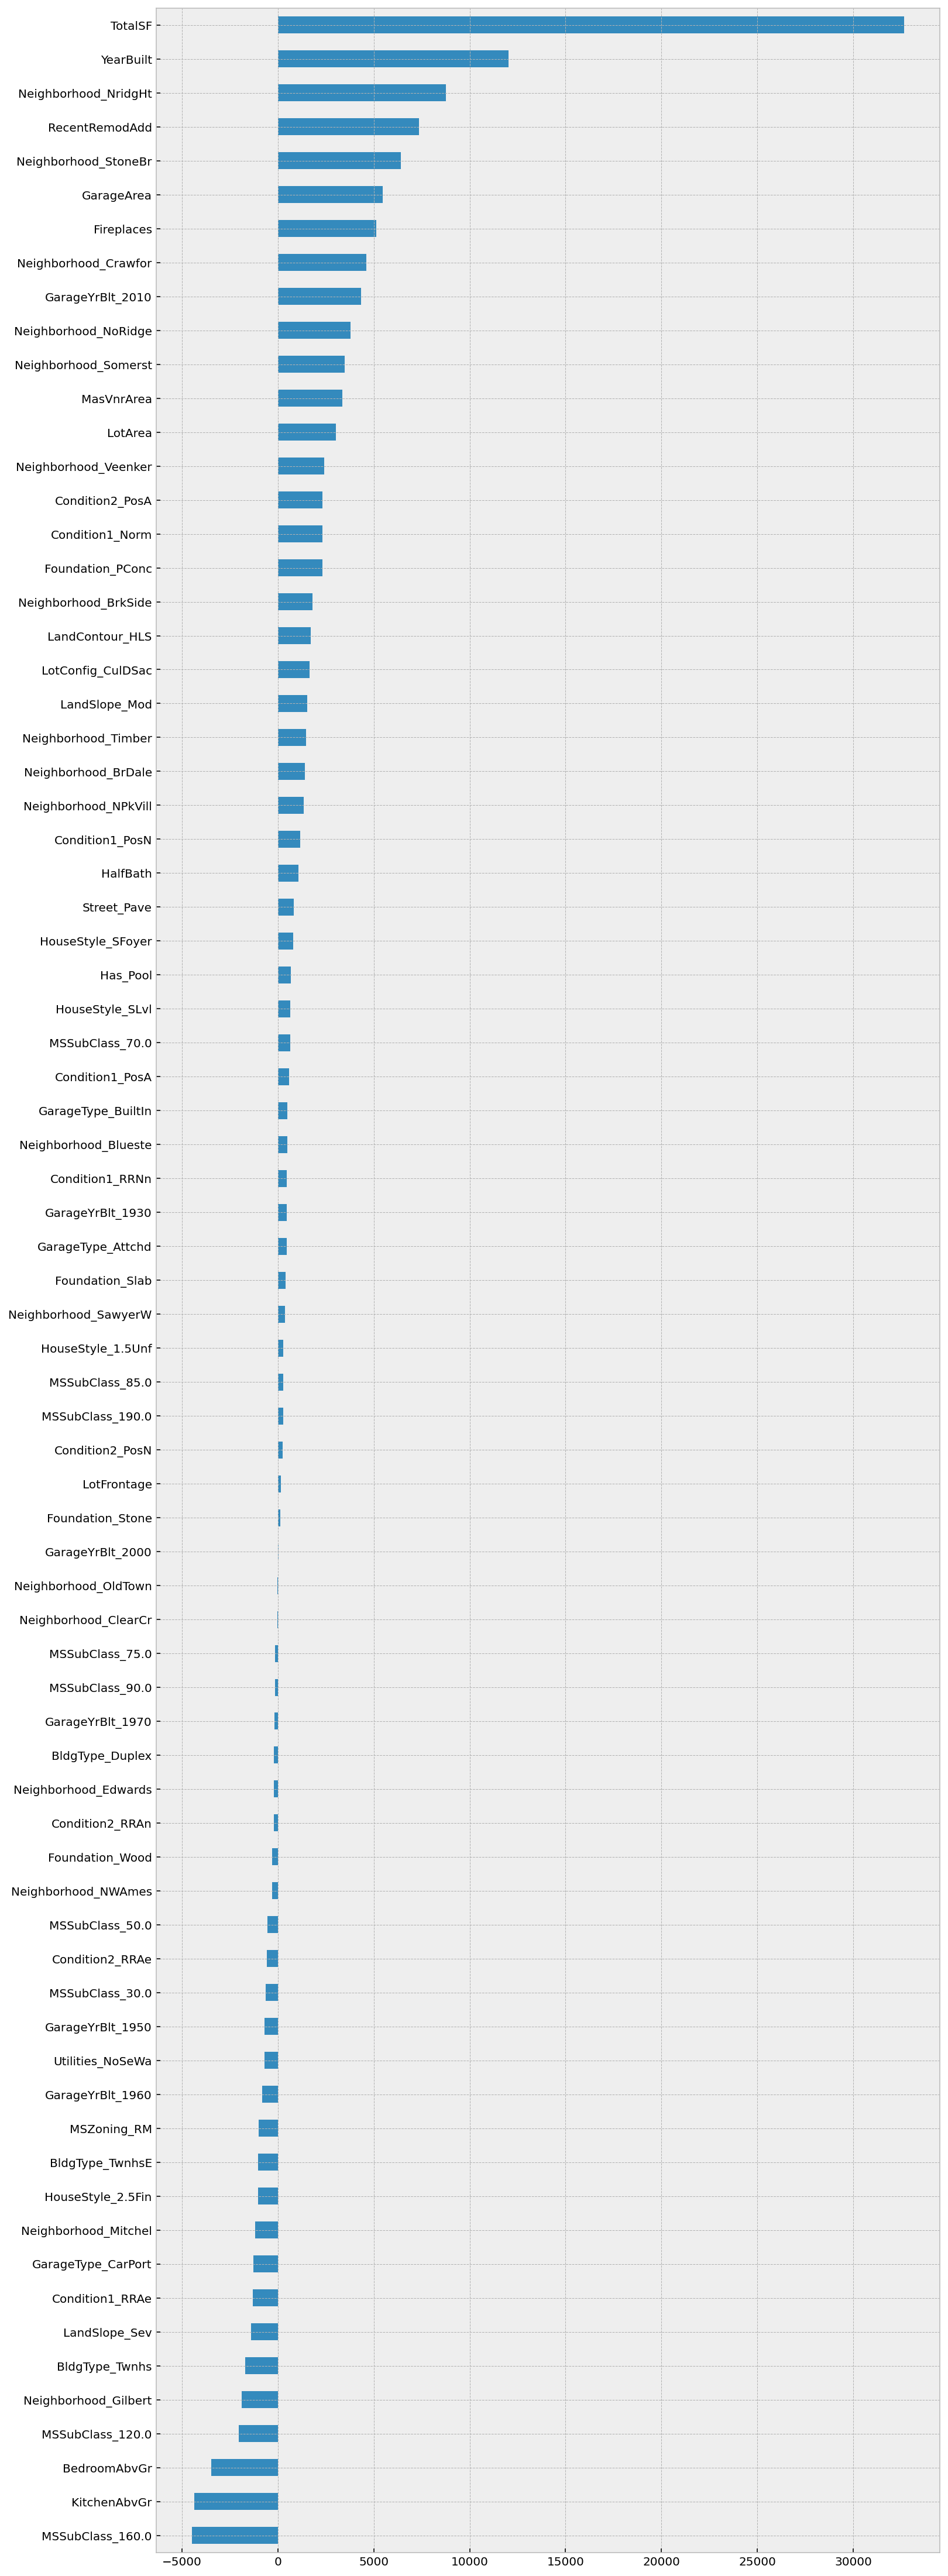

In [103]:
fig, ax = plt.subplots(figsize=(12,40))
lasso_coef[lasso_coef['coef_abs']>0]['coefficients'].sort_values().plot(kind='barh');

In [104]:
X = resi_fixed.drop(columns='SalePrice')
X = pd.DataFrame(scaler.transform(X),
                            columns=X.columns)

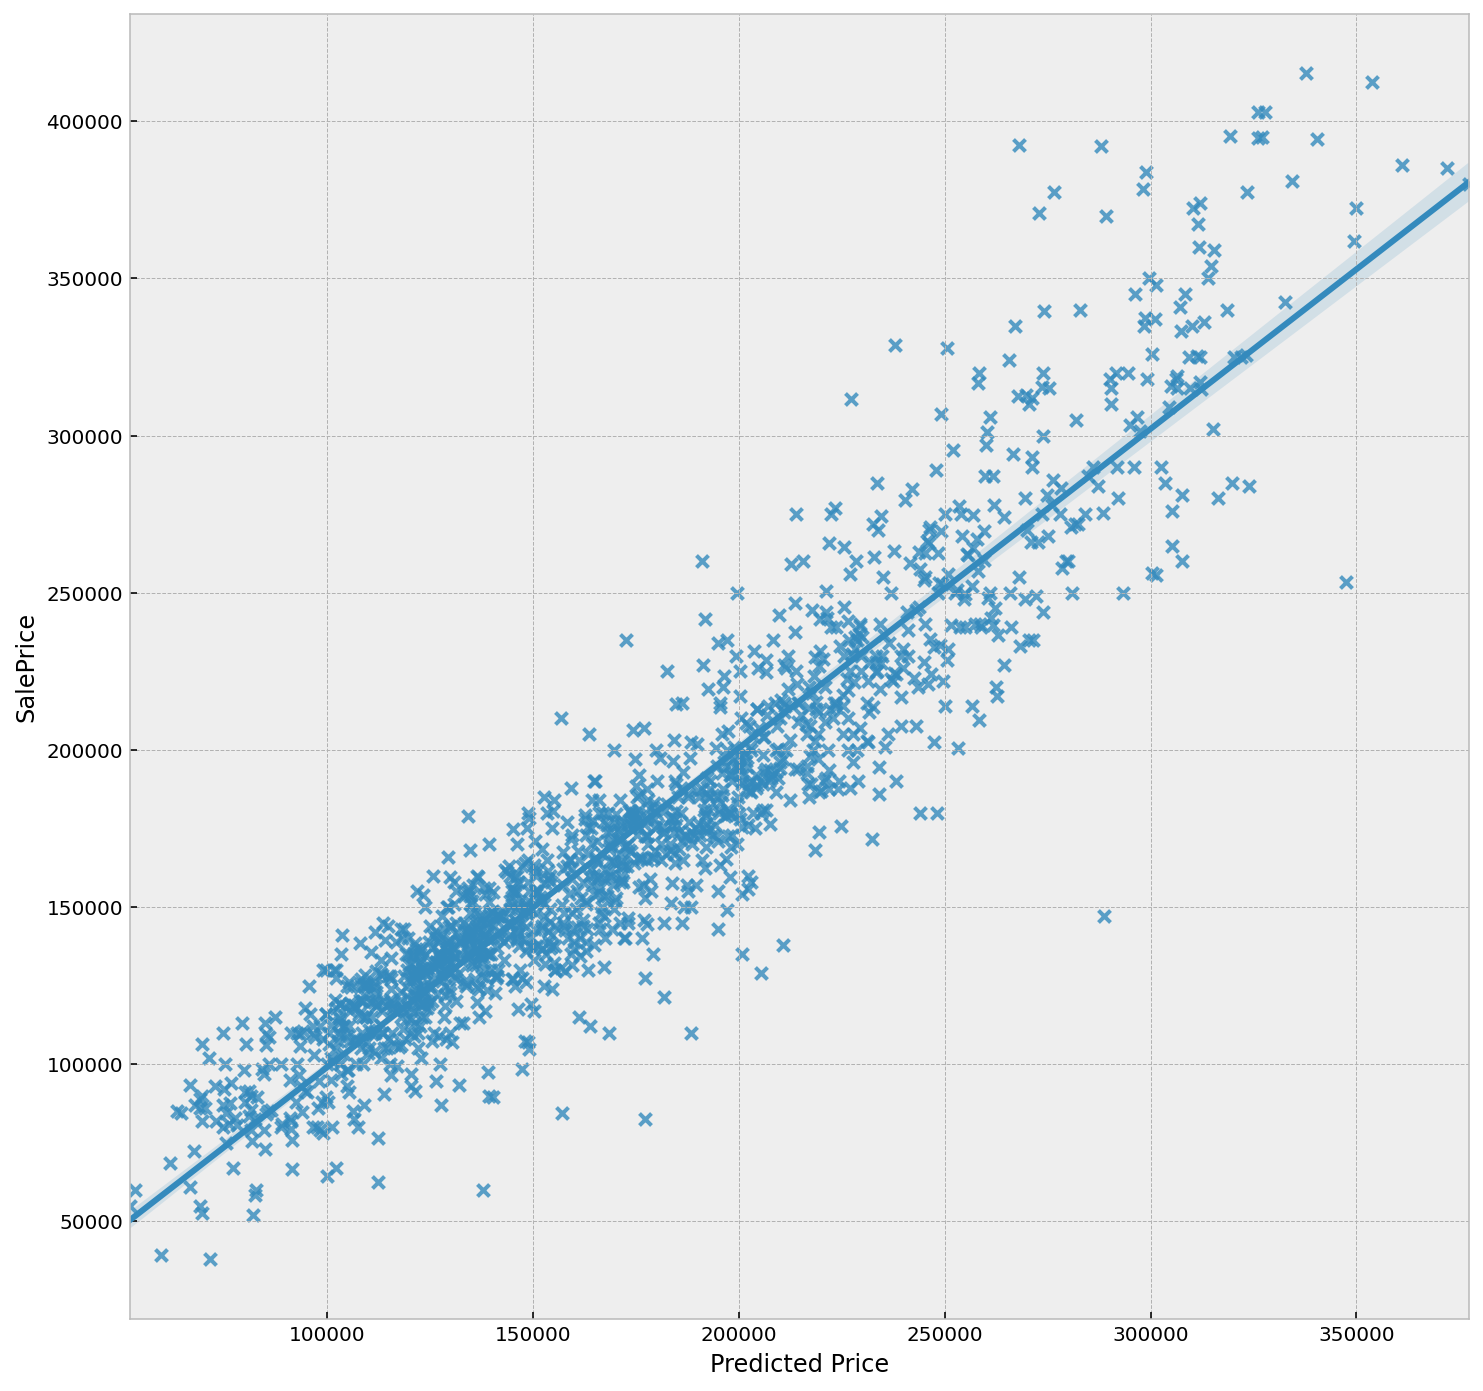

In [105]:
fig, ax = plt.subplots(figsize=(12,12,))
sns.regplot(y=resi_fixed['SalePrice'], x=lasso_model.predict(X), marker='x', ax=ax)
plt.xlabel('Predicted Price');

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [106]:
renovatables = [col for col in df_resi.columns if col not in fixed]+['YrSold']
renovatables = [col for col in renovatables if col not in columns_to_be_removed]

In [107]:
renovatables

['OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 '3SsnPorch',
 'ScreenPorch',
 'Fence',
 'MiscVal',
 'YrSold']

In [108]:
df_resi['Residuals']=df_resi['SalePrice']-lasso_model.predict(X)

In [109]:
# A:
df_reno = pd.get_dummies(df_resi[renovatables+['Residuals']],
                            columns = [var for var in to_be_dummified if var in renovatables],
                            drop_first=True, dummy_na=True)

In [110]:
df_reno.head()

BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  LowQualFinSF  WoodDeckSF  OpenPorchSF  \
Id                                                                             
1          706           0        150             0           0           61   
2          978           0        284             0         298            0   
3          486           0        434             0           0           42   
4          216           0        540             0           0           35   
5          655           0        490             0         192           84   

    3SsnPorch  ScreenPorch  MiscVal  YrSold     Residuals  RoofStyle_Gable  \
Id                                                                           
1           0            0        0    2008   6857.143748                1   
2           0            0        0    2007   3057.642898                1   
3           0            0        0    2008   5275.785765                1   
4           0            0        0    2006 -36428.941430                1   
5           0            0        0    2008 -31025.858228                1   

    RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  RoofStyle_Shed  \
Id                                                                        
1                   0              0                  0               0   
2                   0              0                  0               0   
3                   0              0                  0               0   
4                   0              0                  0               0   
5                   0              0                  0               0   

    RoofStyle_nan  RoofMatl_Membran  RoofMatl_Metal  RoofMatl_Roll  \
Id                                                                   
1               0                 0               0              0   
2               0                 0               0              0   
3               0                 0               0              0   
4               0                 0               0              0   
5               0                 0               0              0   

    RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl  RoofMatl_nan  \
Id                                                                       
1                  0                 0                 0             0   
2                  0                 0                 0             0   
3                  0                 0                 0             0   
4                  0                 0                 0             0   
5                  0                 0                 0             0   

    Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  \
Id                                                                  
1                     0                    0                    0   
2                     0                    0                    0   
3                     0                    0                    0   
4                     0                    0                    0   
5                     0                    0                    0   

    Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  \
Id                                                                 
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   
5                    0                    0                    0   

    Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  \
Id                                                                  
1                     0                    0                    0   
2                     0                    1                    0   
3                     0                    0                    0   
4                     0                    0          

In [111]:
test_reno = df_reno[(df_reno.YrSold==2010)]
train_reno = df_reno[(df_reno.YrSold!=2010)]

In [112]:
train_reno_y = train_reno.pop('Residuals')
train_reno_X = train_reno.copy()
test_reno_y = test_reno.pop('Residuals')
test_reno_X = test_reno.copy()

In [113]:
scaler = StandardScaler()

train_reno_X = pd.DataFrame(scaler.fit_transform(train_reno_X),
                             columns=train_reno_X.columns)
test_reno_X = pd.DataFrame(scaler.transform(test_reno_X),
                            columns=test_reno_X.columns)

### Linear Regression model

In [114]:
# Plot a linear regression model
lr_reno = LinearRegression()
lr_reno.fit(train_reno_X, train_reno_y)# Plot a linear regression model


cv_scores = cross_val_score(lr_reno, train_reno_X, train_reno_y, cv=kf)

print('Training score:', lr_reno.score(train_reno_X, train_reno_y))
print('CV scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('Test score:', lr_reno.score(test_reno_X, test_reno_y))

Training score: 0.4114314670301764
CV scores: [-4.90977788e+23 -1.17533534e+23 -2.85843969e+22 -1.90037427e+24
 -3.09900936e+22]
Mean CV score: -5.136920170065766e+23
Test score: -5.720703119668294e+19


### Ridge model

In [115]:
# create a RidgeCV model instance
ridge_renoCV = RidgeCV(alphas=np.linspace(290, 300, 50), cv=kf)
# fit the model
ridge_renoCV.fit(train_reno_X, train_reno_y)
# get the best alpha
print('Best alpha:', ridge_renoCV.alpha_)
# evaluate on the training set
print('Training score:', ridge_renoCV.score(train_reno_X,
                                             train_reno_y))
# evaluate on the test set
print("Test Score:", ridge_renoCV.score(test_reno_X,
                                         test_reno_y))

Best alpha: 293.8775510204082
Training score: 0.38866419940696884
Test Score: 0.28103362237836127


In [116]:
ridge_reno_alpha = ridge_renoCV.alpha_
# create a Ridge model instance
ridge_reno = Ridge(alpha=ridge_reno_alpha)

# get cross validated scores
ridge_reno_scores = cross_val_score(ridge_reno, train_reno_X, train_reno_y, cv=kf)
print("Cross-validated training scores:", ridge_reno_scores)
print("Mean cross-validated training score:", ridge_reno_scores.mean())
# fit and evaluate the data on the whole training set
ridge_reno.fit(train_reno_X, train_reno_y)
print("Training Score:", ridge_reno.score(train_reno_X, train_reno_y))
# evaluate the data on the test set
print("Test Score:", ridge_reno.score(train_reno_X, train_reno_y))

Cross-validated training scores: [0.27467863 0.27476771 0.25550049 0.32837879 0.19980558]
Mean cross-validated training score: 0.2666262424742459
Training Score: 0.38866419940696884
Test Score: 0.38866419940696884


### Lasso Model

In [117]:
# create a LassoCV model instance
lasso_renoCV = LassoCV(alphas=np.linspace(400, 405, 50), cv=kf, max_iter=100000, n_jobs=2)
# fit the model
lasso_renoCV.fit(train_reno_X, train_reno_y)
# get the best alpha
print('Best alpha:', lasso_renoCV.alpha_)
# evaluate on the training set
print('Training score:', lasso_renoCV.score(train_reno_X, train_reno_y))
# evaluate on the test set
print("Test Score:", lasso_renoCV.score(train_reno_X, train_reno_y))

Best alpha: 402.7551020408163
Training score: 0.37698624984819906
Test Score: 0.37698624984819906


In [118]:
lasso_reno_alpha = lasso_renoCV.alpha_
# create a Lasso model instance
lasso_reno = Lasso(alpha=lasso_reno_alpha)

# get cross validated scores
lasso_reno_scores = cross_val_score(lasso_model, train_reno_X, train_reno_y, cv=kf)
print("Cross-validated training scores:", lasso_reno_scores)
print("Mean cross-validated training score:", lasso_reno_scores.mean())
# fit and evaluate the data on the whole training set
lasso_reno.fit(train_reno_X, train_reno_y)
print("Training Score:", lasso_reno.score(train_reno_X, train_reno_y))
# evaluate the data on the test set
print("Test Score:", lasso_reno.score(test_reno_X, test_reno_y))

Cross-validated training scores: [0.2837975  0.30332032 0.28168056 0.33780036 0.22894289]
Mean cross-validated training score: 0.2871083274855854
Training Score: 0.37698624984819906
Test Score: 0.3120553147696741


In [119]:
# collect the model coefficients in a dataframe
reno_coef = pd.DataFrame(lasso_reno.coef_, index=train_reno_X.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
reno_coef['coef_abs'] = reno_coef.coefficients.abs()
reno_coef

coefficients     coef_abs
BsmtFinSF1            0.000000     0.000000
BsmtFinSF2           -0.000000     0.000000
BsmtUnfSF         -5872.576511  5872.576511
LowQualFinSF         -0.000000     0.000000
WoodDeckSF          879.703250   879.703250
...                        ...          ...
FireplaceQu_Gd        0.000000     0.000000
FireplaceQu_None   1620.695260  1620.695260
FireplaceQu_Po        0.000000     0.000000
FireplaceQu_TA       -0.000000     0.000000
FireplaceQu_nan       0.000000     0.000000

[167 rows x 2 columns]

### Elastic Model

In [120]:
# create an ElastinNetCV model instance
elastic_renoCV = ElasticNetCV(alphas=np.linspace(4.5, 5, 20), 
                     l1_ratio=np.array([.91, .92, .93, .94, .95, .96, .97, .98, .99, 1]),
                     cv=kf, max_iter=1000000, n_jobs=2)
# fit the model
elastic_renoCV.fit(train_reno_X, train_reno_y)
# get the best alpha
print('Best alpha:', elastic_renoCV.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', elastic_renoCV.l1_ratio_)
# evaluate on the training set
print('Training score:', elastic_renoCV.score(train_reno_X, train_reno_y))
# evaluate on the test set
print("Test Score:", elastic_renoCV.score(test_reno_X, test_reno_y))

Best alpha: 4.868421052631579
Best l1-ratio: 0.94
Training score: 0.3826415567581499
Test Score: 0.27774421909686464


In [121]:
elastic_reno_alpha = elastic_renoCV.alpha_ 
l1_reno_ratio = elastic_renoCV.l1_ratio_
# create an ElasticNet model instance
elastic_reno = ElasticNet(alpha=elastic_reno_alpha, l1_ratio=elastic_renoCV.l1_ratio_)

# get cross validated scores
elastic_reno_scores = cross_val_score(elastic_reno,
                                 train_reno_X, train_reno_y, cv=kf)
print("Cross-validated training scores:", elastic_reno_scores)
print("Mean cross-validated training score:", elastic_reno_scores.mean())
# fit and evaluate the data on the whole training set
elastic_reno.fit(train_reno_X, train_reno_y)
print("Training Score:", elastic_reno.score(train_reno_X, train_reno_y))
# evaluate the data on the test set
print("Test Score:", elastic_reno.score(test_reno_X, test_reno_y))

Cross-validated training scores: [0.27484659 0.27519823 0.25616266 0.32862534 0.20015208]
Mean cross-validated training score: 0.2669969798708468
Training Score: 0.3826415567581499
Test Score: 0.27774421909686464


Once again the lasso model performs best for predicting the residuals. Although the R^2 score at .28 is not great and shows that predicting the residuals is quite a difficult prospect.

In [122]:
reno_X = df_reno.drop(columns='Residuals')
reno_X = pd.DataFrame(scaler.transform(reno_X),
                            columns=reno_X.columns)

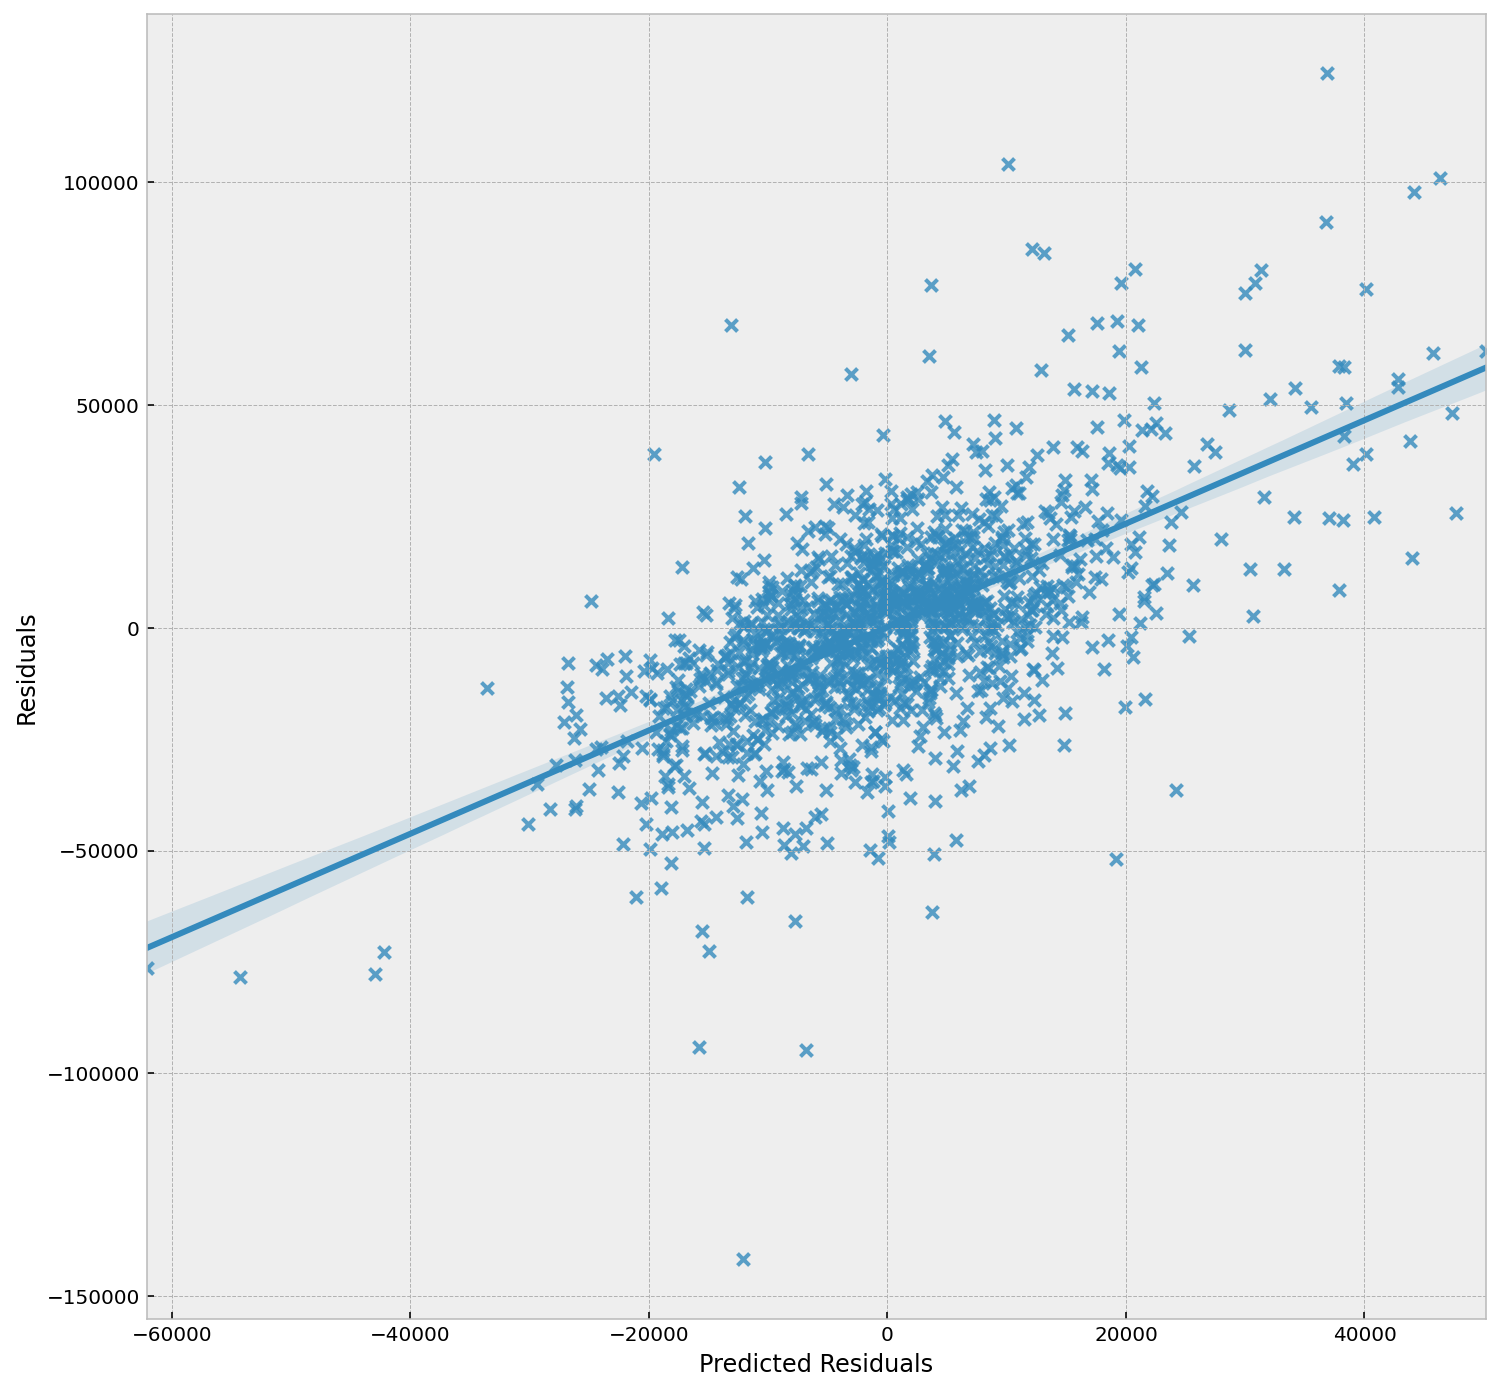

In [123]:
fig, ax = plt.subplots(figsize=(12,12,))
sns.regplot(y=df_reno['Residuals'], x=lasso_reno.predict(reno_X), marker='x')
# sns.lineplot([min(lasso_reno.predict(reno_X)),max(lasso_reno.predict(reno_X))],
#              [0,0])
# sns.lineplot([0,0],[-150000,max(df_reno['Residuals'])])
plt.xlabel('Predicted Residuals');

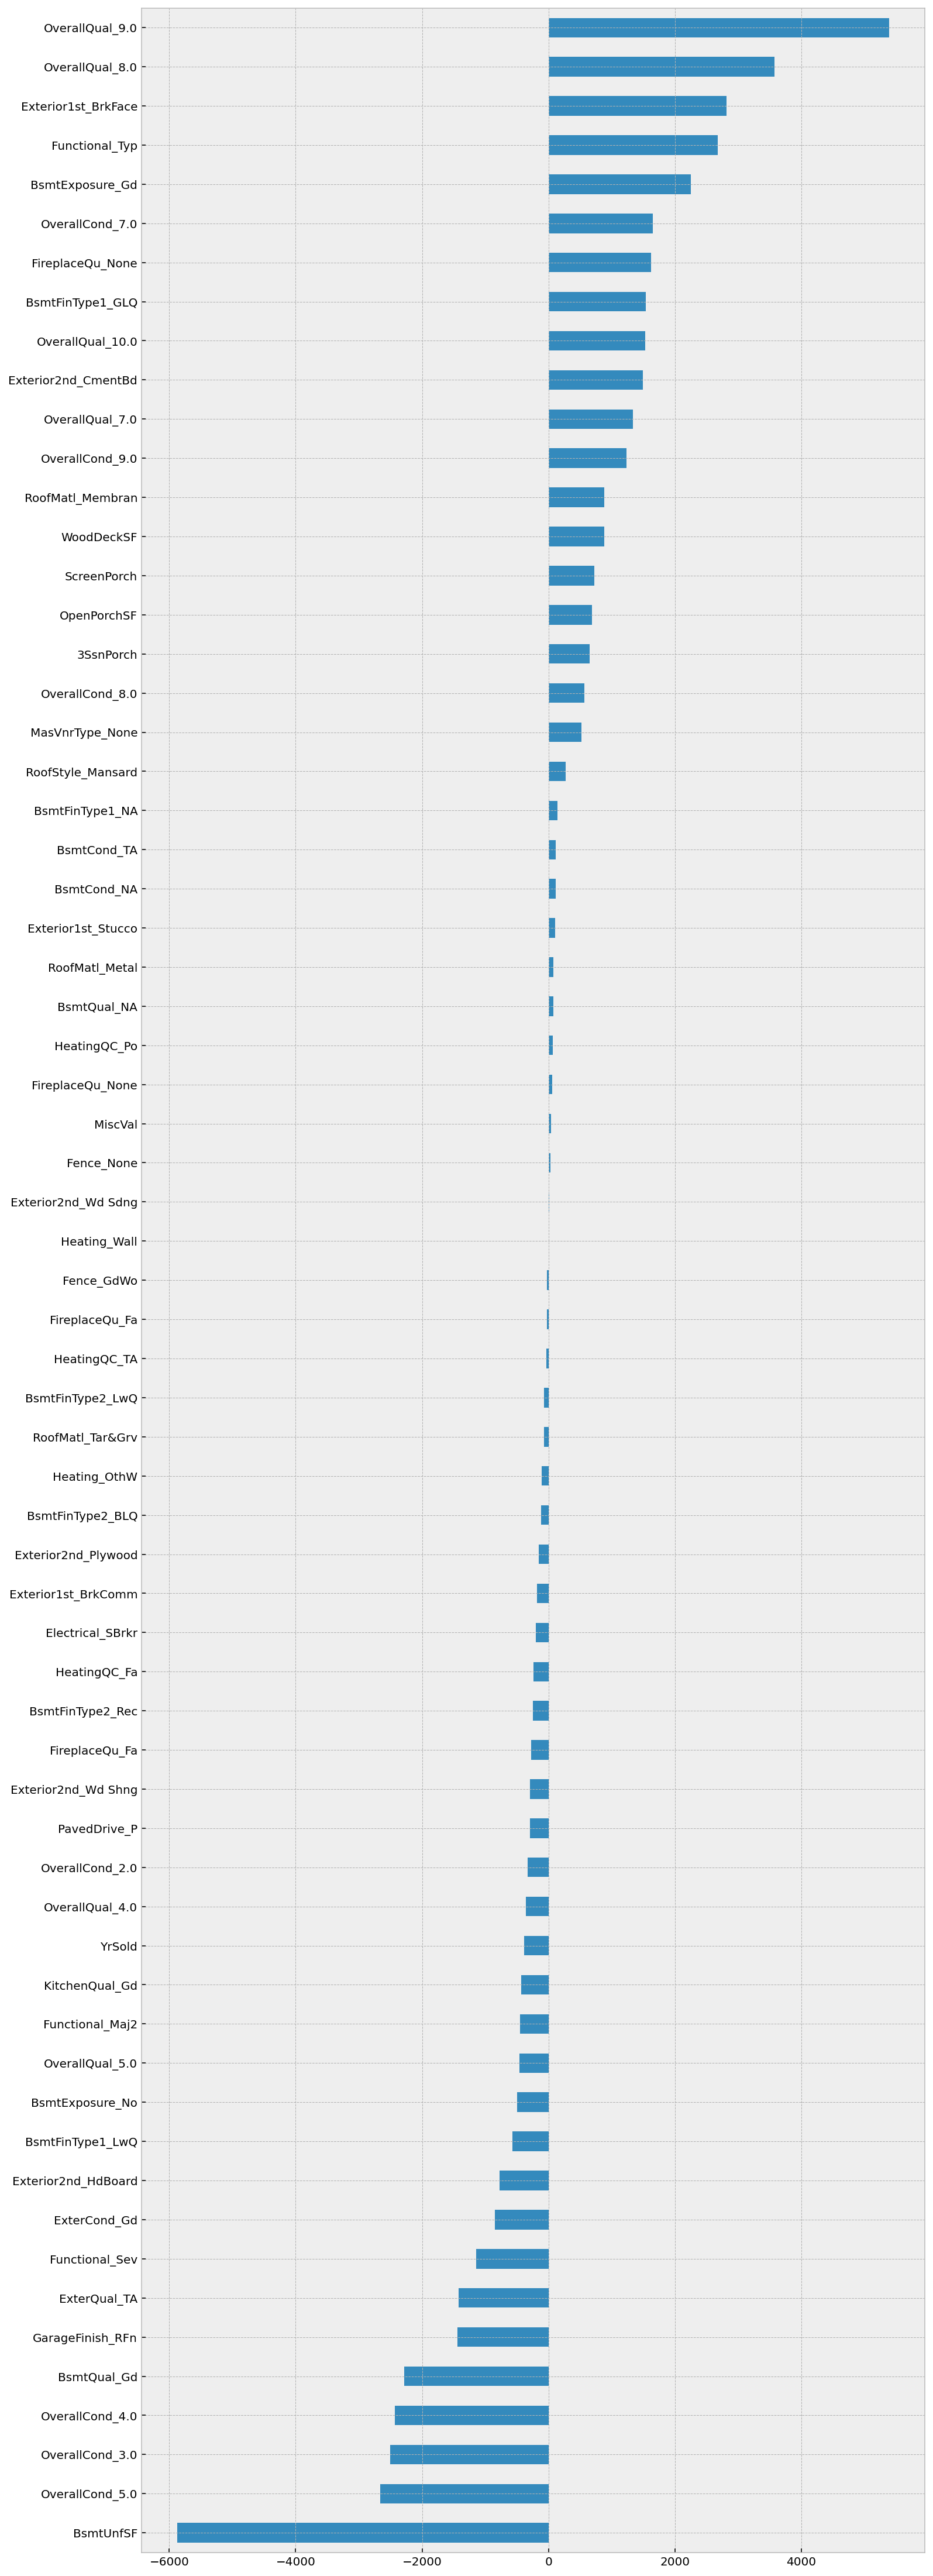

In [124]:
fig, ax = plt.subplots(figsize=(12,40))
reno_coef[reno_coef['coef_abs']>0]['coefficients'].sort_values().plot(kind='barh');

### Conclusion :-

NB: the variables here represent the value in dollars 1 standard deviation away from the mean.

In [125]:
print('std : ', df_reno['BsmtUnfSF'].std(),'mean : ', df_reno['BsmtUnfSF'].mean())

std :  438.8430669608568 mean :  564.0527065527066


In [126]:
reno_coef['coef_abs'].loc['BsmtUnfSF']

5872.576511279364

In [127]:
df_resi[['Residuals',
        'BsmtUnfSF',
        'OverallCond',
        'GarageFinish',
        'SalePrice',
        'ExterQual']][(df_resi['BsmtUnfSF']>564+439)].sort_values(by='Residuals').head(20)

Residuals  BsmtUnfSF  OverallCond GarageFinish  SalePrice ExterQual
Id                                                                           
1325 -141784.619747       1795            5          RFn     147000        Gd
582   -94130.256512       2042            5          RFn     253293        Ex
663   -78485.665631       1392            3          RFn     110000        TA
411   -77771.139254       1276            3          Unf      60000        TA
1224  -72873.718597       1380            3          Unf     137900        TA
1454  -72593.991273       1140            5          NaN      84500        TA
67    -68162.880706       1035            5          RFn     180000        TA
1252  -60465.460305       1405            5          RFn     171750        Gd
729   -58479.133157       1584            5          Unf     110000        TA
446   -49714.706227       1436            5          Unf     127500        TA
632   -48801.028863       1530            5          RFn     209500        Gd
553   -45834.689611       1709            5          RFn     255500        Gd
1127  -45460.361601       1373            5          Fin     174000        Gd
63    -44935.111423       1346            5          RFn     202500        Gd
26    -44124.513230       1566            5          RFn     256300        Gd
469   -43300.703453       1626            5          RFn     250000        Gd
983   -42426.834216       1266            5          Fin     159895        Gd
677   -40571.318876       1095            2          Unf      87000        TA
518   -40199.995665       1264            5          RFn     265000        Gd
333   -39904.399251       1603            5          RFn     284000        Gd

The above dataframe are properties that I would of at least spent more time looking at, the BsmtUnfSF alone allowed for a budget to spend on doing renovation work of at least $5,800 and alot of them also have an OverallCond which if could be improved to gainm more profit.

As well as them almost all having an unfinshed or rough-finished Garage, another variable which could make profit.



Using this mdoel to accurately predict which variables should be considered in buying a property in order to sell for a profit is probably not very trustworthy.

However it does point to a few variables which may have a large swing if they can be fixed adequately. These being 'BsmtUnfSF', low 'OverallCond', 'ExterQual', and 'GarageFinish'.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [128]:
residential.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [129]:
# A:
class_test = residential.copy()

In [130]:
class_test['SaleCondition'].apply(lambda x: 1 if x=='Abnorml' else 0).value_counts(normalize=True)

0    0.933793
1    0.066207
Name: SaleCondition, dtype: float64

This means we will have to get a very accurate score for non-normal Sale Conditions for this model to be usable.

In [131]:
class_test['AbnormalSale'] = class_test['SaleCondition'].apply(lambda x:
                                                              1 if x=='Abnorml' else 0)

I assume we would not have this data so therefore I remove it from the modelling.

In [132]:
class_test.drop(columns=['SaleCondition', 'SaleType', 'SalePrice'], inplace=True)

In [133]:
X_class = pd.get_dummies(class_test,
                             columns=[col for col in to_be_dummified if 'Sale' not in col]+
                             ['Alley', 'GarageQual','GarageCond','PoolQC', 'MiscFeature'],
                             drop_first=True, dummy_na=True)

In [134]:
X_class['MasVnrArea'] = X_class['MasVnrArea'].fillna(0)

In [135]:
X_class.set_index('Id', inplace=True)

In [136]:
X_train = X_class[X_class['YrSold']!=2010]
X_test = X_class[X_class['YrSold']==2010]
y_train = X_train.pop('AbnormalSale')
y_test = X_test.pop('AbnormalSale')


In [137]:
# y_class = class_test.pop('AbnormalSale')

In [138]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [139]:

# X_train = X_class[X_class['YrSold']!=2010]

In [140]:
# X_train, X_test, y_train, y_test = train_test_split(X_class, y_class,
#                         stratify=y_class, test_size=0.2, random_state=1)

In [141]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X_class.drop(columns='AbnormalSale').columns)
X_test = pd.DataFrame(X_test, columns=X_class.drop(columns='AbnormalSale').columns)
                      

In [142]:
model = LogisticRegression(multi_class='ovr', max_iter=100000)

In [143]:
gs_params = {'penalty': ['l2'],
             'solver': ['liblinear'],
             'C': np.logspace(0, 2, 30),
             'fit_intercept' : [True,False]}

In [144]:
gs = GridSearchCV(estimator=model,
                  param_grid=gs_params,
                  cv=kf,
                  scoring='accuracy',
                  return_train_score=True,
                  verbose=10,
                  n_jobs=2,
                 )

In [145]:
y_train.value_counts()

0    1191
1      87
Name: AbnormalSale, dtype: int64

In [146]:
y_train.value_counts(normalize=True)

0    0.931925
1    0.068075
Name: AbnormalSale, dtype: float64

In [147]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   17.2s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   23.8s
[Parallel(

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=100000, multi_class='ovr'),
             n_jobs=2,
             param_grid={'C': array([  1.        ,   1.1721023 ,   1.3738238 ,   1.61026203,
         1.88739182,   2.21221629,   2.5929438 ,   3.03919538,
         3.56224789,   4.17531894,   4.89390092,   5.73615251,
         6.72335754,   7.88046282,   9.23670857,  10.82636734,
        12.68961003,  14.87352107,  17.43328822,  20.43359718,
        23.9502662 ,  28.07216204,  32.90344562,  38.56620421,
        45.20353656,  52.98316906,  62.10169419,  72.78953844,
        85.31678524, 100.        ]),
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [148]:
gs_best = gs.best_estimator_
gs_best

LogisticRegression(max_iter=100000, multi_class='ovr', solver='liblinear')

In [149]:
print(gs.best_score_)

0.8771262254901961


In [150]:
from sklearn.linear_model import LogisticRegressionCV

lr_ridge = LogisticRegressionCV(
    penalty='l2', Cs=100, cv=kf, max_iter=100000)
lr_ridge.fit(X_train, y_train)

print(lr_ridge.C_)
print(lr_ridge.score(X_train, y_train))
print(lr_ridge.score(X_test, y_test))

[0.0001]
0.931924882629108
0.9476744186046512


In [151]:
ridge = LogisticRegression(C=lr_ridge.C_[0], penalty='l2', solver='lbfgs')
ridge.fit(X_train, y_train)
cross_val_score(model, X_train, y_train, cv=kf).mean()

0.8849571078431373

The above scores represent around baseline. In order to achieve a better model we may have to do some oversampling and undersampling.

### Using SMOTE from imblearn

We will balance the Abnormal class and the non-Abnormal class to see if a better model can be created. The Smote technique takes the each class and balances them out by adding more values of the minority class which are very close to other's of the minority class.

In [152]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from numpy import where
# define dataset


In [153]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, n_jobs=2)
X_res, y_res = sm.fit_resample(np.array(X_train), np.array(y_train))

In [154]:
df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
# rename the columns
df.columns = list(X_train.columns)+['AbnormalSale']
df.head()

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0    -0.167045 -0.202915   1.038568      0.875532    0.490654    0.571958   
1     0.093855 -0.092329   0.146572     -0.436226   -0.569494    1.163930   
2    -0.114865  0.066337   0.972494      0.826948    0.306751    0.093156   
3    -0.254011 -0.097137  -1.868678     -0.727728   -0.569494   -0.494463   
4     0.163428  0.355783   0.939457      0.729781    1.323628    0.460963   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0   -0.285098  -0.945094    -0.460408 -0.796427  1.148046     -0.122443   
1   -0.285098  -0.645103     0.457066  0.252007 -0.803350     -0.122443   
2   -0.285098  -0.309293    -0.315782 -0.631156  1.175466     -0.122443   
3   -0.285098  -0.071986    -0.686387 -0.525280  0.924115     -0.122443   
4   -0.285098  -0.183923     0.192671 -0.050127  1.602762     -0.122443   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   0.356109      1.129289     -0.251787  0.776644  1.218379      0.162086   
1  -0.492294     -0.802748      3.770504  0.776644 -0.765173      0.162086   
2   0.500035      1.129289     -0.251787  0.776644  1.218379      0.162086   
3   0.369366      1.129289     -0.251787 -1.041215 -0.765173      0.162086   
4   1.280263      1.129289     -0.251787  0.776644  1.218379      1.387801   

   KitchenAbvGr  TotRmsAbvGrd  Fireplaces  Has_Garage  GarageCars  GarageArea  \
0     -0.205061      0.910241   -0.970020    0.237062    0.292575    0.333297   
1     -0.205061     -0.322709    0.593266    0.237062    0.292575   -0.074931   
2     -0.205061     -0.322709    0.593266    0.237062    0.292575    0.611635   
3     -0.205061      0.293766    0.593266    0.237062    1.627973    0.769360   
4     -0.205061      1.526715    0.593266    0.237062    1.627973    1.669319   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0   -0.756584     0.197698      -0.348237  -0.118498    -0.269975 -0.073445   
1    1.653565    -0.714047      -0.348237  -0.118498    -0.269975 -0.073445   
2   -0.756584    -0.086288      -0.348237  -0.118498    -0.269975 -0.073445   
3   -0.756584    -0.190915       4.117668  -0.118498    -0.269975 -0.073445   
4    0.796263     0.541471      -0.348237  -0.118498    -0.269975 -0.073445   

   MiscVal    MoSold    YrSold  Has_Pool   TotalSF  RecentRemodAdd  \
0 -0.07563 -1.687780  0.428763 -0.074212  0.135601        0.905822   
1 -0.07563 -0.581824 -0.460781 -0.074212 -0.237016       -1.103970   
2 -0.07563  0.892784  0.428763 -0.074212  0.299857        0.905822   
3 -0.07563 -1.687780 -1.350325 -0.074212  0.070203       -1.103970   
4 -0.07563  1.998740  0.428763 -0.074212  1.097563        0.905822   

   MSSubClass_30.0  MSSubClass_40.0  MSSubClass_45.0  MSSubClass_50.0  \
0        -0.221948        -0.048507        -0.097358        -0.332173   
1        -0.221948        -0.048507        -0.097358        -0.332173   
2        -0.221948        -0.048507        -0.097358        -0.332173   
3        -0.221948        -0.048507        -0.097358        -0.332173   
4        -0.221948        -0.048507        -0.097358        -0.332173   

   MSSubClass_60.0  MSSubClass_70.0  MSSubClass_75.0  MSSubClass_80.0  \
0         1.945897        -0.210042        -0.112598        -0.203874   
1        -0.513902        -0.210042        -0.112598        -0.203874   
2         1.945897        -0.210042        -0.112598        -0.203874   
3        -0.513902         4.760952        -0.112598        -0.203874   
4         1.945897        -0.210042        -0.112598        -0.203874   

   MSSubClass_85.0  MSSubClass_90.0  MSSubClass_120.0  MSSubClass_160.0  \
0        -0.112598         -0.19104         -0.251452         -0.212065   
1        -0.112598         -0.19104         -0.251452         -0.212065   
2        -0.112598         -0.19104         -0.251452         -0.212065   
3        -0.112598         -0.19104         -0.251452      

In [155]:
df.shape

(2382, 333)

In [156]:
df['AbnormalSale'].value_counts(normalize=True)

1    0.5
0    0.5
Name: AbnormalSale, dtype: float64

We now have a balanced classification set to see if we can get a better model to work.

In [157]:
X_restrain = df.copy()

y_restrain = X_restrain.pop('AbnormalSale')

In [158]:
y_restrain.value_counts()

1    1191
0    1191
Name: AbnormalSale, dtype: int64

In [159]:
gs.fit(X_restrain, y_restrain)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   23.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   28.1s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   34.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   41.0s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   49.0s
[Parallel(

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=100000, multi_class='ovr'),
             n_jobs=2,
             param_grid={'C': array([  1.        ,   1.1721023 ,   1.3738238 ,   1.61026203,
         1.88739182,   2.21221629,   2.5929438 ,   3.03919538,
         3.56224789,   4.17531894,   4.89390092,   5.73615251,
         6.72335754,   7.88046282,   9.23670857,  10.82636734,
        12.68961003,  14.87352107,  17.43328822,  20.43359718,
        23.9502662 ,  28.07216204,  32.90344562,  38.56620421,
        45.20353656,  52.98316906,  62.10169419,  72.78953844,
        85.31678524, 100.        ]),
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [160]:
gs.best_score_

0.8900093370681607

In [161]:
from sklearn.linear_model import LogisticRegressionCV

lr_ridge = LogisticRegressionCV(
    penalty='l2', Cs=100, cv=kf, max_iter=100000)
lr_ridge.fit(X_restrain, y_restrain)

print(lr_ridge.C_)
print(lr_ridge.score(X_restrain, y_restrain))
print(lr_ridge.score(X_test, y_test))

[200.92330026]
0.947103274559194
0.8081395348837209


In [162]:
res_ridge = LogisticRegression(C=lr_ridge.C_[0], penalty='l2',
                           solver='lbfgs', max_iter=10000)
res_ridge.fit(X_restrain, y_restrain)
cross_val_score(res_ridge, X_restrain, y_restrain, cv=kf).mean()

0.8996679174814579

In [163]:
ridge.predict_proba(X_restrain)

array([[0.93596174, 0.06403826],
       [0.9338937 , 0.0661063 ],
       [0.93725239, 0.06274761],
       ...,
       [0.92412282, 0.07587718],
       [0.93365057, 0.06634943],
       [0.92944203, 0.07055797]])

In [164]:
from sklearn.metrics import plot_confusion_matrix

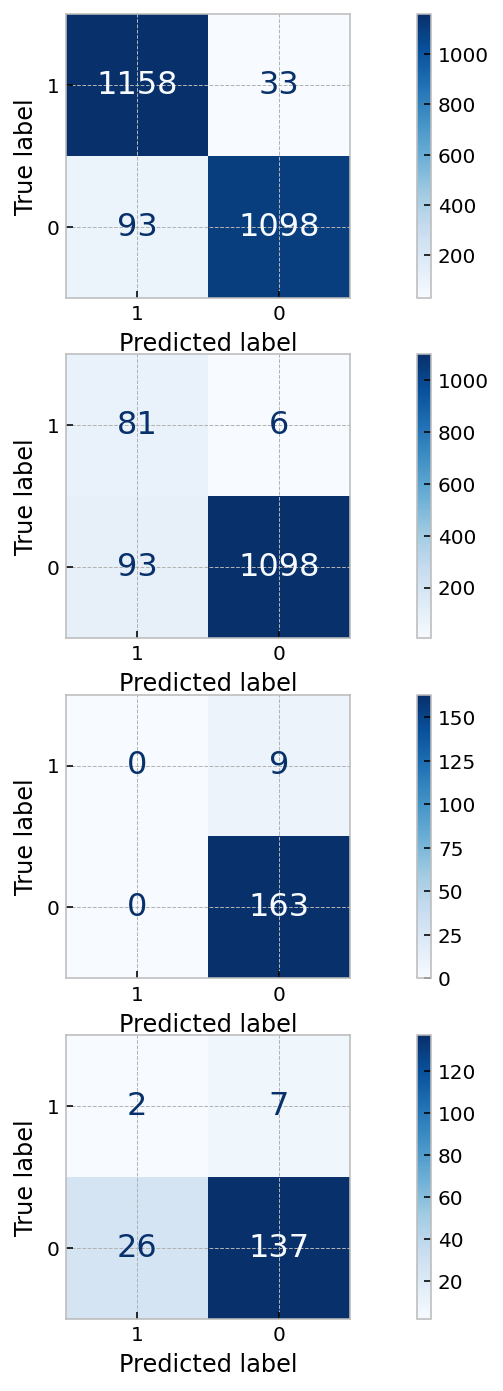

In [165]:
fig, ax = plt.subplots(figsize=(12,12), nrows=4, sharey=True)
plot_confusion_matrix(res_ridge, X_restrain, y_restrain, cmap='Blues', labels=[1, 0],
                            values_format='.0f', ax=ax[0])
plot_confusion_matrix(res_ridge, X_train, y_train, cmap='Blues', labels=[1, 0],
                            values_format='.0f', ax=ax[1])
plot_confusion_matrix(ridge, X_test, y_test, cmap='Blues', labels=[1, 0],
                            values_format='.0f', ax=ax[2])
plot_confusion_matrix(res_ridge, X_test, y_test, cmap='Blues', labels=[1, 0],
                            values_format='.0f', ax=ax[3])

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)

plt.show()

The above confusuion matricies show a very low recall for the predicted class and actual class

In [166]:
Y_pp = pd.DataFrame(res_ridge.predict_proba(X_test), 
             columns=['class_0_pp', 'class_1_pp'])
Y_pp['Abnormal'] = list(y_test)
Y_pp.sort_values(by='class_1_pp').head(20)

class_0_pp    class_1_pp  Abnormal
84          1.0  4.625687e-93         0
132         1.0  2.106405e-80         0
145         1.0  1.107875e-58         0
93          1.0  1.177963e-51         0
170         1.0  5.591525e-51         0
160         1.0  1.767992e-46         0
23          1.0  2.961115e-41         0
65          1.0  5.678668e-37         0
104         1.0  4.416589e-31         0
48          1.0  8.017576e-28         0
82          1.0  1.042330e-27         0
122         1.0  1.359787e-23         1
147         1.0  1.543693e-23         0
139         1.0  6.620604e-23         0
28          1.0  4.180291e-21         0
41          1.0  1.091863e-20         0
168         1.0  1.187122e-20         0
66          1.0  4.486022e-19         0
81          1.0  4.139475e-18         0
109         1.0  6.535442e-18         0

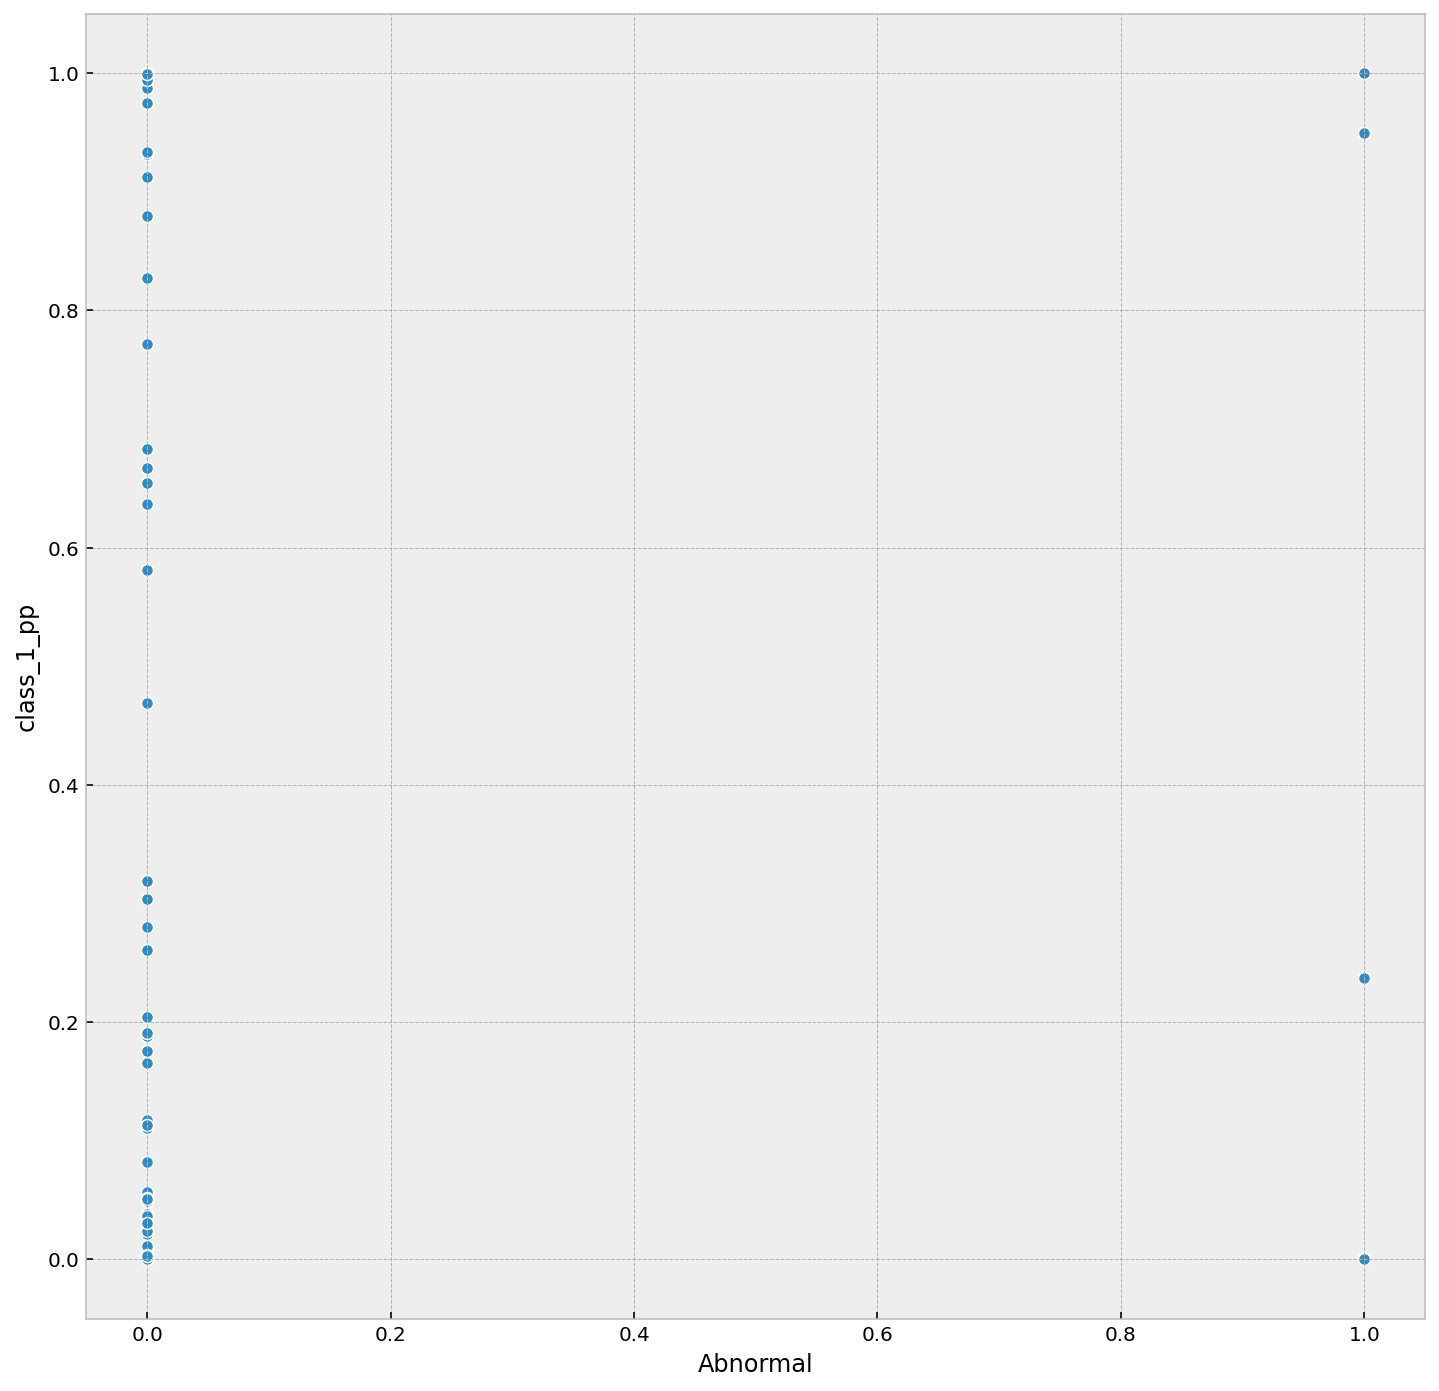

In [167]:
fig, ax = plt.subplots(figsize=(12,12,))
sns.scatterplot(Y_pp['Abnormal'], Y_pp['class_1_pp']);

There is no potential moving of the freshold to get a better recall score in the test data. I would need to try another oversampling or undersampling method.

In [169]:
from sklearn.metrics import classification_report

In [170]:
print(classification_report(y_train, res_ridge.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1191
           1       0.47      0.93      0.62        87

    accuracy                           0.92      1278
   macro avg       0.73      0.93      0.79      1278
weighted avg       0.96      0.92      0.93      1278



In [171]:
print(classification_report(y_test, res_ridge.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       163
           1       0.07      0.22      0.11         9

    accuracy                           0.81       172
   macro avg       0.51      0.53      0.50       172
weighted avg       0.91      0.81      0.85       172



In [172]:
print(classification_report(y_restrain, res_ridge.predict(X_restrain)))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1191
           1       0.93      0.97      0.95      1191

    accuracy                           0.95      2382
   macro avg       0.95      0.95      0.95      2382
weighted avg       0.95      0.95      0.95      2382

